In [4]:
import albumentations as A
import os
import cv2
import numpy as np
import tifffile
from sklearn.model_selection import train_test_split
from cellpose import models, train, io
import matplotlib.pyplot as plt
from cellpose import plot
from cellpose import utils, io

io.logger_setup()  # Run this to get printing of progress

# Define paths
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

# Collect all image and mask file paths
image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

# Ensure that each image has a corresponding mask
assert len(image_files) == len(mask_files), "Number of images and masks must match."

# Load all images and masks
images = [tifffile.imread(os.path.join(data_dir, img))[:, 1, :, :] for img in image_files]
masks = [tifffile.imread(os.path.join(data_dir, msk)) for msk in mask_files]

# Ensure images and masks have the same number of frames
for img, msk in zip(images, masks):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

# Convert lists to numpy arrays
images = np.concatenate(images, axis=0)
masks = np.concatenate(masks, axis=0)

# Normalize images to 0-1 range
images = images.astype(np.float32) / 255.0

# Convert masks to uint8 if needed
masks_uint8 = masks.astype(np.uint8)

# Define an augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
], is_check_shapes=False)

augmented_images = []
augmented_masks = []

# Augment each image multiple times
num_augmentations = 5  # Number of times to augment each image

for img, msk in zip(images, masks_uint8):
    for _ in range(num_augmentations):
        # Apply the augmentation pipeline
        transformed = transform(image=img, mask=msk)
        augmented_images.append(transformed['image'])
        augmented_masks.append(transformed['mask'])

# Convert lists to numpy arrays and combine with original data
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Combine original and augmented data
images_combined = np.concatenate((images, augmented_images), axis=0)
masks_combined = np.concatenate((masks_uint8, augmented_masks), axis=0)

# Split data into train+val and test
train_val_images, test_images, train_val_masks, test_masks = train_test_split(
    images_combined, masks_combined, test_size=0.15, random_state=42
)

# Split train+val into train and validation
train_images, val_images, train_masks, val_masks = train_test_split(
    train_val_images, train_val_masks, test_size=0.176, random_state=42  # 0.176 to make validation 15% of total
)

# Initialize Cellpose model
model = models.CellposeModel(gpu=True, model_type='cyto2_cp3')

# Train the model with augmented data
train.train_seg(
    model.net,
    train_data=train_images,
    train_labels=train_masks,
    test_data=val_images, 
    test_labels=val_masks,
    channels=[0, 0],  # Adjust channels if needed
    normalize=True,
    weight_decay=1e-4,
    SGD=False,
    learning_rate=0.1,
    n_epochs=1000,
    save_path='/root/capsule/scratch/caleb_cellpose/',
    model_name='custom_cellpose_model.pth'
)

2024-10-06 21:46:11,433 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2024-10-06 21:46:11,433 [INFO] 
cellpose version: 	3.0.12.dev87+g52f75f9 
platform:       	linux 
python version: 	3.10.12 
torch version:  	2.1.0
2024-10-06 21:46:20,747 [INFO] >> cyto2_cp3 << model set to be used
2024-10-06 21:46:21,945 [INFO] ** TORCH CUDA version installed and working. **
2024-10-06 21:46:21,945 [INFO] >>>> using GPU (CUDA)
2024-10-06 21:46:22,011 [INFO] >>>> loading model /root/.cellpose/models/cyto2_cp3
2024-10-06 21:46:22,089 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-10-06 21:46:22,093 [INFO] computing flows for labels


  6%|▌         | 43/705 [00:03<00:35, 18.88it/s]

2024-10-06 21:46:27,063 [WARNING] empty masks!


  9%|▉         | 63/705 [00:05<00:36, 17.73it/s]

2024-10-06 21:46:28,255 [WARNING] empty masks!


 15%|█▍        | 103/705 [00:08<00:41, 14.67it/s]

2024-10-06 21:46:31,091 [WARNING] empty masks!


 19%|█▉        | 135/705 [00:10<00:46, 12.32it/s]

2024-10-06 21:46:33,553 [WARNING] empty masks!


 21%|██        | 145/705 [00:10<00:31, 17.55it/s]

2024-10-06 21:46:34,037 [WARNING] empty masks!


 24%|██▍       | 171/705 [00:12<00:36, 14.68it/s]

2024-10-06 21:46:35,773 [WARNING] empty masks!


 30%|██▉       | 209/705 [00:15<00:52,  9.51it/s]

2024-10-06 21:46:38,760 [WARNING] empty masks!


 42%|████▏     | 293/705 [00:20<00:29, 13.99it/s]

2024-10-06 21:46:43,875 [WARNING] empty masks!


 42%|████▏     | 298/705 [00:20<00:23, 17.28it/s]

2024-10-06 21:46:44,046 [WARNING] empty masks!


 43%|████▎     | 301/705 [00:21<00:20, 19.54it/s]

2024-10-06 21:46:44,445 [WARNING] empty masks!


 55%|█████▌    | 391/705 [00:27<00:22, 14.13it/s]

2024-10-06 21:46:50,399 [WARNING] empty masks!


 56%|█████▋    | 398/705 [00:27<00:21, 14.35it/s]

2024-10-06 21:46:50,923 [WARNING] empty masks!


 61%|██████    | 431/705 [00:29<00:13, 19.62it/s]

2024-10-06 21:46:52,818 [WARNING] empty masks!


 67%|██████▋   | 473/705 [00:32<00:12, 18.93it/s]

2024-10-06 21:46:55,210 [WARNING] empty masks!


 69%|██████▉   | 485/705 [00:32<00:13, 15.87it/s]

2024-10-06 21:46:55,940 [WARNING] empty masks!


 73%|███████▎  | 515/705 [00:35<00:12, 15.75it/s]

2024-10-06 21:46:58,147 [WARNING] empty masks!


 75%|███████▍  | 528/705 [00:35<00:10, 17.13it/s]

2024-10-06 21:46:58,880 [WARNING] empty masks!


 92%|█████████▏| 646/705 [00:43<00:07,  8.28it/s]

2024-10-06 21:47:07,038 [WARNING] empty masks!


 99%|█████████▉| 699/705 [00:47<00:00, 13.30it/s]

2024-10-06 21:47:10,751 [WARNING] empty masks!


100%|█████████▉| 704/705 [00:47<00:00, 17.16it/s]

2024-10-06 21:47:10,870 [WARNING] empty masks!


100%|██████████| 705/705 [00:47<00:00, 14.74it/s]

2024-10-06 21:47:10,879 [INFO] computing flows for labels



 35%|███▌      | 53/151 [00:03<00:05, 17.72it/s]

2024-10-06 21:47:14,666 [WARNING] empty masks!


 37%|███▋      | 56/151 [00:03<00:04, 20.01it/s]

2024-10-06 21:47:14,835 [WARNING] empty masks!


 49%|████▉     | 74/151 [00:04<00:04, 17.98it/s]

2024-10-06 21:47:15,831 [WARNING] empty masks!


 53%|█████▎    | 80/151 [00:05<00:03, 19.51it/s]

2024-10-06 21:47:16,112 [WARNING] empty masks!


 57%|█████▋    | 86/151 [00:05<00:04, 15.35it/s]

2024-10-06 21:47:16,545 [WARNING] empty masks!


 85%|████████▌ | 129/151 [00:08<00:01, 17.47it/s]

2024-10-06 21:47:19,228 [WARNING] empty masks!


100%|██████████| 151/151 [00:09<00:00, 16.09it/s]

2024-10-06 21:47:20,469 [INFO] >>> computing diameters



  5%|▍         | 32/705 [00:00<00:02, 311.04it/s]/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 151/151 [00:00<00:00, 316.48it/s]

2024-10-06 21:47:23,187 [WARNING] 121 train images with number of masks less than min_train_masks (5), removing from train set
2024-10-06 21:47:23,188 [INFO] >>> using channels [0, 0]
2024-10-06 21:47:23,189 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2024-10-06 21:47:51,524 [INFO] >>> n_epochs=1000, n_train=584, n_test=151
2024-10-06 21:47:51,524 [INFO] >>> AdamW, learning_rate=0.10000, weight_decay=0.00010


FileNotFoundError: [Errno 2] No such file or directory: '/root/capsule/scratch/caleb_cellpose/models'

In [2]:
# Load cellpose model
from cellpose import models

def load_cellpose_modelpath(model_path: str,
                            gpu: bool = True) -> models.CellposeModel:

    # load cellpose model
    print('Loading Cellpose Models from folder ...')
    model = models.CellposeModel(gpu=True, pretrained_model=model_path)

    return model

model = load_cellpose_modelpath('/root/capsule/scratch/caleb_cellpose/models/custom_cellpose_model.pth')

import albumentations as A
import os
import cv2
import numpy as np
import tifffile
from sklearn.model_selection import train_test_split
from cellpose import models, train, io
import matplotlib.pyplot as plt
from cellpose import plot
from cellpose import utils, io

io.logger_setup()  # Run this to get printing of progress

# Define paths
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

# Collect all image and mask file paths
image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

# Ensure that each image has a corresponding mask
assert len(image_files) == len(mask_files), "Number of images and masks must match."

# Load all images and masks
images = [tifffile.imread(os.path.join(data_dir, img))[:, 1, :, :] for img in image_files]
masks = [tifffile.imread(os.path.join(data_dir, msk)) for msk in mask_files]

# Ensure images and masks have the same number of frames
for img, msk in zip(images, masks):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

# Convert lists to numpy arrays
images = np.concatenate(images, axis=0)
masks = np.concatenate(masks, axis=0)

# Normalize images to 0-1 range
images = images.astype(np.float32) / 255.0

# Convert masks to uint8 if needed
masks_uint8 = masks.astype(np.uint8)

# Define an augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
], is_check_shapes=False)

augmented_images = []
augmented_masks = []

# Augment each image multiple times
num_augmentations = 5  # Number of times to augment each image

for img, msk in zip(images, masks_uint8):
    for _ in range(num_augmentations):
        # Apply the augmentation pipeline
        transformed = transform(image=img, mask=msk)
        augmented_images.append(transformed['image'])
        augmented_masks.append(transformed['mask'])

# Convert lists to numpy arrays and combine with original data
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Combine original and augmented data
images_combined = np.concatenate((images, augmented_images), axis=0)
masks_combined = np.concatenate((masks_uint8, augmented_masks), axis=0)

# Split data into train+val and test
train_val_images, test_images, train_val_masks, test_masks = train_test_split(
    images_combined, masks_combined, test_size=0.15, random_state=42
)

# Split train+val into train and validation
train_images, val_images, train_masks, val_masks = train_test_split(
    train_val_images, train_val_masks, test_size=0.176, random_state=42  # 0.176 to make validation 15% of total
)

Loading Cellpose Models from folder ...
2024-09-15 00:26:50,891 [INFO] ** TORCH CUDA version installed and working. **
2024-09-15 00:26:50,892 [INFO] >>>> using GPU (CUDA)
2024-09-15 00:26:50,954 [INFO] >>>> loading model /root/capsule/scratch/caleb_cellpose/models/custom_cellpose_model.pth
2024-09-15 00:26:51,141 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-09-15 00:26:51,142 [INFO] >>>> model diam_labels =  45.890 (mean diameter of training ROIs)
2024-09-15 00:26:51,144 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2024-09-15 00:26:51,144 [INFO] 
cellpose version: 	3.0.11 
platform:       	linux 
python version: 	3.10.12 
torch version:  	2.1.0


In [3]:
import numpy as np
import pandas as pd
from cellpose import models

# Prepare a list to store the results
results_list = []

# Define a function to calculate metrics
def calculate_metrics(true_mask, masks_pred):
    # Dice Score
    intersection = np.logical_and(true_mask, masks_pred)
    dice_score = 2. * intersection.sum() / (true_mask.sum() + masks_pred.sum())

    # IoU Score
    union = np.logical_or(true_mask, masks_pred)
    iou_score = intersection.sum() / union.sum() if union.sum() > 0 else 0

    # Pixel Accuracy
    pixel_accuracy = np.sum(true_mask == masks_pred) / true_mask.size

    # Number of ROIs
    num_rois_true = np.unique(true_mask).size - 1  # Exclude background
    num_rois_pred = np.unique(masks_pred).size - 1  # Exclude background

    return {
        "Dice Score": dice_score,
        "IoU Score": iou_score,
        "Pixel Accuracy": pixel_accuracy,
        "Number of True ROIs": num_rois_true,
        "Number of Predicted ROIs": num_rois_pred
    }

# Loop through all test images
for i, (image, true_mask) in enumerate(zip(test_images, test_masks)):
    # Evaluate the model on the test image
    results = model.eval(image, channels=[0, 0])
    if len(results) == 3:
        masks_pred, flows, styles = results
    else:
        masks_pred, flows, styles, diams = results

    # Calculate metrics
    metrics = calculate_metrics(true_mask, masks_pred)

    # Append results to the list
    results_list.append({
        'Image_Index': i,
        'Dice_Score': metrics['Dice Score'],
        'IoU_Score': metrics['IoU Score'],
        'Pixel_Accuracy': metrics['Pixel Accuracy'],
        'Number_of_True_ROIs': metrics['Number of True ROIs'],
        'Number_of_Predicted_ROIs': metrics['Number of Predicted ROIs']
    })

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results_list)

# Save results to a CSV file
results_df.to_csv('/root/capsule/scratch/caleb_cellpose/evaluation_results.csv', index=False)

2024-09-15 00:28:15,018 [INFO] No cell pixels found.


/tmp/ipykernel_5357/185013693.py:12: RuntimeWarning: invalid value encountered in scalar divide
  dice_score = 2. * intersection.sum() / (true_mask.sum() + masks_pred.sum())


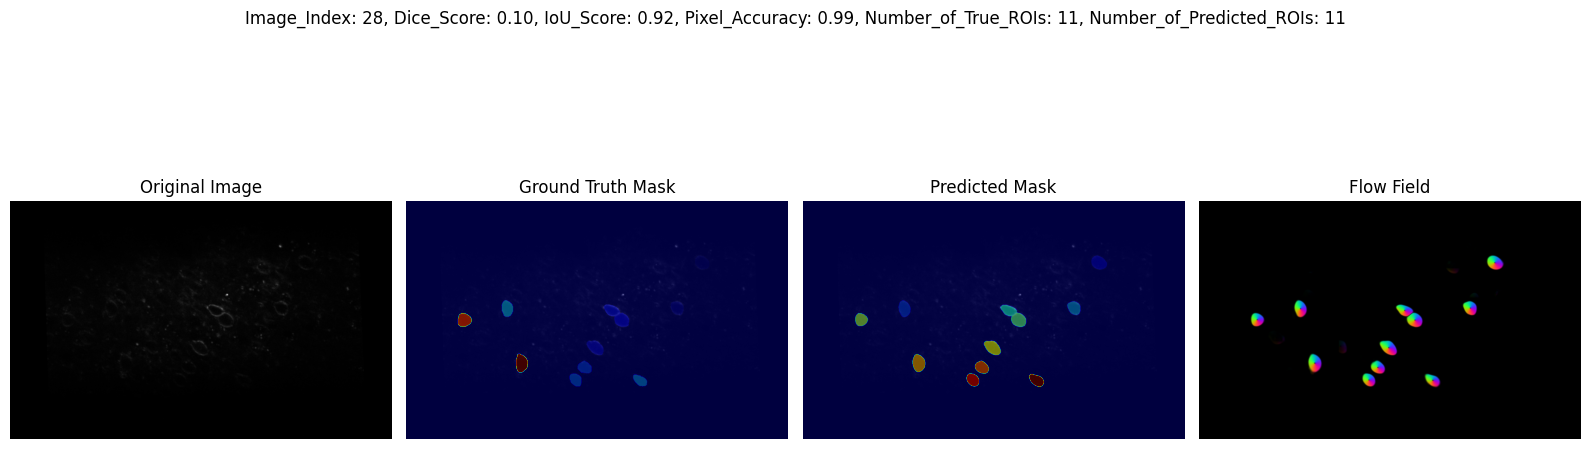

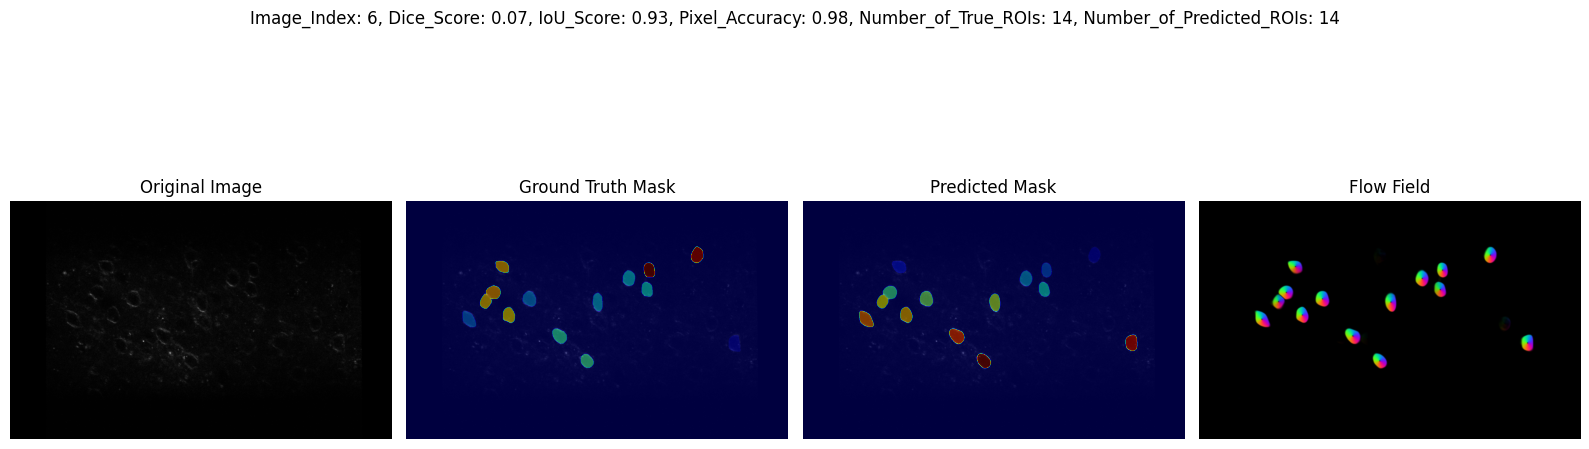

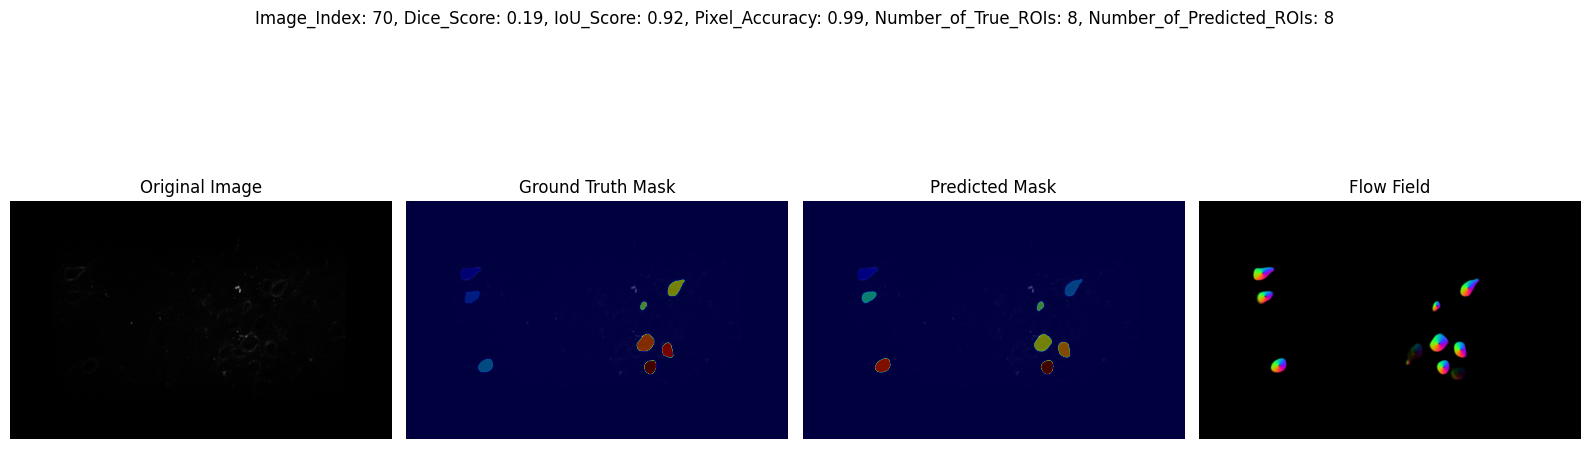

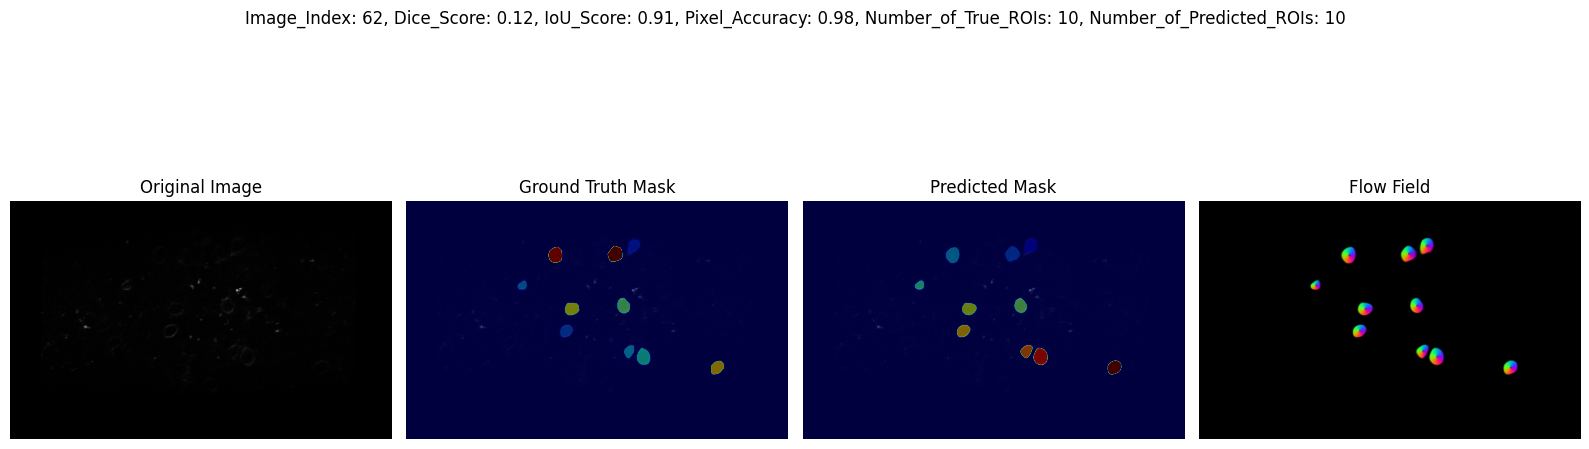

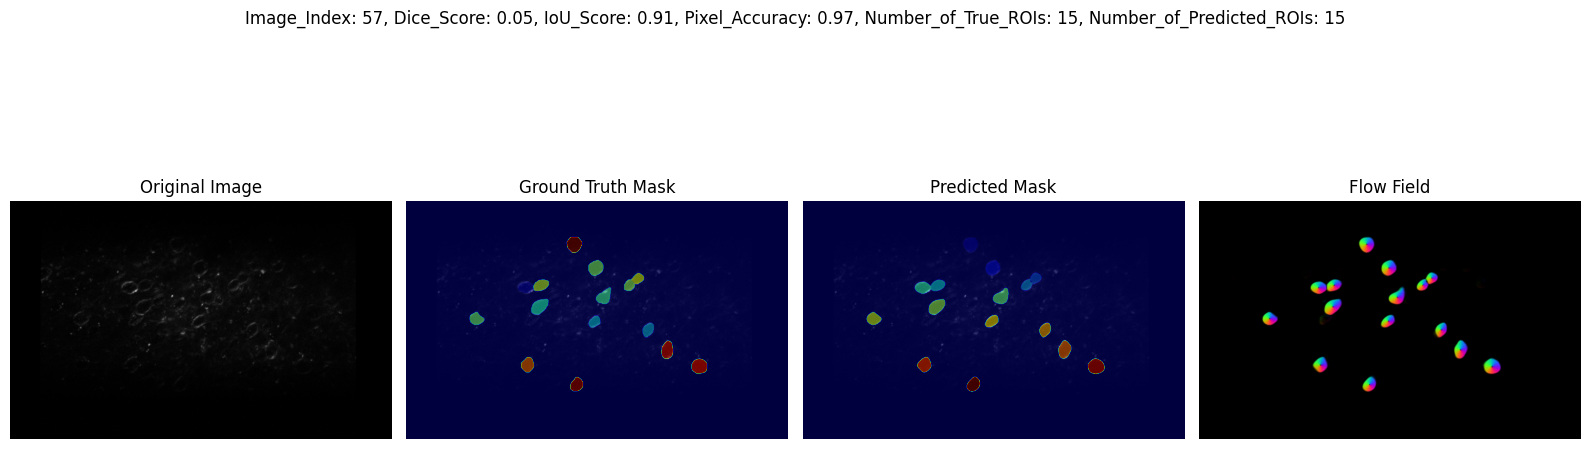

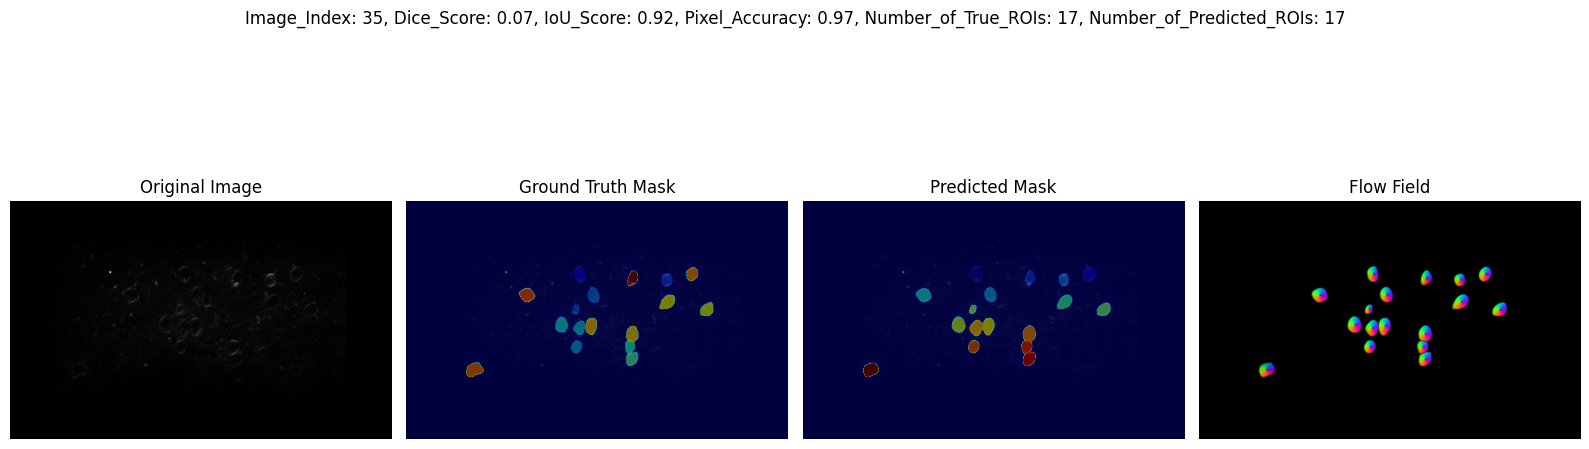

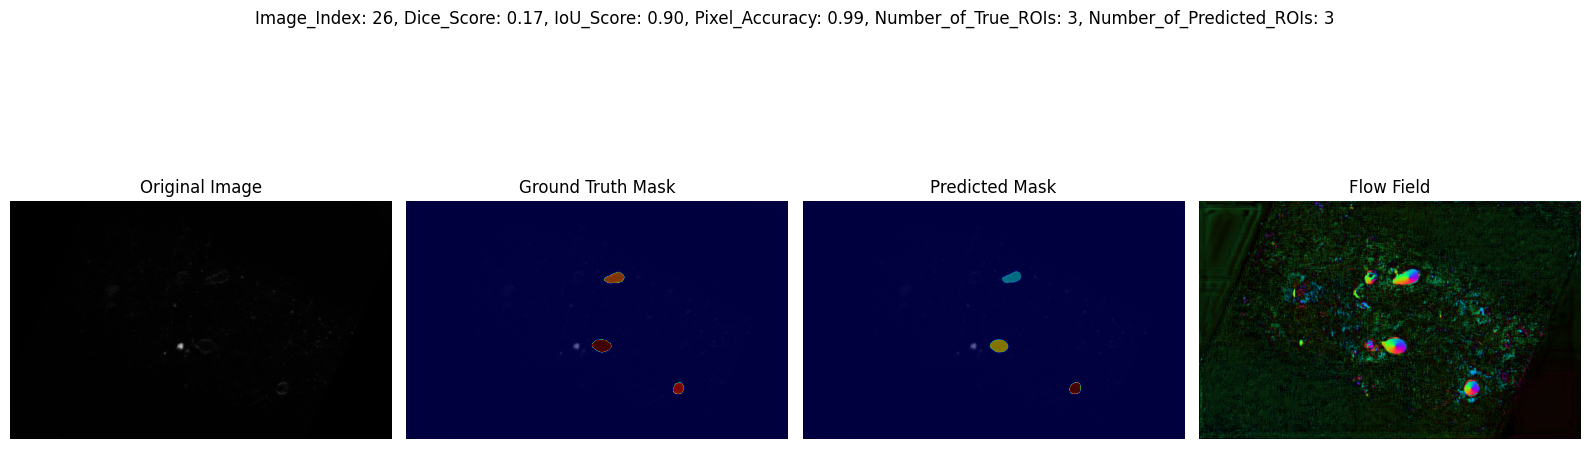

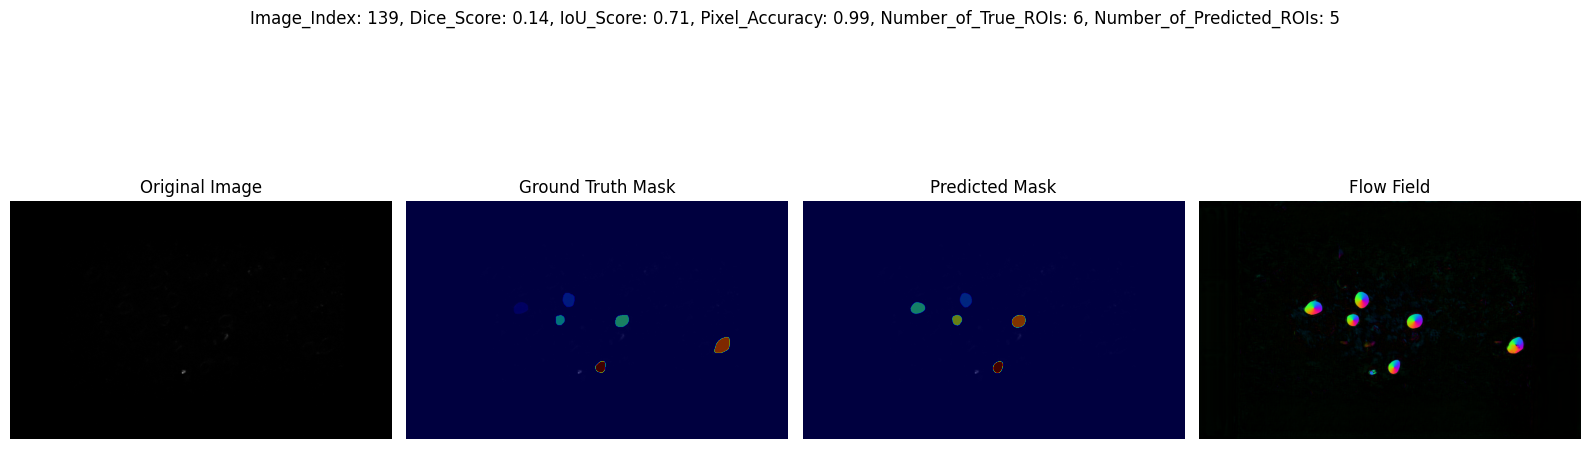

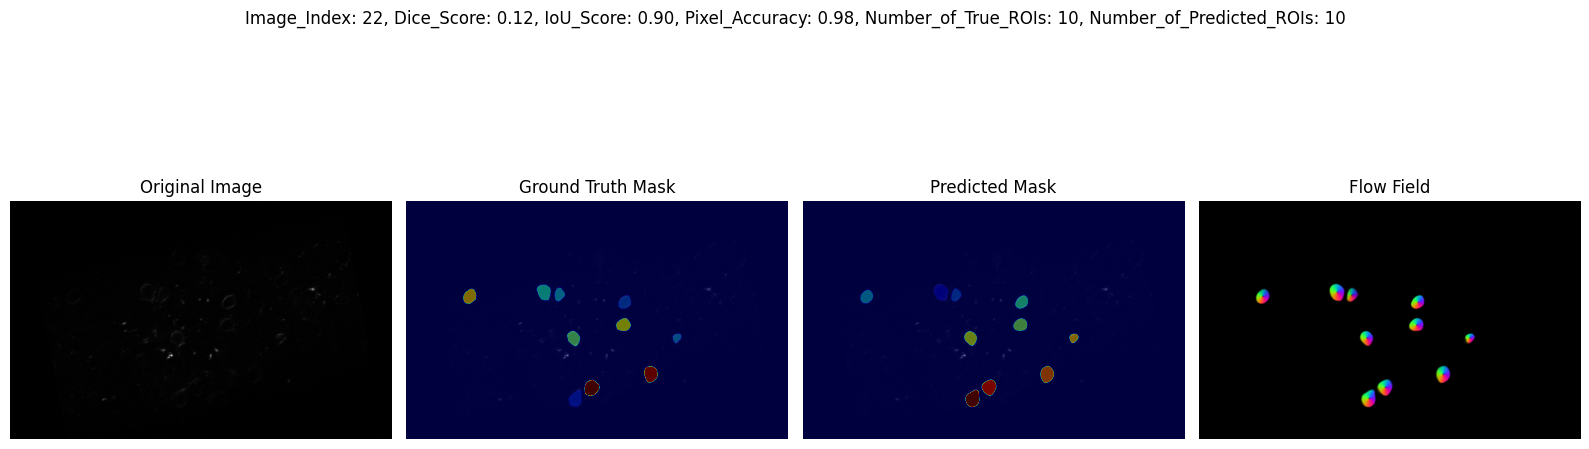

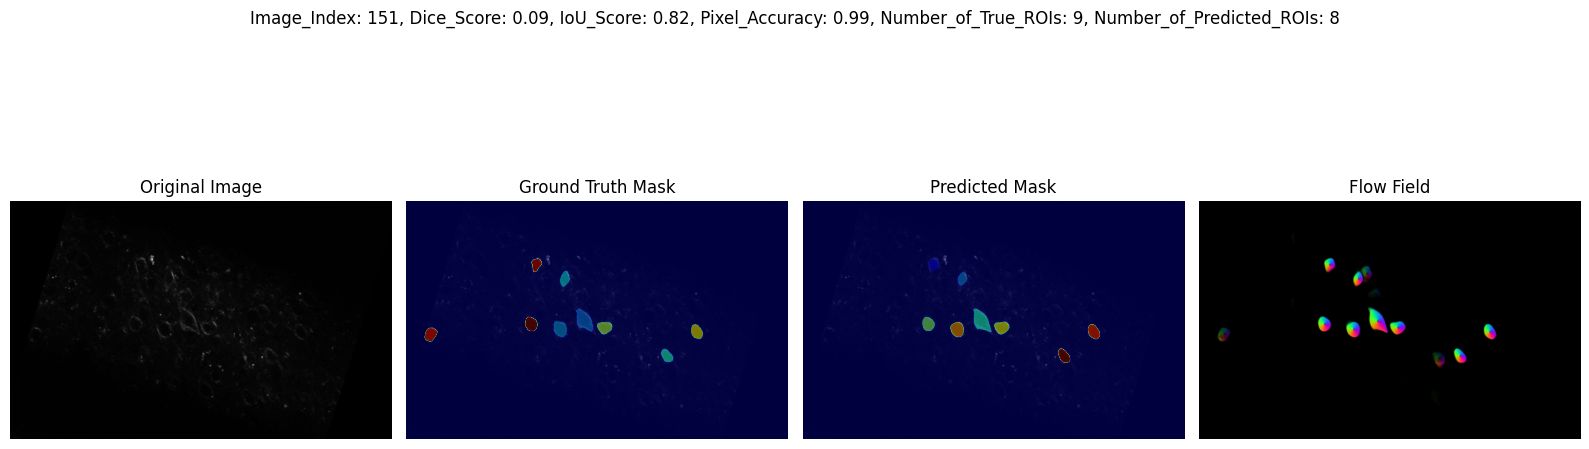

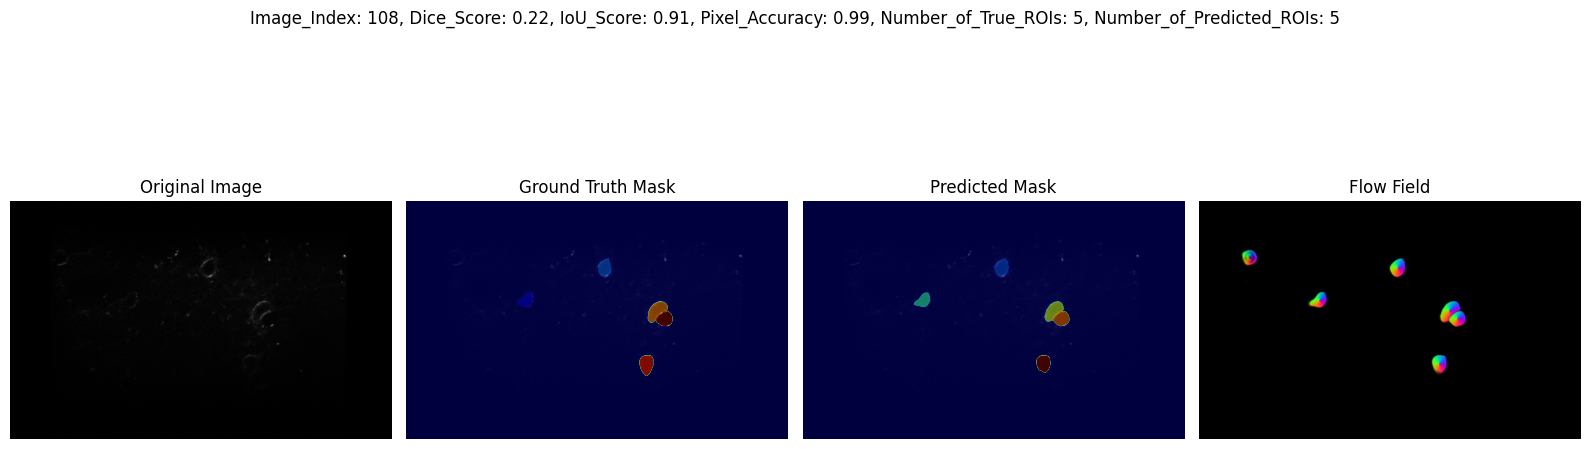

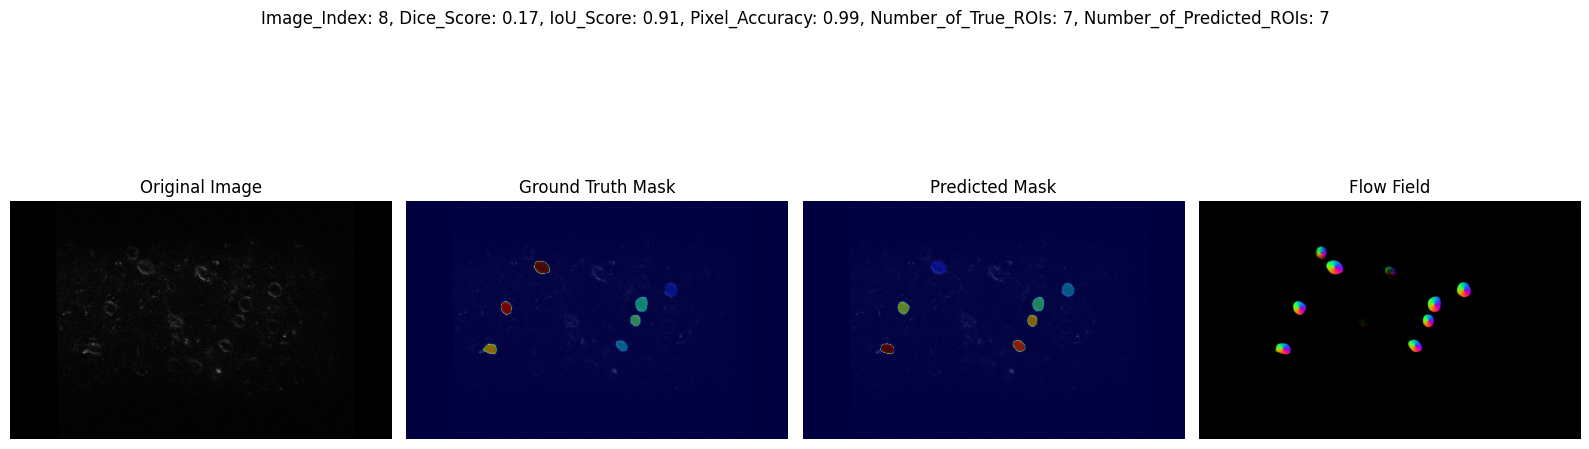

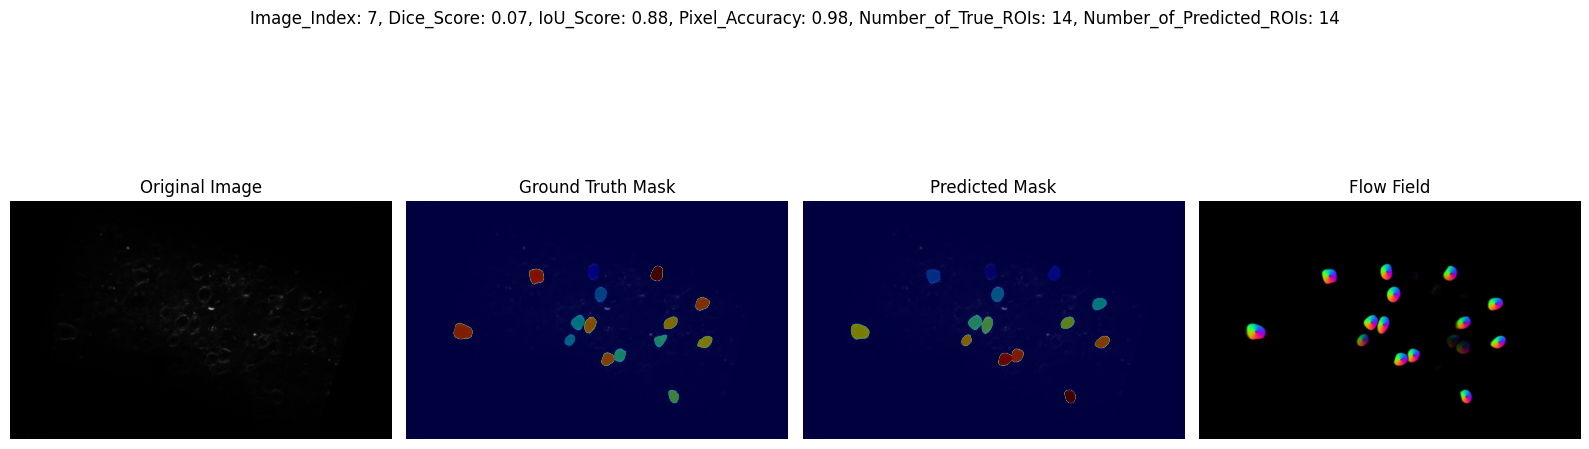

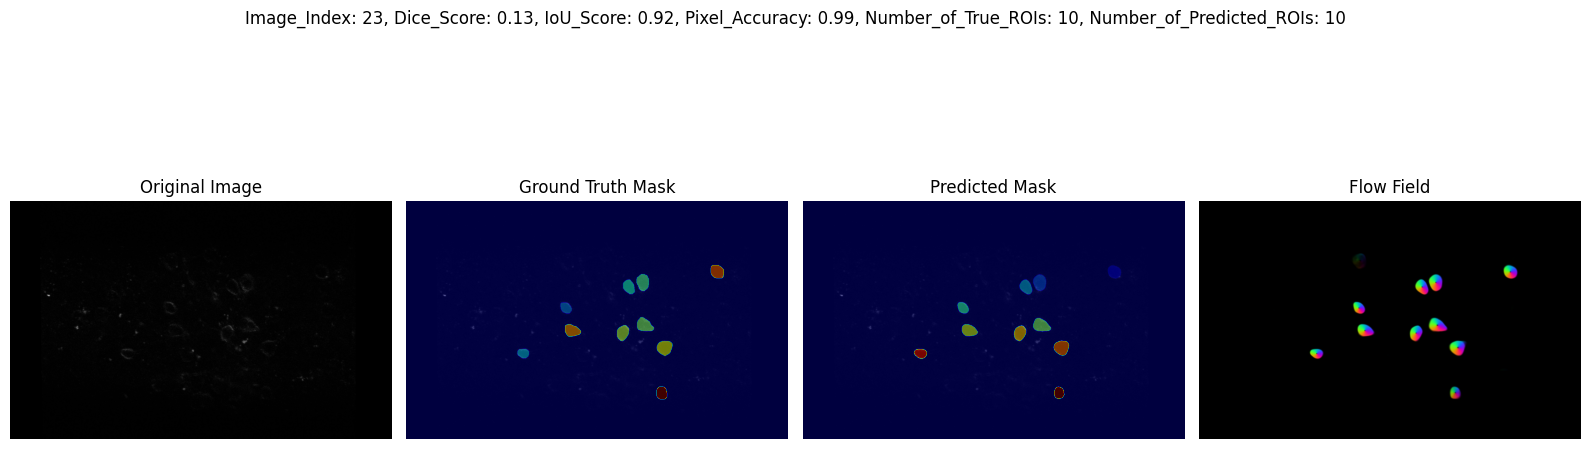

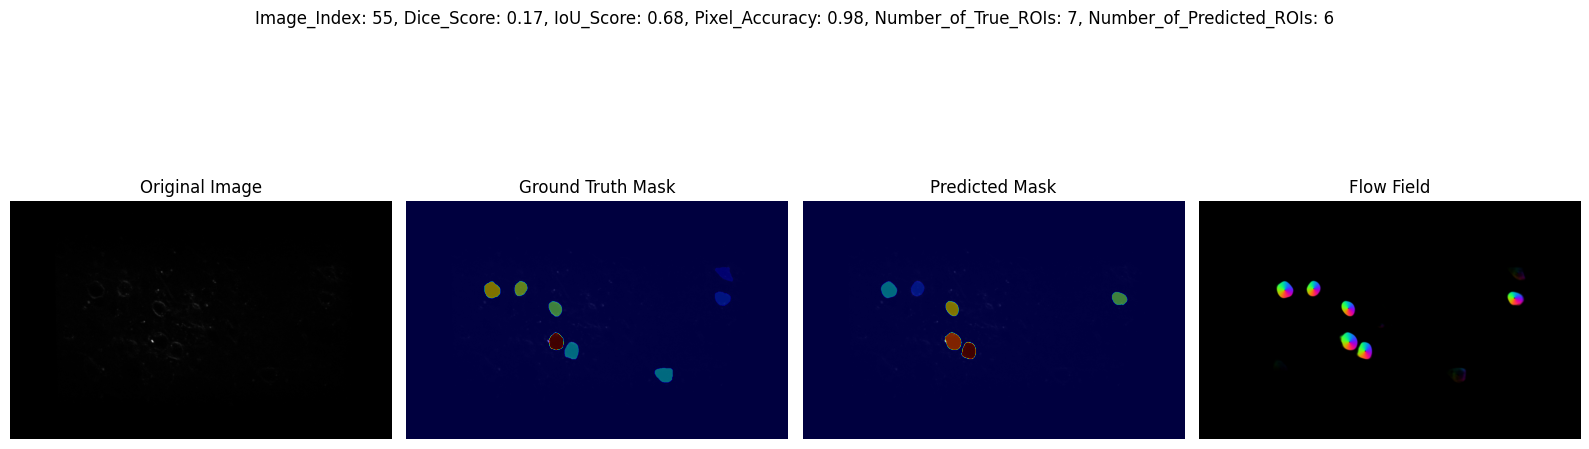

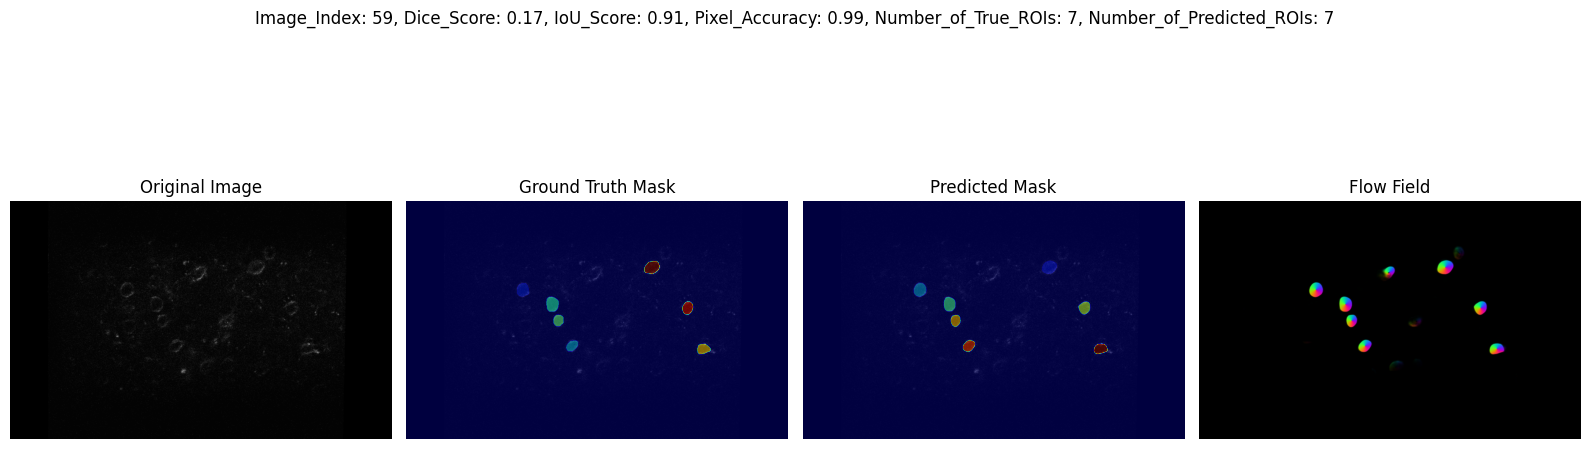

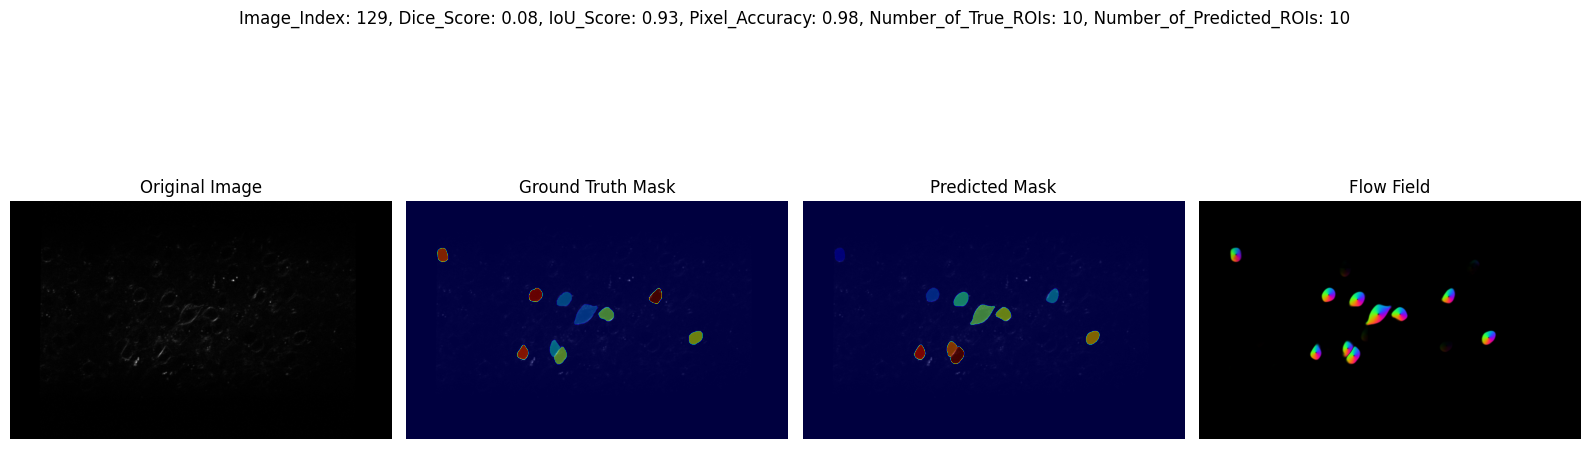

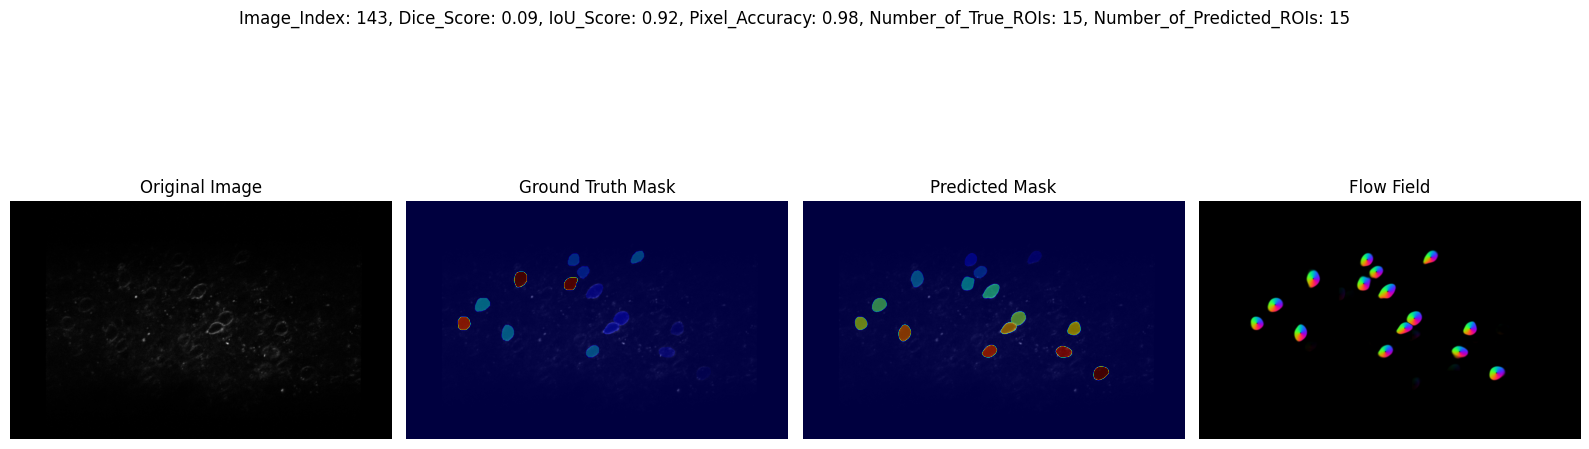

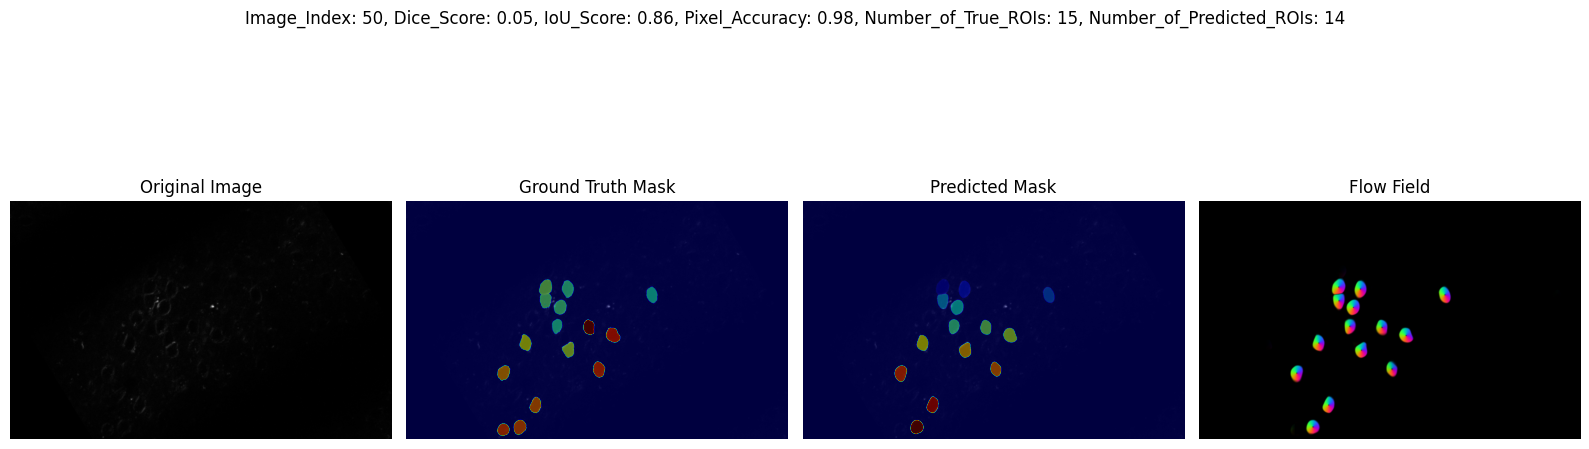

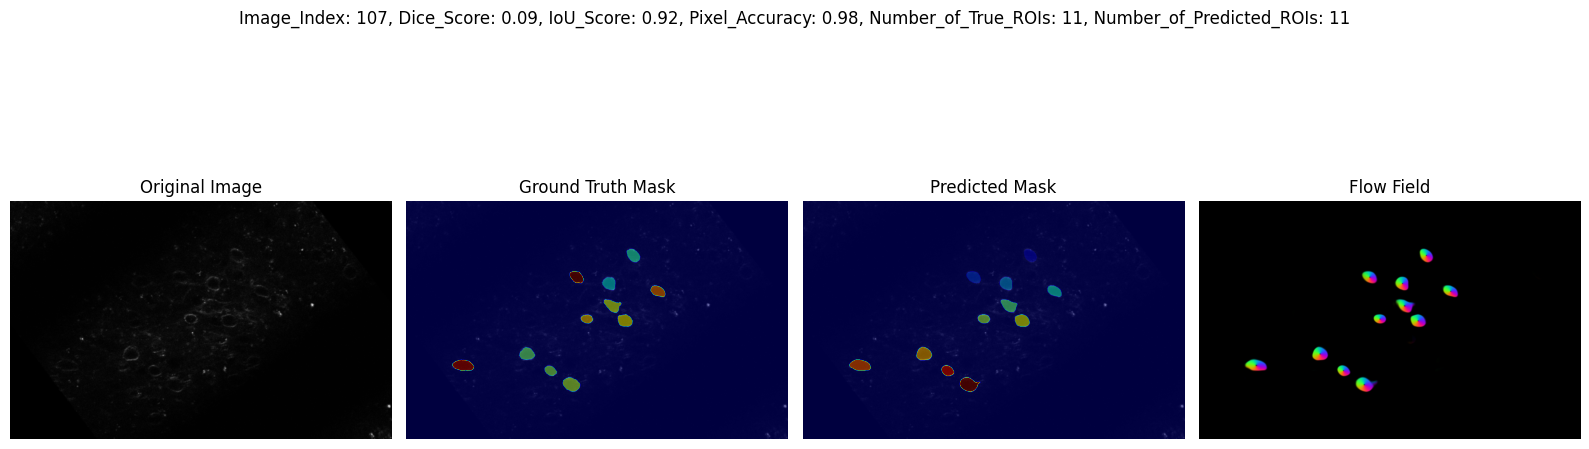

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Set a random seed for reproducibility
random.seed(42)

# Select 20 random indices from the test set
random_indices = random.sample(range(len(test_images)), 20)

# Loop through the selected random indices
for idx in random_indices:
    # Evaluate the model on the test image
    results = model.eval(test_images[idx], channels=[0, 0])
    if len(results) == 3:
        masks_pred, flows, styles = results
    else:
        masks_pred, flows, styles, diams = results

    # Calculate metrics
    metrics = calculate_metrics(test_masks[idx], masks_pred)

    # Construct the title with metrics
    title = (f"Image_Index: {idx}, "
             f"Dice_Score: {metrics['Dice Score']:.2f}, "
             f"IoU_Score: {metrics['IoU Score']:.2f}, "
             f"Pixel_Accuracy: {metrics['Pixel Accuracy']:.2f}, "
             f"Number_of_True_ROIs: {metrics['Number of True ROIs']}, "
             f"Number_of_Predicted_ROIs: {metrics['Number of Predicted ROIs']}")

    # Visualize results for the current test image
    fig, ax = plt.subplots(1, 4, figsize=(16, 6))
    fig.suptitle(title, fontsize=12)

    # Original image
    ax[0].imshow(test_images[idx], cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Ground truth mask 
    ax[1].imshow(test_images[idx], cmap='gray')
    ax[1].imshow(test_masks[idx], cmap='jet', alpha=0.5)
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Predicted mask
    ax[2].imshow(test_images[idx], cmap='gray')
    ax[2].imshow(masks_pred, cmap='jet', alpha=0.5)
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')

    # Flow visualization
    ax[3].imshow(flows[0], cmap='gray')
    ax[3].set_title('Flow Field')
    ax[3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

2024-10-06 22:07:10,375 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2024-10-06 22:07:10,375 [INFO] 
cellpose version: 	3.0.12.dev87+g52f75f9 
platform:       	linux 
python version: 	3.10.12 
torch version:  	2.1.0

Testing Cellpose model: cyto2_cp3
2024-10-06 22:07:18,852 [INFO] >> cyto2_cp3 << model set to be used
2024-10-06 22:07:18,853 [INFO] ** TORCH CUDA version installed and working. **
2024-10-06 22:07:18,853 [INFO] >>>> using GPU (CUDA)
2024-10-06 22:07:18,919 [INFO] >>>> loading model /root/.cellpose/models/cyto2_cp3
2024-10-06 22:07:18,994 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)

Testing with flow_threshold=0.4, cell_probability=0


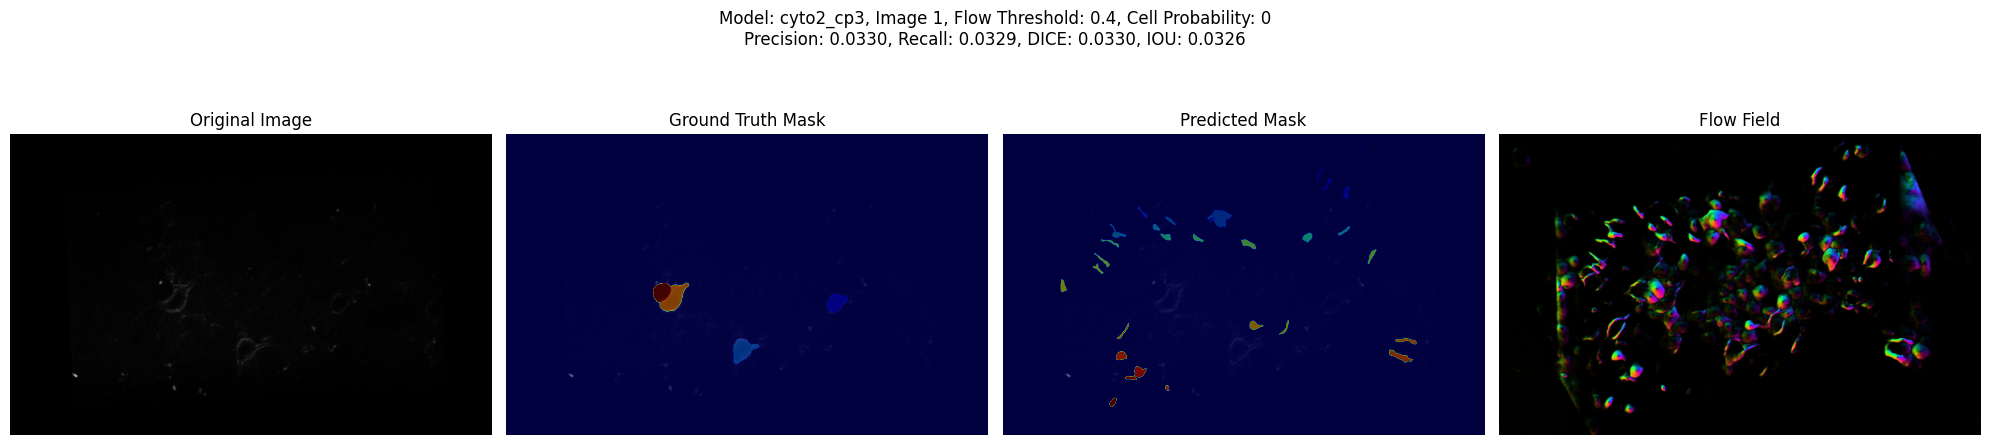

Model: cyto2_cp3, Image 1, Flow Threshold: 0.4, Cell Probability: 0 Metrics:
Precision: 0.0330
Recall: 0.0329
DICE Score: 0.0330
IOU Score: 0.0326

Predicted and evaluated 1 masks using cyto2_cp3 model with flow_threshold=0.4, cell_probability=0.

Testing with flow_threshold=0.4, cell_probability=1


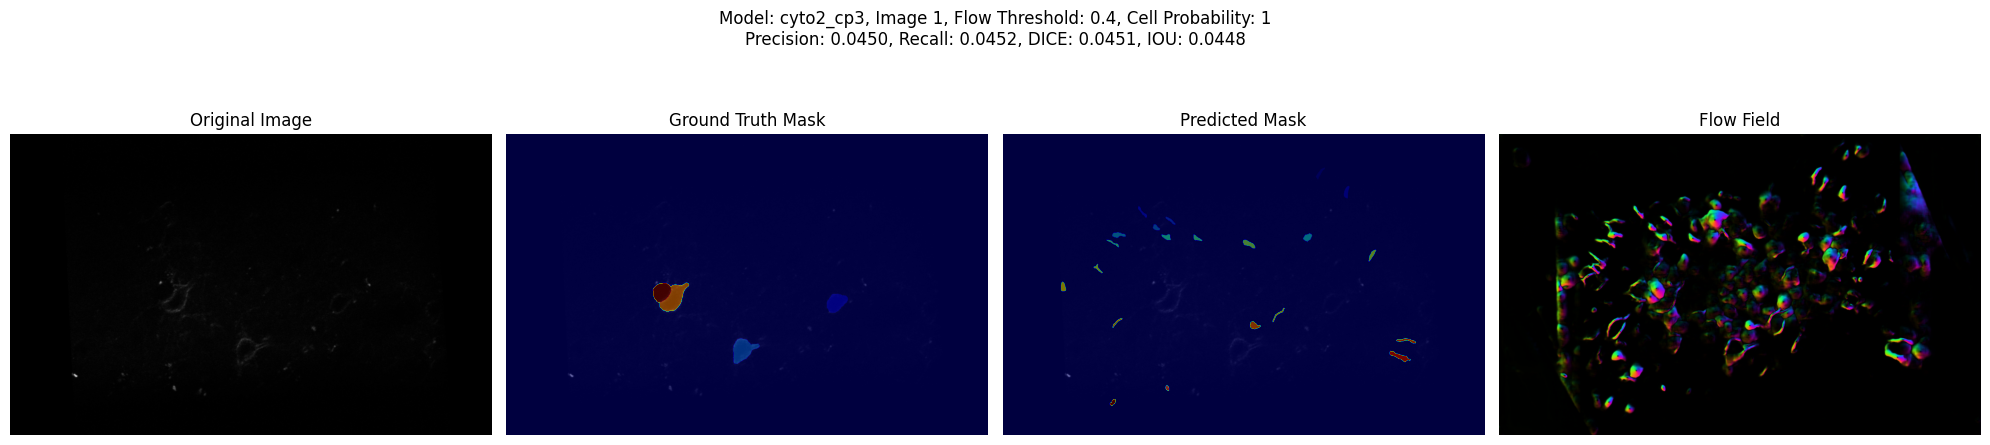

Model: cyto2_cp3, Image 1, Flow Threshold: 0.4, Cell Probability: 1 Metrics:
Precision: 0.0450
Recall: 0.0452
DICE Score: 0.0451
IOU Score: 0.0448

Predicted and evaluated 1 masks using cyto2_cp3 model with flow_threshold=0.4, cell_probability=1.

Testing with flow_threshold=0.4, cell_probability=2


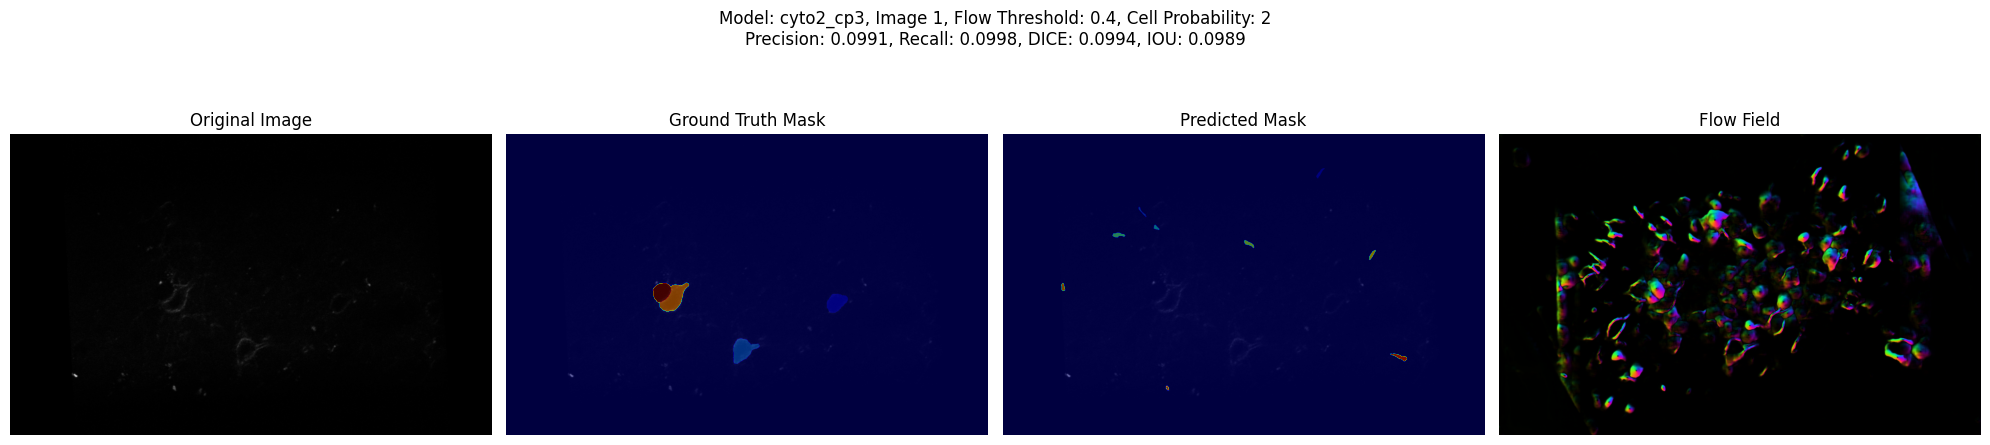

Model: cyto2_cp3, Image 1, Flow Threshold: 0.4, Cell Probability: 2 Metrics:
Precision: 0.0991
Recall: 0.0998
DICE Score: 0.0994
IOU Score: 0.0989

Predicted and evaluated 1 masks using cyto2_cp3 model with flow_threshold=0.4, cell_probability=2.

Testing with flow_threshold=0.5, cell_probability=0


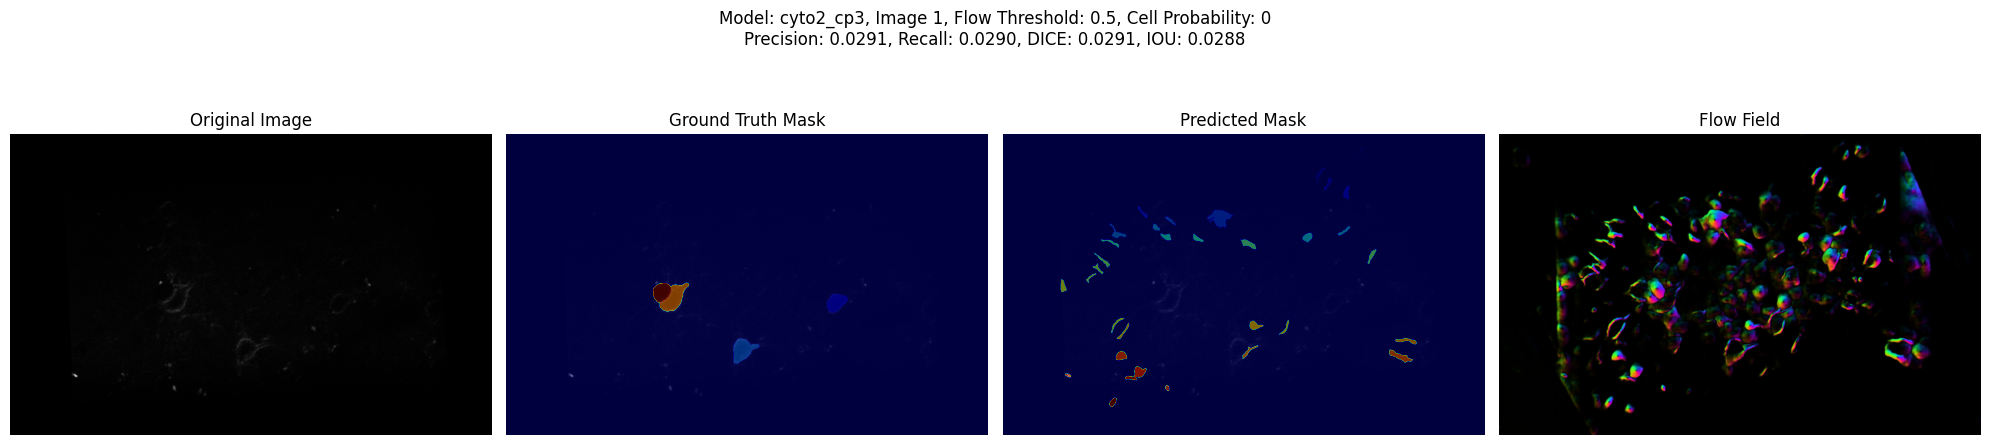

Model: cyto2_cp3, Image 1, Flow Threshold: 0.5, Cell Probability: 0 Metrics:
Precision: 0.0291
Recall: 0.0290
DICE Score: 0.0291
IOU Score: 0.0288

Predicted and evaluated 1 masks using cyto2_cp3 model with flow_threshold=0.5, cell_probability=0.

Testing with flow_threshold=0.5, cell_probability=1


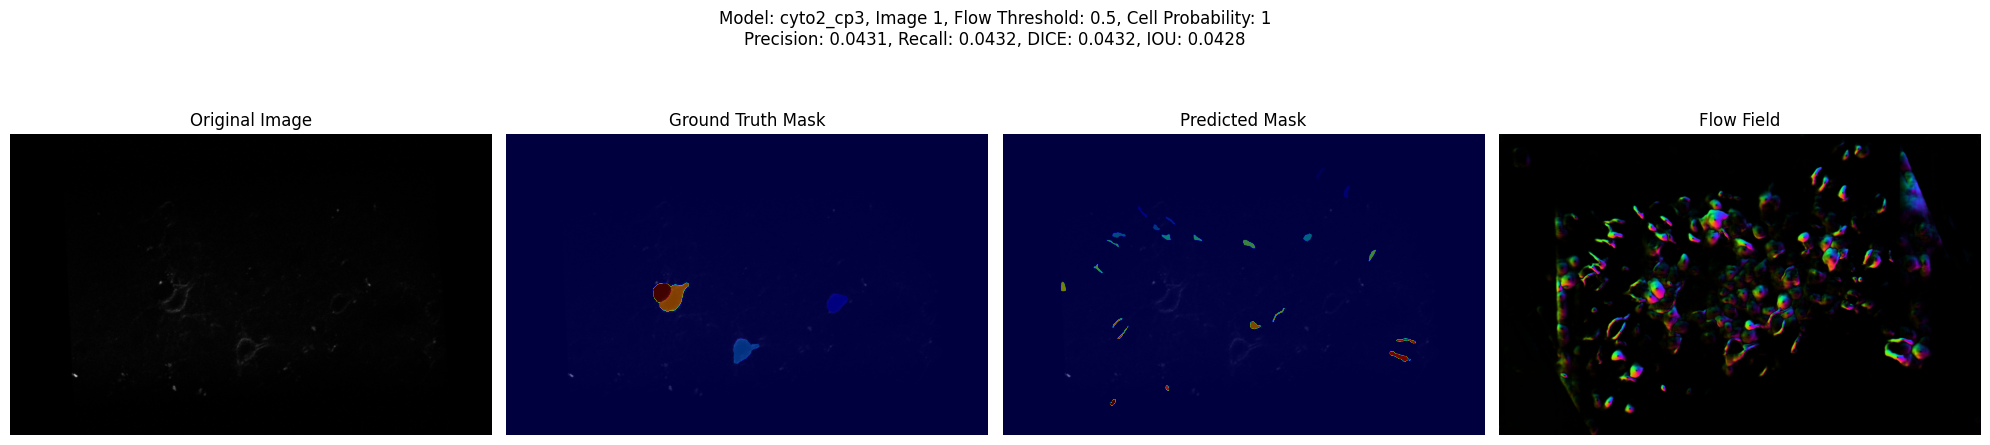

Model: cyto2_cp3, Image 1, Flow Threshold: 0.5, Cell Probability: 1 Metrics:
Precision: 0.0431
Recall: 0.0432
DICE Score: 0.0432
IOU Score: 0.0428

Predicted and evaluated 1 masks using cyto2_cp3 model with flow_threshold=0.5, cell_probability=1.

Testing with flow_threshold=0.5, cell_probability=2


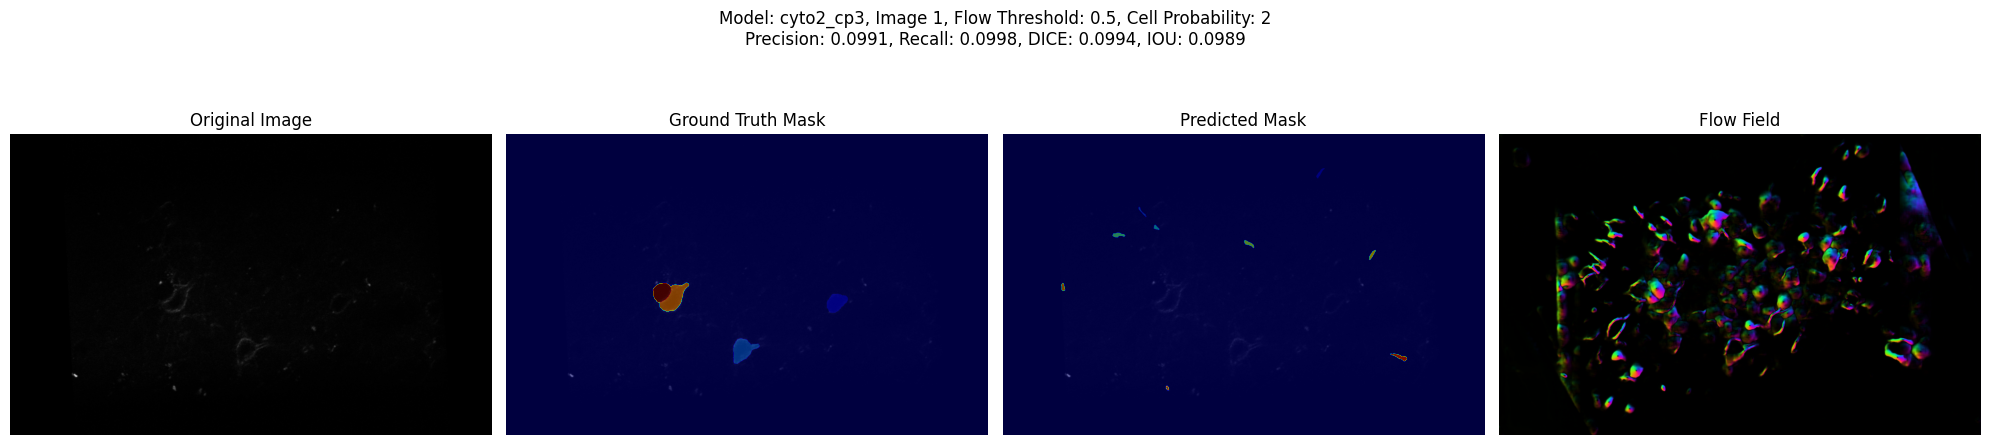

Model: cyto2_cp3, Image 1, Flow Threshold: 0.5, Cell Probability: 2 Metrics:
Precision: 0.0991
Recall: 0.0998
DICE Score: 0.0994
IOU Score: 0.0989

Predicted and evaluated 1 masks using cyto2_cp3 model with flow_threshold=0.5, cell_probability=2.

Testing with flow_threshold=0.6, cell_probability=0


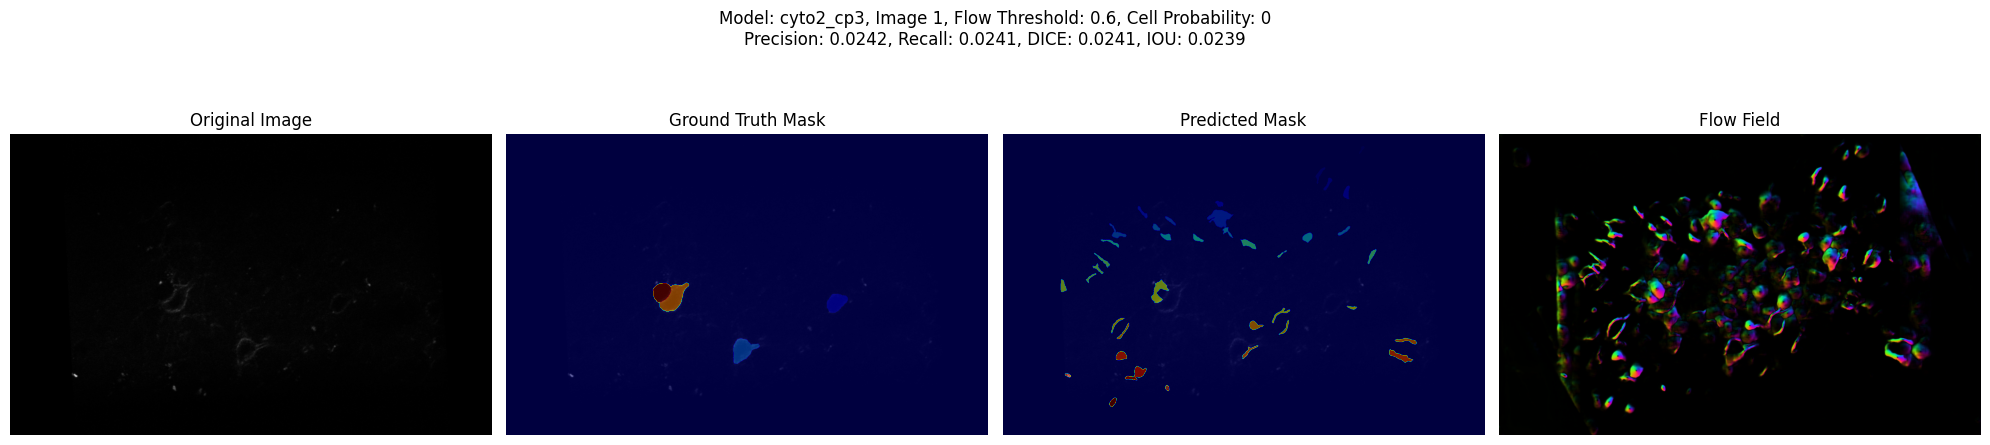

Model: cyto2_cp3, Image 1, Flow Threshold: 0.6, Cell Probability: 0 Metrics:
Precision: 0.0242
Recall: 0.0241
DICE Score: 0.0241
IOU Score: 0.0239

Predicted and evaluated 1 masks using cyto2_cp3 model with flow_threshold=0.6, cell_probability=0.

Testing with flow_threshold=0.6, cell_probability=1


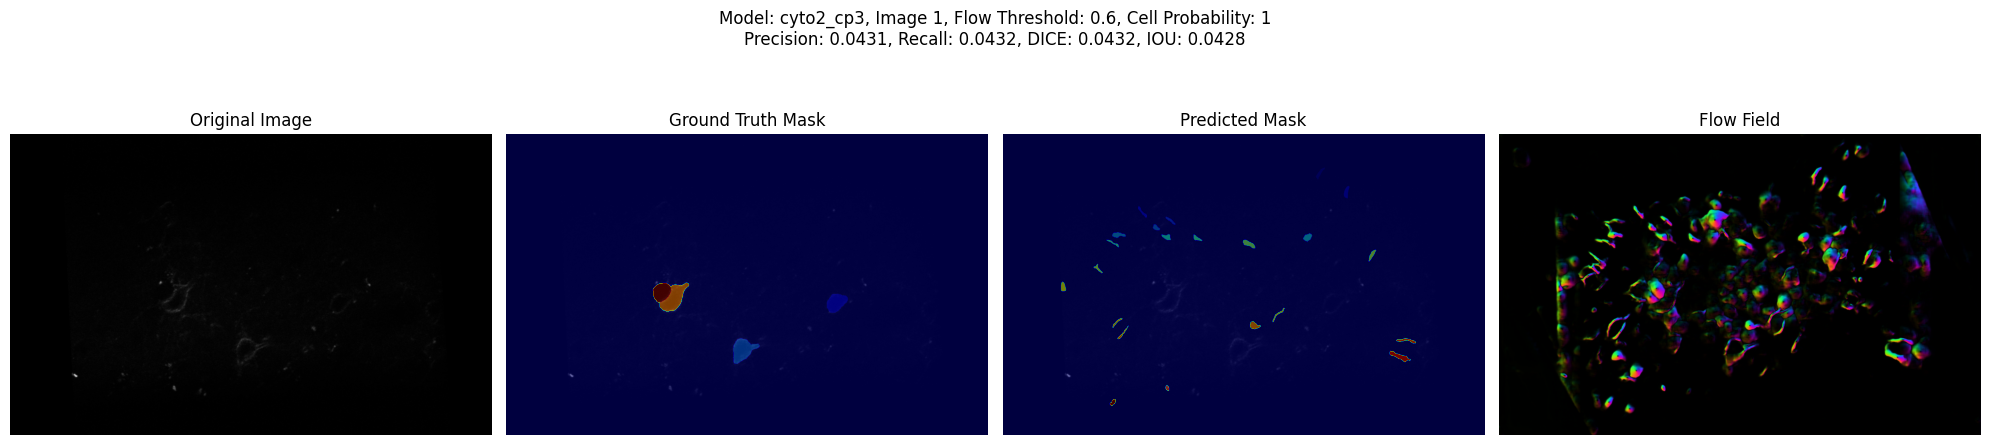

Model: cyto2_cp3, Image 1, Flow Threshold: 0.6, Cell Probability: 1 Metrics:
Precision: 0.0431
Recall: 0.0432
DICE Score: 0.0432
IOU Score: 0.0428

Predicted and evaluated 1 masks using cyto2_cp3 model with flow_threshold=0.6, cell_probability=1.

Testing with flow_threshold=0.6, cell_probability=2


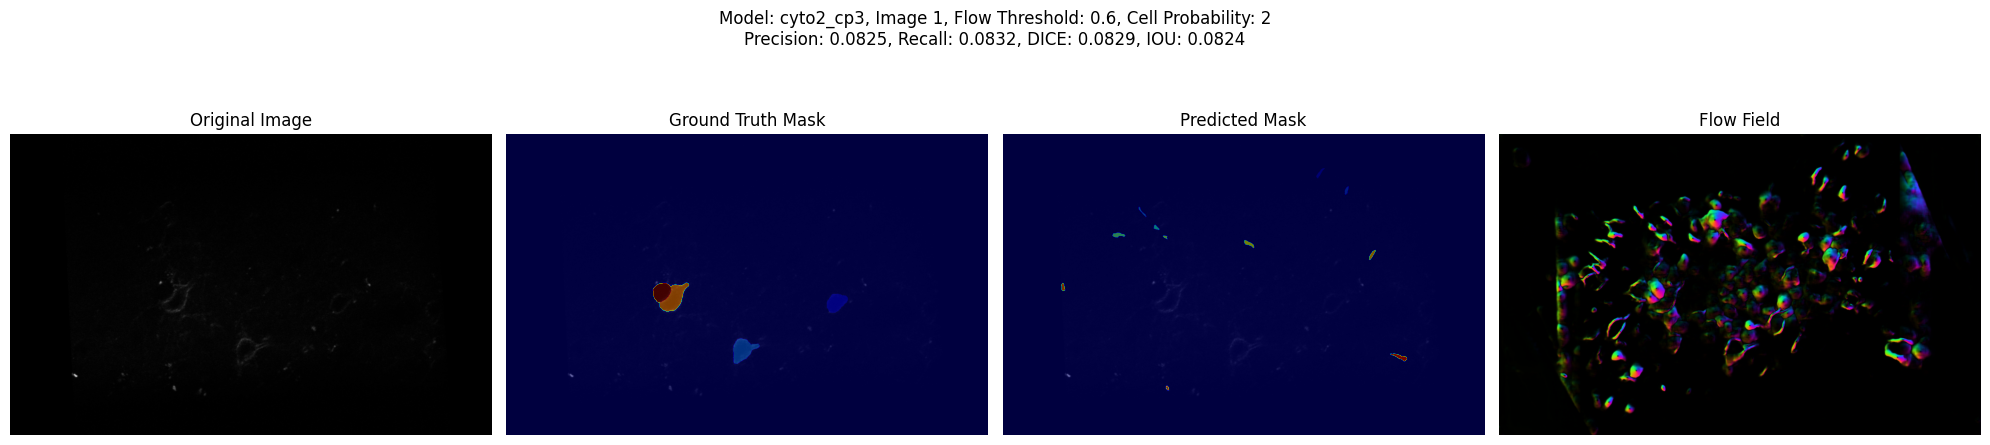

Model: cyto2_cp3, Image 1, Flow Threshold: 0.6, Cell Probability: 2 Metrics:
Precision: 0.0825
Recall: 0.0832
DICE Score: 0.0829
IOU Score: 0.0824

Predicted and evaluated 1 masks using cyto2_cp3 model with flow_threshold=0.6, cell_probability=2.
Finished testing all Cellpose models with different flow thresholds and cell probabilities.


In [7]:
# Import necessary libraries
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score


import albumentations as A
import os
import cv2
import numpy as np
import tifffile
from sklearn.model_selection import train_test_split
from cellpose import models, train, io
import matplotlib.pyplot as plt
from cellpose import plot
from cellpose import utils, io
# Import necessary libraries
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

io.logger_setup()  # Run this to get printing of progress

data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

assert len(image_files) == len(mask_files), "Number of images and masks must match."

images = [tifffile.imread(os.path.join(data_dir, img))[:, 1, :, :] for img in image_files]
masks_uint8 = [tifffile.imread(os.path.join(data_dir, msk)).astype(np.uint8) for msk in mask_files]

for img, msk in zip(images, masks_uint8):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

images = np.array(images).astype(np.float32) / 255.0

cell_probabilities = np.arange(-6, 7, 2)
flow_thresholds = np.arange(0.1, 3.1, 0.2)

# Function to predict masks from images using a specific model
def predict_masks(images, model, flow_threshold, cell_probability):
    # Ensure images is a list
    if not isinstance(images, list):
        images = [images]

    results = model.eval(images, diameter=None, channels=[0,0],
                                             flow_threshold=flow_threshold,
                                             cellprob_threshold=cell_probability)    
    # Predict masks
    if len(results) == 3:
                masks_pred, flows, styles = results
    else:
        masks_pred, flows, styles, diams = results

    
    return results

# Function to calculate evaluation metrics
def calculate_metrics(true_mask, pred_mask):
    true_mask = true_mask.flatten()
    pred_mask = pred_mask.flatten()
    
    precision = precision_score(true_mask, pred_mask, average='macro', zero_division=0)
    recall = recall_score(true_mask, pred_mask, average='macro', zero_division=0)
    dice = f1_score(true_mask, pred_mask, average='macro', zero_division=0)
    iou = jaccard_score(true_mask, pred_mask, average='macro', zero_division=0)
    
    return {
        'Precision': precision,
        'Recall': recall,
        'DICE Score': dice,
        'IOU Score': iou
    }


cellpose_models =     ["cyto2_cp3"]
# Example usage
# Assuming you have a list of images to predict and corresponding ground truth masks
images_to_predict = test_images[:5]  # Using the first 5 test images as an example
ground_truth_masks = test_masks[:5]  # Corresponding ground truth masks

# Iterate through all Cellpose models
for model_type in cellpose_models:
    print(f"\nTesting Cellpose model: {model_type}")
    
    # Load the model
    model = models.CellposeModel(gpu=True, model_type=model_type)
    
    # Iterate through flow thresholds and cell probabilities
    for flow_threshold in flow_thresholds:
        for cell_probability in cell_probabilities:
            print(f"\nTesting with flow_threshold={flow_threshold}, cell_probability={cell_probability}")
            
            # Predict masks
            predicted_masks, predicted_flows, predicted_styles = predict_masks(
                images_to_predict, model, flow_threshold, cell_probability)

            # Evaluate and visualize results
            for i, (image, true_mask, pred_mask, flow) in enumerate(zip(images_to_predict, ground_truth_masks, predicted_masks, predicted_flows)):
                # Calculate metrics
                metrics = calculate_metrics(true_mask, pred_mask)
                
                # Visualize results
                fig, ax = plt.subplots(1, 4, figsize=(20, 5))
                
                ax[0].imshow(image, cmap='gray')
                ax[0].set_title('Original Image')
                ax[0].axis('off')
                
                ax[1].imshow(image, cmap='gray')
                ax[1].imshow(true_mask, cmap='jet', alpha=0.5)
                ax[1].set_title('Ground Truth Mask')
                ax[1].axis('off')
                
                ax[2].imshow(image, cmap='gray')
                ax[2].imshow(pred_mask, cmap='jet', alpha=0.5)
                ax[2].set_title('Predicted Mask')
                ax[2].axis('off')
                
                ax[3].imshow(flow[0], cmap='gray')
                ax[3].set_title('Flow Field')
                ax[3].axis('off')
                
                plt.tight_layout()
                
                # Add metrics to the plot
                plt.suptitle(f"Model: {model_type}, Image {i+1}, Flow Threshold: {flow_threshold}, Cell Probability: {cell_probability}\n"
                             f"Precision: {metrics['Precision']:.4f}, Recall: {metrics['Recall']:.4f}, "
                             f"DICE: {metrics['DICE Score']:.4f}, IOU: {metrics['IOU Score']:.4f}", 
                             fontsize=12, y=1.05)
                
                plt.show()

                print(f"Model: {model_type}, Image {i+1}, Flow Threshold: {flow_threshold}, Cell Probability: {cell_probability} Metrics:")
                for metric, value in metrics.items():
                    print(f"{metric}: {value:.4f}")
                print()

            print(f"Predicted and evaluated {len(predicted_masks)} masks using {model_type} model "
                  f"with flow_threshold={flow_threshold}, cell_probability={cell_probability}.")

print("Finished testing all Cellpose models with different flow thresholds and cell probabilities.")





Testing Cellpose model: cyto
2024-10-06 22:17:35,116 [INFO] ** TORCH CUDA version installed and working. **
2024-10-06 22:17:35,117 [INFO] >>>> using GPU (CUDA)
2024-10-06 22:17:35,117 [INFO] >> cyto << model set to be used
2024-10-06 22:17:35,181 [INFO] >>>> loading model /root/.cellpose/models/cytotorch_0
2024-10-06 22:17:35,260 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)

Testing with flow_threshold=0.1, cell_probability=-6
2024-10-06 22:17:35,263 [INFO] channels set to [0, 0]
2024-10-06 22:17:35,264 [WARNING] could not estimate diameter, does not work on non-2D images
2024-10-06 22:17:35,264 [INFO] ~~~ FINDING MASKS ~~~
2024-10-06 22:17:35,265 [INFO] multi-stack tiff read in as having 21 planes 5 channels
2024-10-06 22:17:44,553 [INFO] 100%|##########| 21/21 [00:08<00:00,  2.57it/s]
2024-10-06 22:17:44,862 [INFO] network run in 9.38s
2024-10-06 22:18:03,450 [INFO] 100%|##########| 21/21 [00:18<00:00,  1.13it/s]
2024-10-06 22:18:03,493 [WARNIN

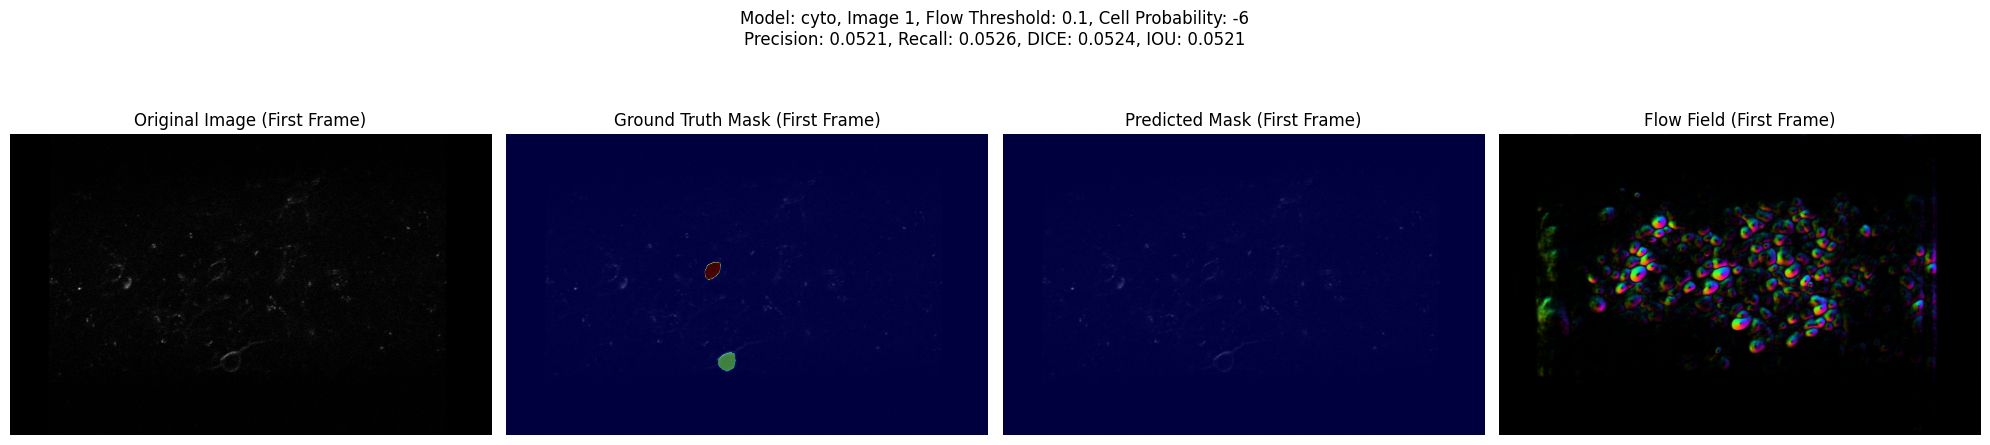

Model: cyto, Image 1, Flow Threshold: 0.1, Cell Probability: -6 Metrics:
Precision: 0.0521
Recall: 0.0526
DICE Score: 0.0524
IOU Score: 0.0521

Predicted and evaluated 1 masks using cyto model with flow_threshold=0.1, cell_probability=-6.

Testing with flow_threshold=0.1, cell_probability=-4
2024-10-06 22:18:23,289 [INFO] channels set to [0, 0]
2024-10-06 22:18:23,290 [WARNING] could not estimate diameter, does not work on non-2D images
2024-10-06 22:18:23,290 [INFO] ~~~ FINDING MASKS ~~~
2024-10-06 22:18:23,291 [INFO] multi-stack tiff read in as having 21 planes 5 channels
2024-10-06 22:18:32,524 [INFO] 100%|##########| 21/21 [00:08<00:00,  2.58it/s]
2024-10-06 22:18:32,832 [INFO] network run in 9.32s
2024-10-06 22:18:49,146 [INFO] 100%|##########| 21/21 [00:16<00:00,  1.29it/s]
2024-10-06 22:18:49,189 [WARNING] 3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
2024-10-06 22:18:49,189 [INFO] masks created in 16.36s
2024-10-06 22:18:50,174 [INFO] >

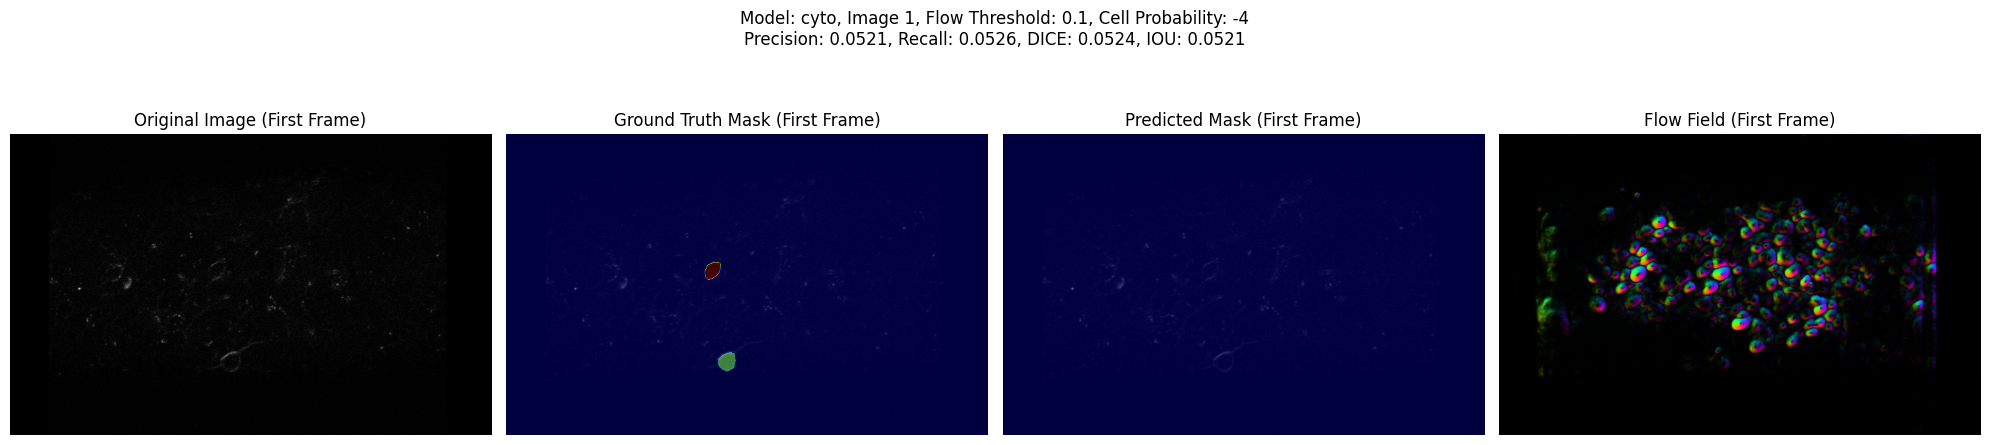

Model: cyto, Image 1, Flow Threshold: 0.1, Cell Probability: -4 Metrics:
Precision: 0.0521
Recall: 0.0526
DICE Score: 0.0524
IOU Score: 0.0521

Predicted and evaluated 1 masks using cyto model with flow_threshold=0.1, cell_probability=-4.

Testing with flow_threshold=0.1, cell_probability=-2
2024-10-06 22:19:08,965 [INFO] channels set to [0, 0]
2024-10-06 22:19:08,965 [WARNING] could not estimate diameter, does not work on non-2D images
2024-10-06 22:19:08,966 [INFO] ~~~ FINDING MASKS ~~~
2024-10-06 22:19:08,966 [INFO] multi-stack tiff read in as having 21 planes 5 channels
2024-10-06 22:19:18,202 [INFO] 100%|##########| 21/21 [00:08<00:00,  2.58it/s]
2024-10-06 22:19:18,509 [INFO] network run in 9.32s
2024-10-06 22:19:28,478 [INFO] 100%|##########| 21/21 [00:09<00:00,  2.11it/s]
2024-10-06 22:19:28,521 [WARNING] 3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
2024-10-06 22:19:28,521 [INFO] masks created in 10.01s
2024-10-06 22:19:29,519 [INFO] >

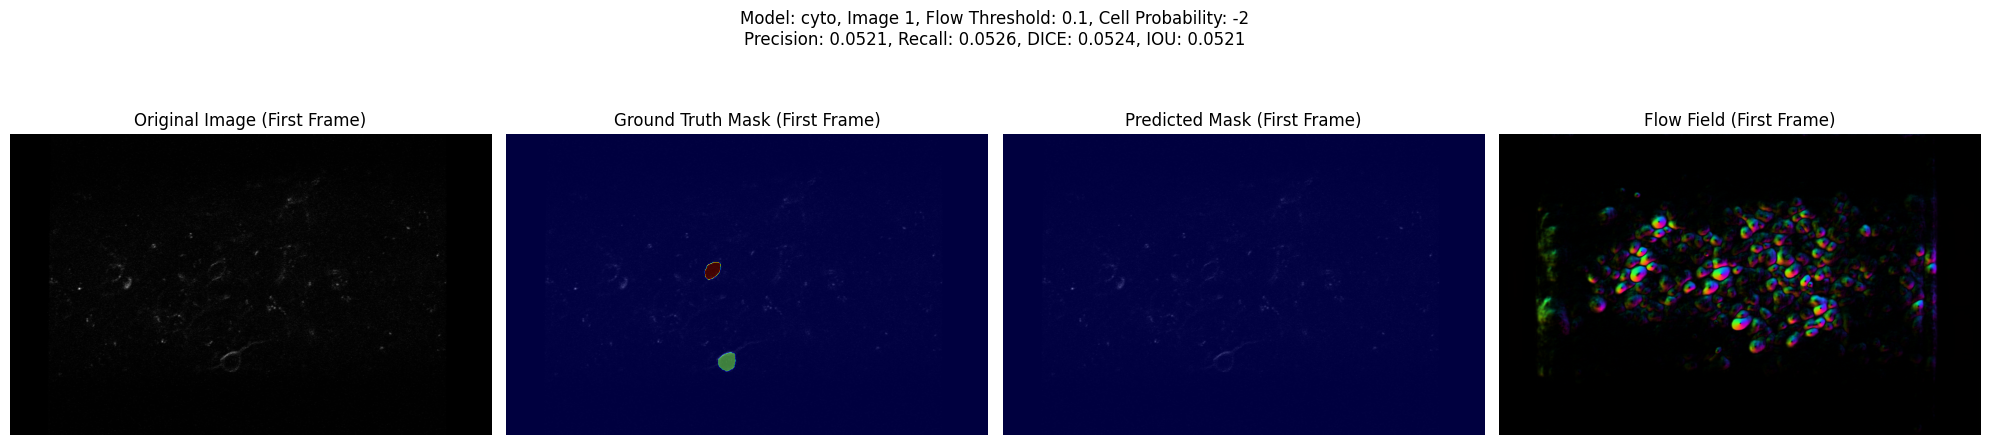

Model: cyto, Image 1, Flow Threshold: 0.1, Cell Probability: -2 Metrics:
Precision: 0.0521
Recall: 0.0526
DICE Score: 0.0524
IOU Score: 0.0521

Predicted and evaluated 1 masks using cyto model with flow_threshold=0.1, cell_probability=-2.

Testing with flow_threshold=0.1, cell_probability=0
2024-10-06 22:19:48,333 [INFO] channels set to [0, 0]
2024-10-06 22:19:48,334 [WARNING] could not estimate diameter, does not work on non-2D images
2024-10-06 22:19:48,334 [INFO] ~~~ FINDING MASKS ~~~
2024-10-06 22:19:48,335 [INFO] multi-stack tiff read in as having 21 planes 5 channels
2024-10-06 22:19:57,588 [INFO] 100%|##########| 21/21 [00:08<00:00,  2.57it/s]
2024-10-06 22:19:57,894 [INFO] network run in 9.34s
2024-10-06 22:20:02,999 [INFO] 100%|##########| 21/21 [00:05<00:00,  4.11it/s]
2024-10-06 22:20:03,042 [WARNING] 3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
2024-10-06 22:20:03,043 [INFO] masks created in 5.15s
2024-10-06 22:20:04,028 [INFO] >>>

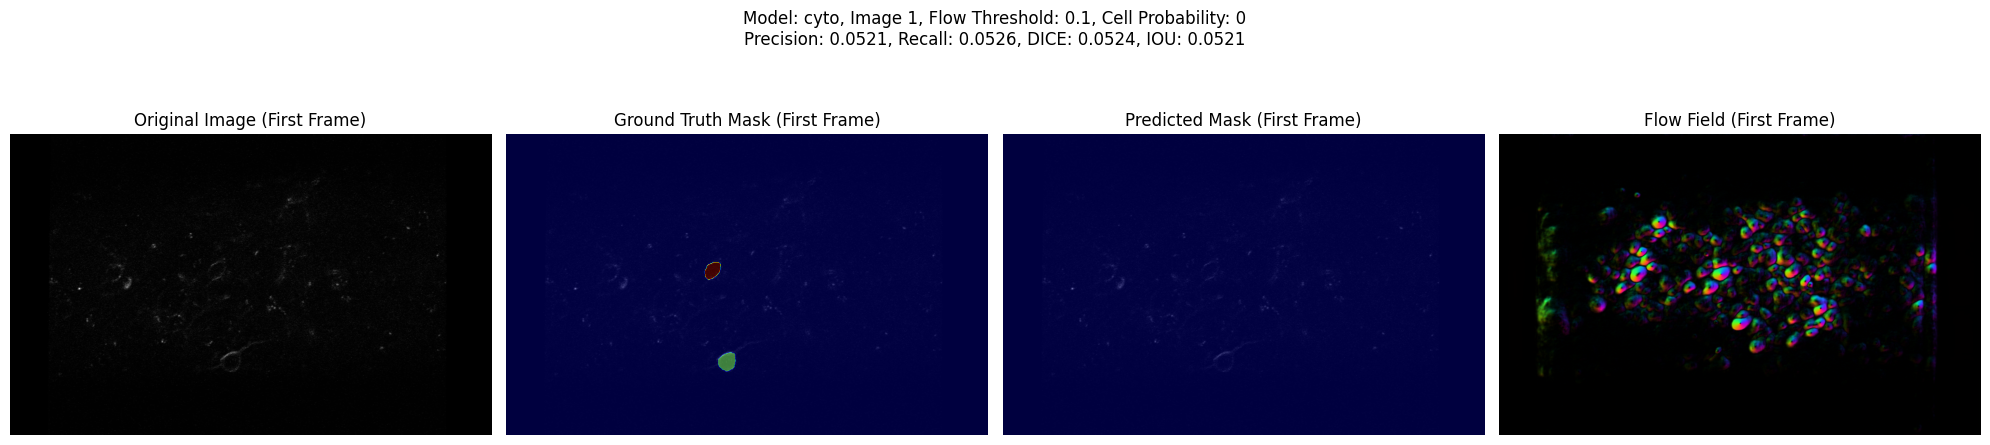

Model: cyto, Image 1, Flow Threshold: 0.1, Cell Probability: 0 Metrics:
Precision: 0.0521
Recall: 0.0526
DICE Score: 0.0524
IOU Score: 0.0521

Predicted and evaluated 1 masks using cyto model with flow_threshold=0.1, cell_probability=0.

Testing with flow_threshold=0.1, cell_probability=2
2024-10-06 22:20:22,769 [INFO] channels set to [0, 0]
2024-10-06 22:20:22,769 [WARNING] could not estimate diameter, does not work on non-2D images
2024-10-06 22:20:22,770 [INFO] ~~~ FINDING MASKS ~~~
2024-10-06 22:20:22,770 [INFO] multi-stack tiff read in as having 21 planes 5 channels
2024-10-06 22:20:32,024 [INFO] 100%|##########| 21/21 [00:08<00:00,  2.57it/s]
2024-10-06 22:20:32,333 [INFO] network run in 9.34s
2024-10-06 22:20:36,724 [INFO] 100%|##########| 21/21 [00:04<00:00,  4.78it/s]
2024-10-06 22:20:36,767 [WARNING] 3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
2024-10-06 22:20:36,767 [INFO] masks created in 4.43s
2024-10-06 22:20:37,760 [INFO] >>>> 

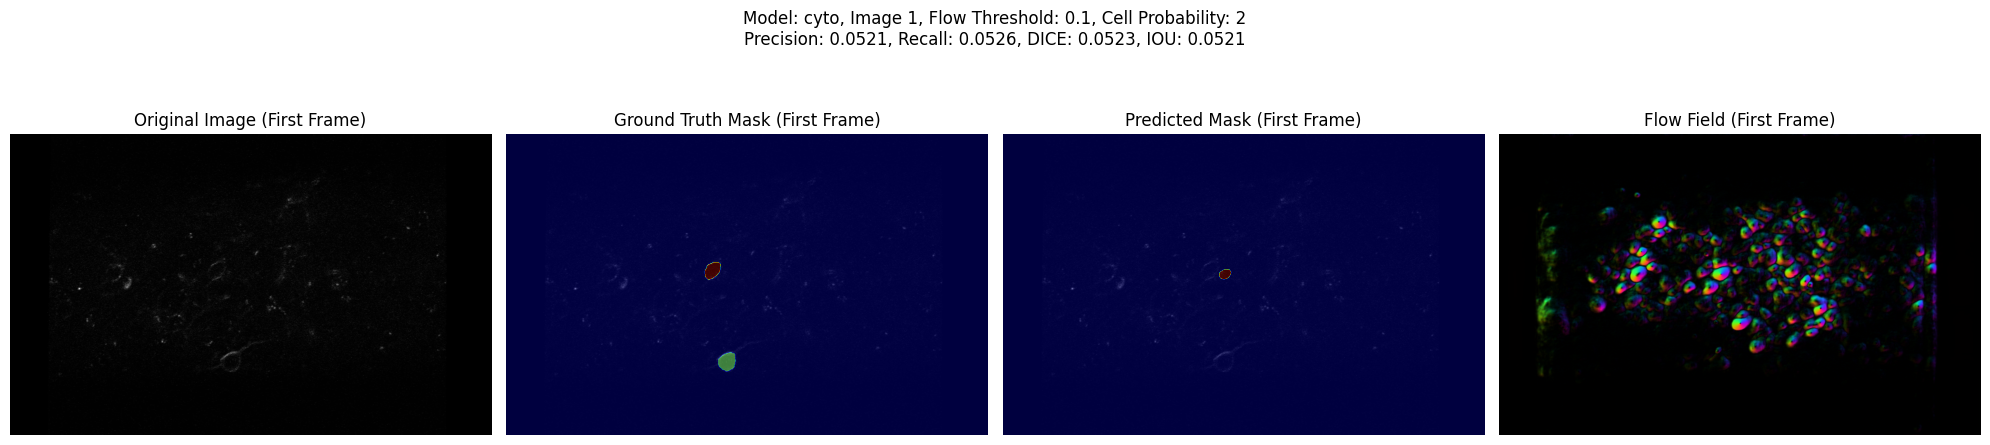

Model: cyto, Image 1, Flow Threshold: 0.1, Cell Probability: 2 Metrics:
Precision: 0.0521
Recall: 0.0526
DICE Score: 0.0523
IOU Score: 0.0521

Predicted and evaluated 1 masks using cyto model with flow_threshold=0.1, cell_probability=2.

Testing with flow_threshold=0.1, cell_probability=4
2024-10-06 22:20:56,615 [INFO] channels set to [0, 0]
2024-10-06 22:20:56,615 [WARNING] could not estimate diameter, does not work on non-2D images
2024-10-06 22:20:56,616 [INFO] ~~~ FINDING MASKS ~~~
2024-10-06 22:20:56,616 [INFO] multi-stack tiff read in as having 21 planes 5 channels
2024-10-06 22:21:05,878 [INFO] 100%|##########| 21/21 [00:08<00:00,  2.57it/s]
2024-10-06 22:21:06,185 [INFO] network run in 9.35s
2024-10-06 22:21:06,186 [INFO] 0%|          | 0/21 [00:00<?, ?it/s]
2024-10-06 22:21:07,537 [INFO] No cell pixels found.
2024-10-06 22:21:09,962 [INFO] 100%|##########| 21/21 [00:03<00:00,  5.56it/s]
2024-10-06 22:21:10,004 [WARNING] 3D stack used, but stitch_threshold=0 and do_3D=False, so

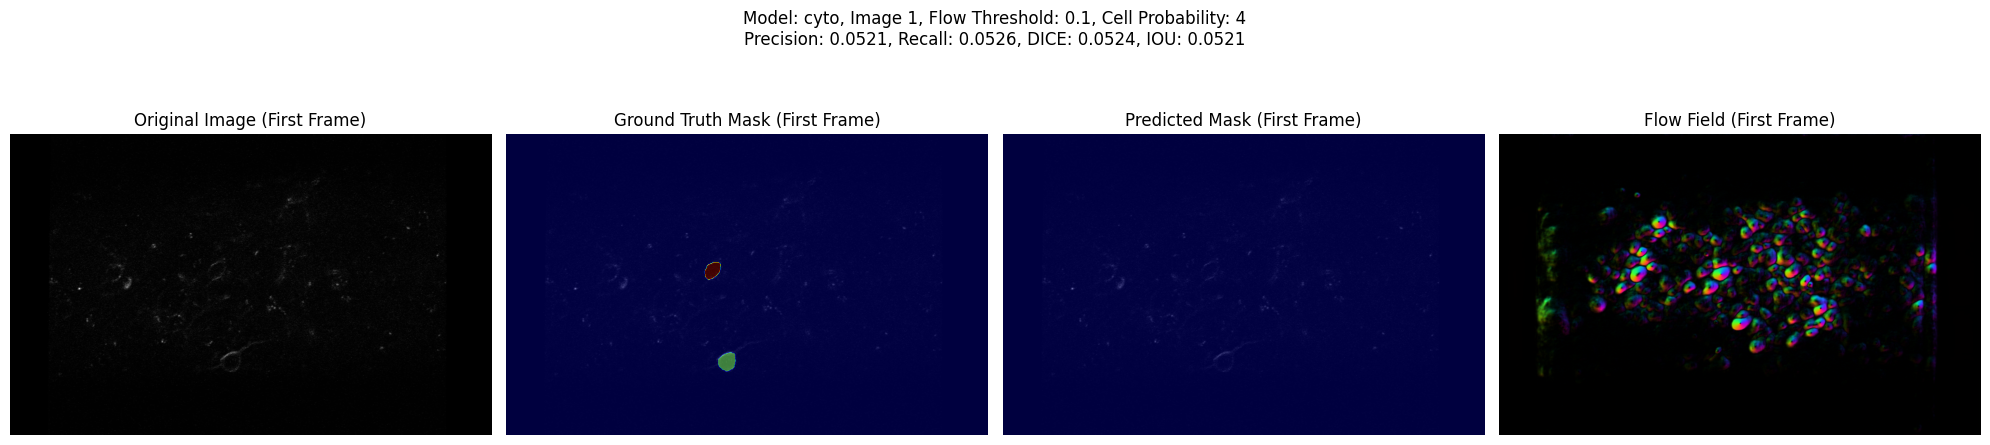

Model: cyto, Image 1, Flow Threshold: 0.1, Cell Probability: 4 Metrics:
Precision: 0.0521
Recall: 0.0526
DICE Score: 0.0524
IOU Score: 0.0521

Predicted and evaluated 1 masks using cyto model with flow_threshold=0.1, cell_probability=4.

Testing with flow_threshold=0.1, cell_probability=6
2024-10-06 22:21:29,888 [INFO] channels set to [0, 0]
2024-10-06 22:21:29,889 [WARNING] could not estimate diameter, does not work on non-2D images
2024-10-06 22:21:29,890 [INFO] ~~~ FINDING MASKS ~~~
2024-10-06 22:21:29,890 [INFO] multi-stack tiff read in as having 21 planes 5 channels
2024-10-06 22:21:39,164 [INFO] 100%|##########| 21/21 [00:08<00:00,  2.57it/s]
2024-10-06 22:21:39,471 [INFO] network run in 9.36s
2024-10-06 22:21:39,472 [INFO] 0%|          | 0/21 [00:00<?, ?it/s]
2024-10-06 22:21:39,474 [INFO] No cell pixels found.
2024-10-06 22:21:39,626 [INFO] No cell pixels found.
2024-10-06 22:21:39,793 [WARNING] WARNING: no mask pixels found
2024-10-06 22:21:39,793 [INFO] No cell pixels found.


In [10]:
# Import necessary libraries
import os
import tifffile
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Define data directory and load images and masks
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

assert len(image_files) == len(mask_files), "Number of images and masks must match."

images = [tifffile.imread(os.path.join(data_dir, img))[:, 1, :, :] for img in image_files]
masks_uint8 = [tifffile.imread(os.path.join(data_dir, msk)).astype(np.uint8) for msk in mask_files]

for img, msk in zip(images, masks_uint8):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

images = np.array(images).astype(np.float32) / 255.0

# Define a list of all Cellpose models to test
cellpose_models = ['cyto', 'cyto2', 'nuclei', 'tissuenet', 'livecell', 'cyto2_cp']

# Define ranges for flow threshold and cell probability
cell_probabilities = np.arange(-6, 7, 2)
flow_thresholds = np.arange(0.1, 3.1, 0.2)

# Function to predict masks from images using a specific model
def predict_masks(images, model, flow_threshold, cell_probability):
    # Ensure images is a list
    if not isinstance(images, list):
        images = [images]
    
    # Predict masks
    masks, flows, styles, diams = model.eval(images, diameter=None, channels=[0,0],
                                             flow_threshold=flow_threshold,
                                             cellprob_threshold=cell_probability)
    
    return masks, flows, styles, diams

# Function to calculate evaluation metrics
def calculate_metrics(true_mask, pred_mask):
    true_mask = true_mask.flatten()
    pred_mask = pred_mask.flatten()
    
    precision = precision_score(true_mask, pred_mask, average='macro', zero_division=0)
    recall = recall_score(true_mask, pred_mask, average='macro', zero_division=0)
    dice = f1_score(true_mask, pred_mask, average='macro', zero_division=0)
    iou = jaccard_score(true_mask, pred_mask, average='macro', zero_division=0)
    
    return {
        'Precision': precision,
        'Recall': recall,
        'DICE Score': dice,
        'IOU Score': iou
    }

# Example usage
# Using the first 5 images and masks for testing
images_to_predict = images[:5]
ground_truth_masks = masks_uint8[:5]

# Iterate through all Cellpose models
for model_type in cellpose_models:
    print(f"\nTesting Cellpose model: {model_type}")
    
    # Load the model
    model = models.Cellpose(gpu=True, model_type=model_type)
    
    for flow_threshold in flow_thresholds:
        for cell_probability in cell_probabilities:
            print(f"\nTesting with flow_threshold={flow_threshold}, cell_probability={cell_probability}")
            
            # Predict masks
            predicted_masks, predicted_flows, predicted_styles, predicted_diams = predict_masks(
                images_to_predict, model, flow_threshold, cell_probability)

            # Evaluate and visualize results
            for i, (image, true_mask, pred_mask, flow) in enumerate(zip(images_to_predict, ground_truth_masks, predicted_masks, predicted_flows)):
                # Calculate metrics
                metrics = calculate_metrics(true_mask, pred_mask)
                
                # Visualize results
                fig, ax = plt.subplots(1, 4, figsize=(20, 5))
                
                # Display the first frame of the image
                ax[0].imshow(image[0], cmap='gray')
                ax[0].set_title('Original Image (First Frame)')
                ax[0].axis('off')
                
                # Display the first frame of the ground truth mask
                ax[1].imshow(image[0], cmap='gray')
                ax[1].imshow(true_mask[0], cmap='jet', alpha=0.5)
                ax[1].set_title('Ground Truth Mask (First Frame)')
                ax[1].axis('off')
                
                # Display the first frame of the predicted mask
                ax[2].imshow(image[0], cmap='gray')
                ax[2].imshow(pred_mask[0], cmap='jet', alpha=0.5)
                ax[2].set_title('Predicted Mask (First Frame)')
                ax[2].axis('off')
                
                # Display the flow field for the first frame
                ax[3].imshow(flow[0][0], cmap='gray')
                ax[3].set_title('Flow Field (First Frame)')
                ax[3].axis('off')
                
                plt.tight_layout()
                
                # Add metrics to the plot
                plt.suptitle(f"Model: {model_type}, Image {i+1}, Flow Threshold: {flow_threshold}, Cell Probability: {cell_probability}\n"
                             f"Precision: {metrics['Precision']:.4f}, Recall: {metrics['Recall']:.4f}, "
                             f"DICE: {metrics['DICE Score']:.4f}, IOU: {metrics['IOU Score']:.4f}", 
                             fontsize=12, y=1.05)
                
                plt.show()

                print(f"Model: {model_type}, Image {i+1}, Flow Threshold: {flow_threshold}, Cell Probability: {cell_probability} Metrics:")
                for metric, value in metrics.items():
                    print(f"{metric}: {value:.4f}")
                print()

            print(f"Predicted and evaluated {len(predicted_masks)} masks using {model_type} model "
                  f"with flow_threshold={flow_threshold}, cell_probability={cell_probability}.")

print("Finished testing all Cellpose models with different flow thresholds and cell probabilities.")


In [9]:
image.shape

(21, 800, 1280)

In [1]:
# Import necessary libraries
import os
import tifffile
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import pandas as pd

# Define data directory and load images and masks
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

assert len(image_files) == len(mask_files), "Number of images and masks must match."

images = [tifffile.imread(os.path.join(data_dir, img))[:, 1, :, :] for img in image_files]
masks_uint8 = [tifffile.imread(os.path.join(data_dir, msk)).astype(np.uint8) for msk in mask_files]

for img, msk in zip(images, masks_uint8):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

images = np.array(images).astype(np.float32) / 255.0

# Define a list of all Cellpose models to test
cellpose_models = ['cyto3','nuclei','cyto2_cp3','cyto2','cyto','neurips_grayscale_cyto2']

# Define ranges for flow threshold and cell probability
cell_probabilities = np.arange(-6, 7, 2)
flow_thresholds = np.arange(0.1, 3.1, 0.2)

# Function to predict masks from images using a specific model
def predict_masks(images, model, flow_threshold, cell_probability):
    # Ensure images is a list
    if not isinstance(images, list):
        images = [images]
    
    # Predict masks
    masks, flows, styles, diams = model.eval(images, diameter=None, channels=[0,0],
                                             flow_threshold=flow_threshold,
                                             cellprob_threshold=cell_probability)
    
    return masks, flows, styles, diams

# Function to calculate evaluation metrics
def calculate_metrics(true_mask, pred_mask):
    true_mask = true_mask.flatten()
    pred_mask = pred_mask.flatten()
    
    precision = precision_score(true_mask, pred_mask, average='macro', zero_division=0)
    recall = recall_score(true_mask, pred_mask, average='macro', zero_division=0)
    dice = f1_score(true_mask, pred_mask, average='macro', zero_division=0)
    iou = jaccard_score(true_mask, pred_mask, average='macro', zero_division=0)
    
    return {
        'Precision': precision,
        'Recall': recall,
        'DICE Score': dice,
        'IOU Score': iou
    }

# Example usage
# Using the first 5 images and masks for testing
images_to_predict = images[:]
ground_truth_masks = masks_uint8[:]

# Flag to control plotting
plot = False

# List to store all results
all_results = []

# Iterate through all Cellpose models
for model_type in cellpose_models:
    print(f"\nTesting Cellpose model: {model_type}")
    
    # Load the model
    model = models.Cellpose(gpu=True, model_type=model_type)
    
    # Iterate through flow thresholds and cell probabilities
    for flow_threshold in flow_thresholds:
        for cell_probability in cell_probabilities:
            print(f"\nTesting with flow_threshold={flow_threshold}, cell_probability={cell_probability}")
            
            # Predict masks
            predicted_masks, predicted_flows, predicted_styles, predicted_diams = predict_masks(
                images_to_predict, model, flow_threshold, cell_probability)

            # Evaluate results
            for i, (image, true_mask, pred_mask, flow) in enumerate(zip(images_to_predict, ground_truth_masks, predicted_masks, predicted_flows)):
                # Calculate metrics
                metrics = calculate_metrics(true_mask, pred_mask)
                
                # Store results
                result = {
                    'Model': model_type,
                    'Image': i+1,
                    'Flow Threshold': flow_threshold,
                    'Cell Probability': cell_probability,
                    **metrics
                }
                all_results.append(result)

                if plot:
                    # Visualize results
                    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
                    
                    # Display the first frame of the image
                    ax[0].imshow(image[0], cmap='gray')
                    ax[0].set_title('Original Image (First Frame)')
                    ax[0].axis('off')
                    
                    # Display the first frame of the ground truth mask
                    ax[1].imshow(image[0], cmap='gray')
                    ax[1].imshow(true_mask[0], cmap='jet', alpha=0.5)
                    ax[1].set_title('Ground Truth Mask (First Frame)')
                    ax[1].axis('off')
                    
                    # Display the first frame of the predicted mask
                    ax[2].imshow(image[0], cmap='gray')
                    ax[2].imshow(pred_mask[0], cmap='jet', alpha=0.5)
                    ax[2].set_title('Predicted Mask (First Frame)')
                    ax[2].axis('off')
                    
                    # Display the flow field for the first frame
                    ax[3].imshow(flow[0][0], cmap='gray')
                    ax[3].set_title('Flow Field (First Frame)')
                    ax[3].axis('off')
                    
                    plt.tight_layout()
                    
                    # Add metrics to the plot
                    plt.suptitle(f"Model: {model_type}, Image {i+1}, Flow Threshold: {flow_threshold}, Cell Probability: {cell_probability}\n"
                                 f"Precision: {metrics['Precision']:.4f}, Recall: {metrics['Recall']:.4f}, "
                                 f"DICE: {metrics['DICE Score']:.4f}, IOU: {metrics['IOU Score']:.4f}", 
                                 fontsize=12, y=1.05)
                    
                    plt.show()

                print(f"Model: {model_type}, Image {i+1}, Flow Threshold: {flow_threshold}, Cell Probability: {cell_probability} Metrics:")
                for metric, value in metrics.items():
                    print(f"{metric}: {value:.4f}")
                print()

            print(f"Predicted and evaluated {len(predicted_masks)} masks using {model_type} model "
                  f"with flow_threshold={flow_threshold}, cell_probability={cell_probability}.")

print("Finished testing all Cellpose models with different flow thresholds and cell probabilities.")

# Create a DataFrame from all results
results_df = pd.DataFrame(all_results)

# Save results to CSV
results_df.to_csv('cellpose_model_comparison.csv', index=False)
print("Results saved to 'cellpose_model_comparison.csv'")



Testing Cellpose model: cyto3


/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'



Testing with flow_threshold=0.1, cell_probability=-6


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.1, Cell Probability: -6 Metrics:
Precision: 0.0521
Recall: 0.0526
DICE Score: 0.0524
IOU Score: 0.0521

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.1, cell_probability=-6.

Testing with flow_threshold=0.1, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.1, Cell Probability: -4 Metrics:
Precision: 0.0521
Recall: 0.0526
DICE Score: 0.0524
IOU Score: 0.0521

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.1, cell_probability=-4.

Testing with flow_threshold=0.1, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.1, Cell Probability: -2 Metrics:
Precision: 0.0521
Recall: 0.0526
DICE Score: 0.0524
IOU Score: 0.0521

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.1, cell_probability=-2.

Testing with flow_threshold=0.1, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.1, Cell Probability: 0 Metrics:
Precision: 0.0521
Recall: 0.0525
DICE Score: 0.0523
IOU Score: 0.0520

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.1, cell_probability=0.

Testing with flow_threshold=0.1, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.1, Cell Probability: 2 Metrics:
Precision: 0.0524
Recall: 0.0526
DICE Score: 0.0524
IOU Score: 0.0521

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.1, cell_probability=2.

Testing with flow_threshold=0.1, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.1, Cell Probability: 4 Metrics:
Precision: 0.0521
Recall: 0.0526
DICE Score: 0.0524
IOU Score: 0.0521

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.1, cell_probability=4.

Testing with flow_threshold=0.1, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.1, Cell Probability: 6 Metrics:
Precision: 0.0521
Recall: 0.0526
DICE Score: 0.0524
IOU Score: 0.0521

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.1, cell_probability=6.

Testing with flow_threshold=0.30000000000000004, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: -6 Metrics:
Precision: 0.0523
Recall: 0.0528
DICE Score: 0.0525
IOU Score: 0.0521

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.30000000000000004, cell_probability=-6.

Testing with flow_threshold=0.30000000000000004, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: -4 Metrics:
Precision: 0.0523
Recall: 0.0528
DICE Score: 0.0525
IOU Score: 0.0521

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.30000000000000004, cell_probability=-4.

Testing with flow_threshold=0.30000000000000004, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: -2 Metrics:
Precision: 0.0516
Recall: 0.0528
DICE Score: 0.0521
IOU Score: 0.0505

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.30000000000000004, cell_probability=-2.

Testing with flow_threshold=0.30000000000000004, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: 0 Metrics:
Precision: 0.0158
Recall: 0.0150
DICE Score: 0.0153
IOU Score: 0.0145

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.30000000000000004, cell_probability=0.

Testing with flow_threshold=0.30000000000000004, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: 2 Metrics:
Precision: 0.0203
Recall: 0.0200
DICE Score: 0.0200
IOU Score: 0.0198

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.30000000000000004, cell_probability=2.

Testing with flow_threshold=0.30000000000000004, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: 4 Metrics:
Precision: 0.0534
Recall: 0.0530
DICE Score: 0.0530
IOU Score: 0.0524

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.30000000000000004, cell_probability=4.

Testing with flow_threshold=0.30000000000000004, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: 6 Metrics:
Precision: 0.0521
Recall: 0.0526
DICE Score: 0.0524
IOU Score: 0.0521

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.30000000000000004, cell_probability=6.

Testing with flow_threshold=0.5000000000000001, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: -6 Metrics:
Precision: 0.0282
Recall: 0.0294
DICE Score: 0.0286
IOU Score: 0.0269

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.5000000000000001, cell_probability=-6.

Testing with flow_threshold=0.5000000000000001, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: -4 Metrics:
Precision: 0.0229
Recall: 0.0228
DICE Score: 0.0228
IOU Score: 0.0222

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.5000000000000001, cell_probability=-4.

Testing with flow_threshold=0.5000000000000001, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: -2 Metrics:
Precision: 0.0123
Recall: 0.0117
DICE Score: 0.0119
IOU Score: 0.0115

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.5000000000000001, cell_probability=-2.

Testing with flow_threshold=0.5000000000000001, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: 0 Metrics:
Precision: 0.0076
Recall: 0.0072
DICE Score: 0.0073
IOU Score: 0.0071

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.5000000000000001, cell_probability=0.

Testing with flow_threshold=0.5000000000000001, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: 2 Metrics:
Precision: 0.0138
Recall: 0.0135
DICE Score: 0.0135
IOU Score: 0.0133

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.5000000000000001, cell_probability=2.

Testing with flow_threshold=0.5000000000000001, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: 4 Metrics:
Precision: 0.0532
Recall: 0.0517
DICE Score: 0.0521
IOU Score: 0.0506

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.5000000000000001, cell_probability=4.

Testing with flow_threshold=0.5000000000000001, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: 6 Metrics:
Precision: 0.0521
Recall: 0.0526
DICE Score: 0.0524
IOU Score: 0.0521

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.5000000000000001, cell_probability=6.

Testing with flow_threshold=0.7000000000000001, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.7000000000000001, Cell Probability: -6 Metrics:
Precision: 0.0069
Recall: 0.0063
DICE Score: 0.0065
IOU Score: 0.0061

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.7000000000000001, cell_probability=-6.

Testing with flow_threshold=0.7000000000000001, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.7000000000000001, Cell Probability: -4 Metrics:
Precision: 0.0067
Recall: 0.0059
DICE Score: 0.0062
IOU Score: 0.0058

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.7000000000000001, cell_probability=-4.

Testing with flow_threshold=0.7000000000000001, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only


KeyboardInterrupt: 

In [1]:
# Import necessary libraries
import os
import tifffile
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
from stardist.matching import matching

# Define data directory and load images and masks
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

assert len(image_files) == len(mask_files), "Number of images and masks must match."

images = [tifffile.imread(os.path.join(data_dir, img))[:, 1, :, :] for img in image_files]
masks_uint8 = [tifffile.imread(os.path.join(data_dir, msk)).astype(np.uint8) for msk in mask_files]

for img, msk in zip(images, masks_uint8):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

images = np.array(images).astype(np.float32) / 255.0

# Define a list of all Cellpose models to test
cellpose_models = ['cyto3','nuclei','cyto2_cp3','cyto2','cyto','neurips_grayscale_cyto2']

# Define ranges for flow threshold and cell probability
cell_probabilities = np.arange(-6, 7, 2)
flow_thresholds = np.arange(0.1, 3.1, 0.2)

# Function to predict masks from images using a specific model
def predict_masks(images, model, flow_threshold, cell_probability):
    # Ensure images is a list
    if not isinstance(images, list):
        images = [images]
    
    # Predict masks
    masks, flows, styles, diams = model.eval(images, diameter=None, channels=[0,0],
                                             flow_threshold=flow_threshold,
                                             cellprob_threshold=cell_probability)
    
    return masks, flows, styles, diams

# Function to calculate evaluation metrics
def calculate_metrics(true_mask, pred_mask):
    true_mask = true_mask.flatten()
    pred_mask = pred_mask.flatten()
    
    precision = precision_score(true_mask, pred_mask, average='macro', zero_division=0)
    recall = recall_score(true_mask, pred_mask, average='macro', zero_division=0)
    dice = f1_score(true_mask, pred_mask, average='macro', zero_division=0)
    iou = jaccard_score(true_mask, pred_mask, average='macro', zero_division=0)
    
    return {
        'Precision': precision,
        'Recall': recall,
        'DICE Score': dice,
        'IOU Score': iou
    }

# Function to process a single combination of parameters
def process_combination(model_type, flow_threshold, cell_probability, images_to_predict, ground_truth_masks):
    model = models.Cellpose(model_type=model_type)
    predicted_masks, predicted_flows, _, _ = predict_masks(
        images_to_predict, model, flow_threshold, cell_probability)
    
    results = []
    for i, (image, true_mask, pred_mask, flow) in enumerate(zip(images_to_predict, ground_truth_masks, predicted_masks, predicted_flows)):
        metrics = calculate_metrics(true_mask, pred_mask)
        result = {
            'Model': model_type,
            'Image': i+1,
            'Flow Threshold': flow_threshold,
            'Cell Probability': cell_probability,
            **metrics
        }
        results.append(result)
    
    return results

# Example usage
# Using the first 5 images and masks for testing
images_to_predict = images[:5]
ground_truth_masks = masks_uint8[:5]

# List to store all results
all_results = []

# Create a partial function with fixed arguments
process_combination_partial = partial(process_combination, 
                                      images_to_predict=images_to_predict, 
                                      ground_truth_masks=ground_truth_masks)

# Create all combinations of parameters
combinations = [(model_type, flow_threshold, cell_probability) 
                for model_type in cellpose_models
                for flow_threshold in flow_thresholds
                for cell_probability in cell_probabilities]

# Use ProcessPoolExecutor for parallel processing
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(process_combination_partial, *combo) for combo in combinations]
    
    for future in as_completed(futures):
        all_results.extend(future.result())

print("Finished testing all Cellpose models with different flow thresholds and cell probabilities.")

# Create a DataFrame from all results
results_df = pd.DataFrame(all_results)

# Save results to CSV
results_df.to_csv('cellpose_model_comparison.csv', index=False)
print("Results saved to 'cellpose_model_comparison.csv'")


Bad value in file PosixPath('/opt/conda/lib/python3.10/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8-deep.mplstyle'), line 2 ("axes.prop_cycle: cycler('color', ['4C72B0', '55A868', 'C44E52', '8172B2', 'CCB974', '64B5CD'])"): Key axes.prop_cycle: "cycler('color', ['4C72B0', '55A868', 'C44E52', '8172B2', 'CCB974', '64B5CD'])" is not a valid cycler construction: 


NameError: name 'process_combination' is not defined

In [1]:
# Import necessary libraries
import os
import tifffile
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
import torch

# Define data directory and load images and masks
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

assert len(image_files) == len(mask_files), "Number of images and masks must match."

images = [tifffile.imread(os.path.join(data_dir, img))[:, 1, :, :] for img in image_files]
masks_uint8 = [tifffile.imread(os.path.join(data_dir, msk)).astype(np.uint8) for msk in mask_files]

for img, msk in zip(images, masks_uint8):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

images = np.array(images).astype(np.float32) / 255.0

# Define a list of all Cellpose models to test
cellpose_models = ['cyto3','nuclei','cyto2_cp3','cyto2','cyto','neurips_grayscale_cyto2']

# Define ranges for flow threshold and cell probability
cell_probabilities = np.arange(-6, 7, 2)
flow_thresholds = np.arange(0.1, 3.1, 0.2)

# Function to predict masks from images using a specific model
def predict_masks(images, model, flow_threshold, cell_probability):
    # Ensure images is a list
    if not isinstance(images, list):
        images = [images]
    
    # Predict masks
    masks, flows, styles, diams = model.eval(images, diameter=None, channels=[0,0],
                                             flow_threshold=flow_threshold,
                                             cellprob_threshold=cell_probability)
    
    return masks, flows, styles, diams

# Function to calculate evaluation metrics
def calculate_metrics(true_mask, pred_mask):
    true_mask = true_mask.flatten()
    pred_mask = pred_mask.flatten()
    
    precision = precision_score(true_mask, pred_mask, average='macro', zero_division=0)
    recall = recall_score(true_mask, pred_mask, average='macro', zero_division=0)
    dice = f1_score(true_mask, pred_mask, average='macro', zero_division=0)
    iou = jaccard_score(true_mask, pred_mask, average='macro', zero_division=0)
    
    return {
        'Precision': precision,
        'Recall': recall,
        'DICE Score': dice,
        'IOU Score': iou
    }

# Example usage
# Using the first 5 images and masks for testing
images_to_predict = images[:]
ground_truth_masks = masks_uint8[:]

# Flag to control plotting
plot = False

# List to store all results
all_results = []

# Function to process a combination of model, flow threshold, and cell probability
def process_combination(model_type, flow_threshold, cell_probability, gpu_id):
    print(f"\nTesting Cellpose model: {model_type} on GPU {gpu_id}")
    
    # Load the model on the specified GPU
    device = torch.device(f"cuda:{gpu_id}")
    model = models.Cellpose(gpu=True, model_type=model_type, device=device)
    
    # Predict masks
    predicted_masks, predicted_flows, predicted_styles, predicted_diams = predict_masks(
        images_to_predict, model, flow_threshold, cell_probability)

    results = []
    # Evaluate results
    for i, (image, true_mask, pred_mask, flow) in enumerate(zip(images_to_predict, ground_truth_masks, predicted_masks, predicted_flows)):
        # Calculate metrics
        metrics = calculate_metrics(true_mask, pred_mask)
        
        # Store results
        result = {
            'Model': model_type,
            'Image': i+1,
            'Flow Threshold': flow_threshold,
            'Cell Probability': cell_probability,
            'GPU': gpu_id,
            **metrics
        }
        results.append(result)

        if plot:
            # Visualize results
            fig, ax = plt.subplots(1, 4, figsize=(20, 5))
            
            # Display the first frame of the image
            ax[0].imshow(image[0], cmap='gray')
            ax[0].set_title('Original Image (First Frame)')
            ax[0].axis('off')
            
            # Display the first frame of the ground truth mask
            ax[1].imshow(image[0], cmap='gray')
            ax[1].imshow(true_mask[0], cmap='jet', alpha=0.5)
            ax[1].set_title('Ground Truth Mask (First Frame)')
            ax[1].axis('off')
            
            # Display the first frame of the predicted mask
            ax[2].imshow(image[0], cmap='gray')
            ax[2].imshow(pred_mask[0], cmap='jet', alpha=0.5)
            ax[2].set_title('Predicted Mask (First Frame)')
            ax[2].axis('off')
            
            # Display the flow field for the first frame
            ax[3].imshow(flow[0][0], cmap='gray')
            ax[3].set_title('Flow Field (First Frame)')
            ax[3].axis('off')
            
            plt.tight_layout()
            
            # Add metrics to the plot
            plt.suptitle(f"Model: {model_type}, Image {i+1}, Flow Threshold: {flow_threshold}, Cell Probability: {cell_probability}, GPU: {gpu_id}\n"
                         f"Precision: {metrics['Precision']:.4f}, Recall: {metrics['Recall']:.4f}, "
                         f"DICE: {metrics['DICE Score']:.4f}, IOU: {metrics['IOU Score']:.4f}", 
                         fontsize=12, y=1.05)
            
            plt.show()

        print(f"Model: {model_type}, Image {i+1}, Flow Threshold: {flow_threshold}, Cell Probability: {cell_probability}, GPU: {gpu_id} Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        print()

    print(f"Predicted and evaluated {len(predicted_masks)} masks using {model_type} model "
          f"with flow_threshold={flow_threshold}, cell_probability={cell_probability} on GPU {gpu_id}.")
    
    return results

# Use ProcessPoolExecutor for parallelizing across Cellpose models
with ProcessPoolExecutor() as executor:
    # Use ThreadPoolExecutor for parallelizing across combinations of flow threshold and cell probability
    with ThreadPoolExecutor() as executor_combinations:
        futures = [executor_combinations.submit(process_combination, model_type, flow_threshold, cell_probability, gpu_id % 4) 
                    for gpu_id, model_type in enumerate(cellpose_models) 
                    for flow_threshold in flow_thresholds 
                    for cell_probability in cell_probabilities]
        
        total_processes = len(futures)
        completed_processes = 0
        
        for future in as_completed(futures):
            completed_processes += 1
            print(f"Completed {completed_processes}/{total_processes} processes")
            all_results.extend(future.result())

print("Finished testing all Cellpose models with different flow thresholds and cell probabilities.")

# Create a DataFrame from all results
results_df = pd.DataFrame(all_results)

# Save results to CSV
results_df.to_csv('cellpose_model_comparison.csv', index=False)
print("Results saved to 'cellpose_model_comparison.csv'")


In [1]:
# Import necessary libraries
import os
import tifffile
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
import torch
import gc

multiprocessing.set_start_method('spawn', force=True)

# Define data directory and load images and masks
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

assert len(image_files) == len(mask_files), "Number of images and masks must match."

# Load images and masks in batches to prevent memory overflow
batch_size = 5  # Adjust this based on your available memory
num_batches = (len(image_files) + batch_size - 1) // batch_size

# Define a list of all Cellpose models to test
cellpose_models = ['cyto3','nuclei','cyto2_cp3','cyto2','cyto','neurips_grayscale_cyto2']

# Define ranges for flow threshold and cell probability
cell_probabilities = np.arange(-6, 7, 2)
flow_thresholds = np.arange(0.1, 3.1, 0.2)

# Function to predict masks from images using a specific model
def predict_masks(images, model, flow_threshold, cell_probability):
    if not isinstance(images, list):
        images = [images]
    masks, flows, styles, diams = model.eval(images, diameter=None, channels=[0,0],
                                             flow_threshold=flow_threshold,
                                             cellprob_threshold=cell_probability)
    return masks, flows, styles, diams

# Function to calculate evaluation metrics
def calculate_metrics(true_mask, pred_mask):
    true_mask = true_mask.flatten()
    pred_mask = pred_mask.flatten()
    precision = precision_score(true_mask, pred_mask, average='macro', zero_division=0)
    recall = recall_score(true_mask, pred_mask, average='macro', zero_division=0)
    dice = f1_score(true_mask, pred_mask, average='macro', zero_division=0)
    iou = jaccard_score(true_mask, pred_mask, average='macro', zero_division=0)
    return {
        'Precision': precision,
        'Recall': recall,
        'DICE Score': dice,
        'IOU Score': iou
    }

# Flag to control plotting
plot = False

# Function to process a combination of model, flow threshold, and cell probability
def process_combination(model_type, flow_threshold, cell_probability, gpu_id, batch_images, batch_masks):
    print(f"\nTesting Cellpose model: {model_type} on GPU {gpu_id}")
    
    device = torch.device(f"cuda:{gpu_id}")
    model = models.Cellpose(gpu=True, model_type=model_type, device=device)
    
    results = []
    for i, (image, true_mask) in enumerate(zip(batch_images, batch_masks)):
        image = image.astype(np.float32) / 255.0
        try:
            pred_mask, flow, _, _ = predict_masks([image], model, flow_threshold, cell_probability)
            pred_mask = pred_mask[0]
            
            metrics = calculate_metrics(true_mask, pred_mask)
            
            result = {
                'Model': model_type,
                'Image': i+1,
                'Flow Threshold': flow_threshold,
                'Cell Probability': cell_probability,
                'GPU': gpu_id,
                **metrics
            }
            results.append(result)

            if plot:
                fig, ax = plt.subplots(1, 4, figsize=(20, 5))
                ax[0].imshow(image[0], cmap='gray')
                ax[0].set_title('Original Image (First Frame)')
                ax[0].axis('off')
                ax[1].imshow(image[0], cmap='gray')
                ax[1].imshow(true_mask[0], cmap='jet', alpha=0.5)
                ax[1].set_title('Ground Truth Mask (First Frame)')
                ax[1].axis('off')
                ax[2].imshow(image[0], cmap='gray')
                ax[2].imshow(pred_mask[0], cmap='jet', alpha=0.5)
                ax[2].set_title('Predicted Mask (First Frame)')
                ax[2].axis('off')
                ax[3].imshow(flow[0][0], cmap='gray')
                ax[3].set_title('Flow Field (First Frame)')
                ax[3].axis('off')
                plt.tight_layout()
                plt.suptitle(f"Model: {model_type}, Image {i+1}, Flow Threshold: {flow_threshold}, Cell Probability: {cell_probability}, GPU: {gpu_id}\n"
                             f"Precision: {metrics['Precision']:.4f}, Recall: {metrics['Recall']:.4f}, "
                             f"DICE: {metrics['DICE Score']:.4f}, IOU: {metrics['IOU Score']:.4f}", 
                             fontsize=12, y=1.05)
                plt.show()

            print(f"Model: {model_type}, Image {i+1}, Flow Threshold: {flow_threshold}, Cell Probability: {cell_probability}, GPU: {gpu_id} Metrics:")
            for metric, value in metrics.items():
                print(f"{metric}: {value:.4f}")
            print()
        except ValueError as e:
            print(f"Error processing image {i+1} with model {model_type}: {str(e)}")
            continue

    print(f"Predicted and evaluated {len(batch_images)} masks using {model_type} model "
          f"with flow_threshold={flow_threshold}, cell_probability={cell_probability} on GPU {gpu_id}.")
    
    del model
    torch.cuda.empty_cache()
    gc.collect()
    
    return results

# Main execution
all_results = []

for batch in range(num_batches):
    start_idx = batch * batch_size
    end_idx = min((batch + 1) * batch_size, len(image_files))
    
    batch_image_files = image_files[start_idx:end_idx]
    batch_mask_files = mask_files[start_idx:end_idx]
    
    batch_images = [tifffile.imread(os.path.join(data_dir, img))[:, 1, :, :] for img in batch_image_files]
    batch_masks = [tifffile.imread(os.path.join(data_dir, msk)).astype(np.uint8) for msk in batch_mask_files]

    with ProcessPoolExecutor() as executor:
        futures = []
        for gpu_id, model_type in enumerate(cellpose_models):
            for flow_threshold in flow_thresholds:
                for cell_probability in cell_probabilities:
                    futures.append(executor.submit(process_combination, model_type, flow_threshold, cell_probability, gpu_id % 4, batch_images, batch_masks))
        
        total_processes = len(futures)
        completed_processes = 0
        
        for future in as_completed(futures):
            completed_processes += 1
            print(f"Completed {completed_processes}/{total_processes} processes in batch {batch+1}/{num_batches}")
            try:
                batch_results = future.result()
                if batch_results:
                    all_results.extend(batch_results)
            except Exception as e:
                print(f"Error in process: {str(e)}")

    # Clear memory after each batch
    del batch_images, batch_masks
    gc.collect()

print("Finished testing all Cellpose models with different flow thresholds and cell probabilities.")

# Create a DataFrame from all results
results_df = pd.DataFrame(all_results)

# Save results to CSV
results_df.to_csv('cellpose_model_comparison.csv', index=False)
print("Results saved to 'cellpose_model_comparison.csv'")


Testing Cellpose model: cyto3 on GPU 0
Completed 1/630 processes in batch 1/2
Error in process: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Testing Cellpose model: cyto3 on GPU 0
Completed 2/630 processes in batch 1/2
Error in process: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Testing Cellpose model: cyto3 on GPU 0
Completed 3/630 processes in batch 1/2
Error in process: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Testing Cellpose model: cyto3 on GPU 0
Completed 4/630 processes in batch 1/2
Error in process: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method

Testing Cellpose model: cyto3 on GPU 0
Completed 5/630 processes in batch 1/2
Error in process: Cannot re-initialize CUDA in forked

In [1]:
# Import necessary libraries
import os
import tifffile
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import pandas as pd
import torch
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, as_completed

# Set the start method to 'spawn' for multiprocessing
if __name__ == '__main__':
    mp.set_start_method('spawn', force=True)

# Define data directory and load images and masks
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

assert len(image_files) == len(mask_files), "Number of images and masks must match."

images = [tifffile.imread(os.path.join(data_dir, img))[:, 1, :, :] for img in image_files]
masks_uint8 = [tifffile.imread(os.path.join(data_dir, msk)).astype(np.uint8) for msk in mask_files]

for img, msk in zip(images, masks_uint8):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

images = np.array(images).astype(np.float32) / 255.0

# Define a list of all Cellpose models to test
cellpose_models = ['cyto3','nuclei','cyto2_cp3','cyto2','cyto','neurips_grayscale_cyto2']

# Define ranges for flow threshold and cell probability
cell_probabilities = np.arange(-6, 7, 2)
flow_thresholds = np.arange(0.1, 3.1, 0.2)

# Flag to control plotting
plot = False

# Function to predict masks from images using a specific model
def predict_masks(images, model, flow_threshold, cell_probability):
    # Ensure images is a list
    if not isinstance(images, list):
        images = [images]
    
    # Predict masks
    masks, flows, styles, diams = model.eval(images, diameter=None, channels=[0,0],
                                             flow_threshold=flow_threshold,
                                             cellprob_threshold=cell_probability)
    
    return masks, flows, styles, diams

# Function to calculate evaluation metrics
def calculate_metrics(true_mask, pred_mask):
    true_mask = true_mask.flatten()
    pred_mask = pred_mask.flatten()
    
    precision = precision_score(true_mask, pred_mask, average='macro', zero_division=0)
    recall = recall_score(true_mask, pred_mask, average='macro', zero_division=0)
    dice = f1_score(true_mask, pred_mask, average='macro', zero_division=0)
    iou = jaccard_score(true_mask, pred_mask, average='macro', zero_division=0)
    
    return {
        'Precision': precision,
        'Recall': recall,
        'DICE Score': dice,
        'IOU Score': iou
    }

def process_combination(model_type, flow_threshold, cell_probability, gpu_id, images_to_predict, ground_truth_masks):
    print(f"\nTesting Cellpose model: {model_type} on GPU {gpu_id}")
    print(f"Testing with flow_threshold={flow_threshold}, cell_probability={cell_probability}")
    
    # Load the model on the specified GPU
    model = models.Cellpose(gpu=True, model_type=model_type, device=torch.device(f"cuda:{gpu_id}"))
    
    # Predict masks
    predicted_masks, predicted_flows, predicted_styles, predicted_diams = predict_masks(
        images_to_predict, model, flow_threshold, cell_probability)

    results = []
    for i, (image, true_mask, pred_mask, flow) in enumerate(zip(images_to_predict, ground_truth_masks, predicted_masks, predicted_flows)):
        # Calculate metrics
        metrics = calculate_metrics(true_mask, pred_mask)
        
        # Store results
        result = {
            'Model': model_type,
            'Image': i+1,
            'Flow Threshold': flow_threshold,
            'Cell Probability': cell_probability,
            **metrics
        }
        results.append(result)

        if plot:
            # Visualize results
            fig, ax = plt.subplots(1, 4, figsize=(20, 5))
            
            ax[0].imshow(image[0], cmap='gray')
            ax[0].set_title('Original Image (First Frame)')
            ax[0].axis('off')
            
            ax[1].imshow(image[0], cmap='gray')
            ax[1].imshow(true_mask[0], cmap='jet', alpha=0.5)
            ax[1].set_title('Ground Truth Mask (First Frame)')
            ax[1].axis('off')
            
            ax[2].imshow(image[0], cmap='gray')
            ax[2].imshow(pred_mask[0], cmap='jet', alpha=0.5)
            ax[2].set_title('Predicted Mask (First Frame)')
            ax[2].axis('off')
            
            ax[3].imshow(flow[0][0], cmap='gray')
            ax[3].set_title('Flow Field (First Frame)')
            ax[3].axis('off')
            
            plt.tight_layout()
            
            plt.suptitle(f"Model: {model_type}, Image {i+1}, Flow Threshold: {flow_threshold}, Cell Probability: {cell_probability}\n"
                         f"Precision: {metrics['Precision']:.4f}, Recall: {metrics['Recall']:.4f}, "
                         f"DICE: {metrics['DICE Score']:.4f}, IOU: {metrics['IOU Score']:.4f}", 
                         fontsize=12, y=1.05)
            
            plt.show()

        print(f"Model: {model_type}, Image {i+1}, Flow Threshold: {flow_threshold}, Cell Probability: {cell_probability} Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        print()

    print(f"Predicted and evaluated {len(predicted_masks)} masks using {model_type} model "
          f"with flow_threshold={flow_threshold}, cell_probability={cell_probability}.")
    
    return results

if __name__ == '__main__':
    # Using all images and masks for testing
    images_to_predict = images[:]
    ground_truth_masks = masks_uint8[:]

    # List to store all results
    all_results = []

    # Use ProcessPoolExecutor for parallelization
    with ProcessPoolExecutor() as executor:
        futures = []
        for gpu_id, model_type in enumerate(cellpose_models):
            for flow_threshold in flow_thresholds:
                for cell_probability in cell_probabilities:
                    futures.append(executor.submit(process_combination, model_type, flow_threshold, cell_probability, gpu_id % 4, images_to_predict, ground_truth_masks))
        
        for future in as_completed(futures):
            try:
                results = future.result()
                all_results.extend(results)
            except Exception as e:
                print(f"Error in process: {str(e)}")

    print("Finished testing all Cellpose models with different flow thresholds and cell probabilities.")

    # Create a DataFrame from all results
    results_df = pd.DataFrame(all_results)

    # Save results to CSV
    results_df.to_csv('cellpose_model_comparison.csv', index=False)
    print("Results saved to 'cellpose_model_comparison.csv'")

Process SpawnProcess-1:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'process_combination' on <module '__main__' (built-in)>


Error in process: A process in the process pool was terminated abruptly while the future was running or pending.
Error in process: A process in the process pool was terminated abruptly while the future was running or pending.
Error in process: A process in the process pool was terminated abruptly while the future was running or pending.
Error in process: A process in the process pool was terminated abruptly while the future was running or pending.
Error in process: A process in the process pool was terminated abruptly while the future was running or pending.
Error in process: A process in the process pool was terminated abruptly while the future was running or pending.
Error in process: A process in the process pool was terminated abruptly while the future was running or pending.
Error in process: A process in the process pool was terminated abruptly while the future was running or pending.
Error in process: A process in the process pool was terminated abruptly while the future was run

KeyboardInterrupt: 

In [1]:
# Import necessary libraries
import os
import tifffile
from cellpose import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import pandas as pd
from stardist.matching import matching

# Define data directory and load images and masks
data_dir = '/root/capsule/data/iGluSnFR_Soma_Annotation'

image_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_merged.tif')])
mask_files = sorted([f for f in os.listdir(data_dir) if f.endswith('_segmented_v2.tif')])

assert len(image_files) == len(mask_files), "Number of images and masks must match."

images = [tifffile.imread(os.path.join(data_dir, img))[:, 1, :, :] for img in image_files]
masks_uint8 = [tifffile.imread(os.path.join(data_dir, msk)).astype(np.uint8) for msk in mask_files]

for img, msk in zip(images, masks_uint8):
    assert img.shape[0] == msk.shape[0], "Number of frames in images and masks must match."

images = np.array(images).astype(np.float32) / 255.0

# Define a list of all Cellpose models to test
cellpose_models = ['cyto3','nuclei','cyto2_cp3','cyto2','cyto','neurips_grayscale_cyto2']

# Define ranges for flow threshold and cell probability
cell_probabilities = np.arange(-6, 7, 2)
flow_thresholds = np.arange(0.1, 3.1, 0.2)

# Function to predict masks from images using a specific model
def predict_masks(images, model, flow_threshold, cell_probability):
    # Ensure images is a list
    if not isinstance(images, list):
        images = [images]
    
    # Predict masks
    masks, flows, styles, diams = model.eval(images, diameter=None, channels=[0,0],
                                             flow_threshold=flow_threshold,
                                             cellprob_threshold=cell_probability)
    
    return masks, flows, styles, diams

# Function to calculate evaluation metrics using StarDist
def calculate_metrics(true_mask, pred_mask):
    # Calculate traditional metrics
    true_mask_flat = true_mask.flatten()
    pred_mask_flat = pred_mask.flatten()
    
    precision = precision_score(true_mask_flat, pred_mask_flat, average='macro', zero_division=0)
    recall = recall_score(true_mask_flat, pred_mask_flat, average='macro', zero_division=0)
    dice = f1_score(true_mask_flat, pred_mask_flat, average='macro', zero_division=0)
    iou = jaccard_score(true_mask_flat, pred_mask_flat, average='macro', zero_division=0)

    # Calculate StarDist metrics
    stardist_metrics = matching(true_mask, pred_mask, thresh=0.5)

    return {
        'Precision': precision,
        'Recall': recall,
        'DICE Score': dice,
        'IOU Score': iou,
        'StarDist Precision': stardist_metrics.precision,
        'StarDist Recall': stardist_metrics.recall,
        'StarDist F1 Score': stardist_metrics.f1
    }

# Example usage
# Using the first 5 images and masks for testing
images_to_predict = images[:]
ground_truth_masks = masks_uint8[:]

# Flag to control plotting
plot = False

# List to store all results
all_results = []

# Iterate through all Cellpose models
for model_type in cellpose_models:
    print(f"\nTesting Cellpose model: {model_type}")
    
    # Load the model
    model = models.Cellpose(gpu=True, model_type=model_type)
    
    # Iterate through flow thresholds and cell probabilities
    for flow_threshold in flow_thresholds:
        for cell_probability in cell_probabilities:
            print(f"\nTesting with flow_threshold={flow_threshold}, cell_probability={cell_probability}")
            
            # Predict masks
            predicted_masks, predicted_flows, predicted_styles, predicted_diams = predict_masks(
                images_to_predict, model, flow_threshold, cell_probability)

            # Evaluate results
            for i, (image, true_mask, pred_mask) in enumerate(zip(images_to_predict, ground_truth_masks, predicted_masks)):
                # Calculate metrics
                metrics = calculate_metrics(true_mask[0], pred_mask[0])
                
                # Store results
                result = {
                    'Model': model_type,
                    'Image': i+1,
                    'Flow Threshold': flow_threshold,
                    'Cell Probability': cell_probability,
                    **metrics
                }
                all_results.append(result)

                if plot:
                    # Visualize results
                    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
                    
                    # Display the first frame of the image
                    ax[0].imshow(image[0], cmap='gray')
                    ax[0].set_title('Original Image (First Frame)')
                    ax[0].axis('off')
                    
                    # Display the first frame of the ground truth mask
                    ax[1].imshow(image[0], cmap='gray')
                    ax[1].imshow(true_mask[0], cmap='jet', alpha=0.5)
                    ax[1].set_title('Ground Truth Mask (First Frame)')
                    ax[1].axis('off')
                    
                    # Display the first frame of the predicted mask
                    ax[2].imshow(image[0], cmap='gray')
                    ax[2].imshow(pred_mask[0], cmap='jet', alpha=0.5)
                    ax[2].set_title('Predicted Mask (First Frame)')
                    ax[2].axis('off')
                    
                    # Display the flow field for the first frame (if available)
                    if predicted_flows:
                        ax[3].imshow(predicted_flows[i][0][0], cmap='gray')
                        ax[3].set_title('Flow Field (First Frame)')
                        ax[3].axis('off')
                    
                    plt.tight_layout()
                    
                    # Add metrics to the plot
                    plt.suptitle(f"Model: {model_type}, Image {i+1}, Flow Threshold: {flow_threshold}, Cell Probability: {cell_probability}\n"
                                 f"Precision: {metrics['Precision']:.4f}, Recall: {metrics['Recall']:.4f}, "
                                 f"DICE: {metrics['DICE Score']:.4f}, IOU: {metrics['IOU Score']:.4f}", 
                                 fontsize=12, y=1.05)
                    
                    plt.show()

                print(f"Model: {model_type}, Image {i+1}, Flow Threshold: {flow_threshold}, Cell Probability: {cell_probability} Metrics:")
                for metric_name, metric_value in metrics.items():
                    print(f"{metric_name}: {metric_value:.4f}")
                print()

            print(f"Predicted and evaluated {len(predicted_masks)} masks using {model_type} model "
                  f"with flow_threshold={flow_threshold}, cell_probability={cell_probability}.")

print("Finished testing all Cellpose models with different flow thresholds and cell probabilities.")

# Create a DataFrame from all results
results_df = pd.DataFrame(all_results)

# Save results to CSV
results_df.to_csv('cellpose_model_comparison.csv', index=False)
print("Results saved to 'cellpose_model_comparison.csv'")


Testing Cellpose model: cyto3


_utils.py (831): TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
100%|██████████| 3.54k/3.54k [00:00<00:00, 10.5MB/s]
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'



Testing with flow_threshold=0.1, cell_probability=-6


conv.py (456): Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.1, Cell Probability: -6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.1, cell_probability=-6.

Testing with flow_threshold=0.1, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.1, Cell Probability: -4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.1, cell_probability=-4.

Testing with flow_threshold=0.1, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.1, Cell Probability: -2 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.1, cell_probability=-2.

Testing with flow_threshold=0.1, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.1, Cell Probability: 0 Metrics:
Precision: 0.2492
Recall: 0.2498
DICE Score: 0.2495
IOU Score: 0.2491
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.1, cell_probability=0.

Testing with flow_threshold=0.1, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.1, Cell Probability: 2 Metrics:
Precision: 0.1661
Recall: 0.1663
DICE Score: 0.1662
IOU Score: 0.1658
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.1, cell_probability=2.

Testing with flow_threshold=0.1, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.1, Cell Probability: 4 Metrics:
Precision: 0.1994
Recall: 0.1998
DICE Score: 0.1996
IOU Score: 0.1991
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.1, cell_probability=4.

Testing with flow_threshold=0.1, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.1, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.1, cell_probability=6.

Testing with flow_threshold=0.30000000000000004, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: -6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.30000000000000004, cell_probability=-6.

Testing with flow_threshold=0.30000000000000004, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: -4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.30000000000000004, cell_probability=-4.

Testing with flow_threshold=0.30000000000000004, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: -2 Metrics:
Precision: 0.0997
Recall: 0.0994
DICE Score: 0.0995
IOU Score: 0.0991
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.30000000000000004, cell_probability=-2.

Testing with flow_threshold=0.30000000000000004, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: 0 Metrics:
Precision: 0.0172
Recall: 0.0168
DICE Score: 0.0170
IOU Score: 0.0168
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.30000000000000004, cell_probability=0.

Testing with flow_threshold=0.30000000000000004, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: 2 Metrics:
Precision: 0.0399
Recall: 0.0398
DICE Score: 0.0398
IOU Score: 0.0396
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.30000000000000004, cell_probability=2.

Testing with flow_threshold=0.30000000000000004, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: 4 Metrics:
Precision: 0.1661
Recall: 0.1665
DICE Score: 0.1663
IOU Score: 0.1659
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.30000000000000004, cell_probability=4.

Testing with flow_threshold=0.30000000000000004, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.30000000000000004, cell_probability=6.

Testing with flow_threshold=0.5000000000000001, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: -6 Metrics:
Precision: 0.0554
Recall: 0.0546
DICE Score: 0.0550
IOU Score: 0.0544
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.5000000000000001, cell_probability=-6.

Testing with flow_threshold=0.5000000000000001, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: -4 Metrics:
Precision: 0.0384
Recall: 0.0376
DICE Score: 0.0380
IOU Score: 0.0375
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.5000000000000001, cell_probability=-4.

Testing with flow_threshold=0.5000000000000001, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: -2 Metrics:
Precision: 0.0151
Recall: 0.0145
DICE Score: 0.0148
IOU Score: 0.0144
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.5000000000000001, cell_probability=-2.

Testing with flow_threshold=0.5000000000000001, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: 0 Metrics:
Precision: 0.0101
Recall: 0.0097
DICE Score: 0.0099
IOU Score: 0.0097
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.5000000000000001, cell_probability=0.

Testing with flow_threshold=0.5000000000000001, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: 2 Metrics:
Precision: 0.0249
Recall: 0.0248
DICE Score: 0.0249
IOU Score: 0.0247
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.5000000000000001, cell_probability=2.

Testing with flow_threshold=0.5000000000000001, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: 4 Metrics:
Precision: 0.0831
Recall: 0.0832
DICE Score: 0.0831
IOU Score: 0.0829
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.5000000000000001, cell_probability=4.

Testing with flow_threshold=0.5000000000000001, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.5000000000000001, cell_probability=6.

Testing with flow_threshold=0.7000000000000001, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.7000000000000001, Cell Probability: -6 Metrics:
Precision: 0.0089
Recall: 0.0081
DICE Score: 0.0085
IOU Score: 0.0081
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.7000000000000001, cell_probability=-6.

Testing with flow_threshold=0.7000000000000001, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.7000000000000001, Cell Probability: -4 Metrics:
Precision: 0.0085
Recall: 0.0078
DICE Score: 0.0081
IOU Score: 0.0078
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.7000000000000001, cell_probability=-4.

Testing with flow_threshold=0.7000000000000001, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.7000000000000001, Cell Probability: -2 Metrics:
Precision: 0.0067
Recall: 0.0061
DICE Score: 0.0064
IOU Score: 0.0061
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.7000000000000001, cell_probability=-2.

Testing with flow_threshold=0.7000000000000001, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.7000000000000001, Cell Probability: 0 Metrics:
Precision: 0.0076
Recall: 0.0073
DICE Score: 0.0074
IOU Score: 0.0073
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.7000000000000001, cell_probability=0.

Testing with flow_threshold=0.7000000000000001, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.7000000000000001, Cell Probability: 2 Metrics:
Precision: 0.0172
Recall: 0.0171
DICE Score: 0.0171
IOU Score: 0.0170
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.7000000000000001, cell_probability=2.

Testing with flow_threshold=0.7000000000000001, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.7000000000000001, Cell Probability: 4 Metrics:
Precision: 0.0767
Recall: 0.0768
DICE Score: 0.0767
IOU Score: 0.0765
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.7000000000000001, cell_probability=4.

Testing with flow_threshold=0.7000000000000001, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.7000000000000001, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3322
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.7000000000000001, cell_probability=6.

Testing with flow_threshold=0.9000000000000001, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.9000000000000001, Cell Probability: -6 Metrics:
Precision: 0.0044
Recall: 0.0038
DICE Score: 0.0041
IOU Score: 0.0038
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.9000000000000001, cell_probability=-6.

Testing with flow_threshold=0.9000000000000001, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.9000000000000001, Cell Probability: -4 Metrics:
Precision: 0.0042
Recall: 0.0037
DICE Score: 0.0039
IOU Score: 0.0037
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.9000000000000001, cell_probability=-4.

Testing with flow_threshold=0.9000000000000001, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.9000000000000001, Cell Probability: -2 Metrics:
Precision: 0.0041
Recall: 0.0037
DICE Score: 0.0039
IOU Score: 0.0036
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.9000000000000001, cell_probability=-2.

Testing with flow_threshold=0.9000000000000001, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.9000000000000001, Cell Probability: 0 Metrics:
Precision: 0.0060
Recall: 0.0058
DICE Score: 0.0059
IOU Score: 0.0058
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.9000000000000001, cell_probability=0.

Testing with flow_threshold=0.9000000000000001, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.9000000000000001, Cell Probability: 2 Metrics:
Precision: 0.0140
Recall: 0.0139
DICE Score: 0.0140
IOU Score: 0.0139
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.9000000000000001, cell_probability=2.

Testing with flow_threshold=0.9000000000000001, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.9000000000000001, Cell Probability: 4 Metrics:
Precision: 0.0665
Recall: 0.0665
DICE Score: 0.0665
IOU Score: 0.0663
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.9000000000000001, cell_probability=4.

Testing with flow_threshold=0.9000000000000001, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 0.9000000000000001, Cell Probability: 6 Metrics:
Precision: 0.2492
Recall: 0.2500
DICE Score: 0.2496
IOU Score: 0.2492
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=0.9000000000000001, cell_probability=6.

Testing with flow_threshold=1.1000000000000003, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.1000000000000003, Cell Probability: -6 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.1000000000000003, cell_probability=-6.

Testing with flow_threshold=1.1000000000000003, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.1000000000000003, Cell Probability: -4 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.1000000000000003, cell_probability=-4.

Testing with flow_threshold=1.1000000000000003, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.1000000000000003, Cell Probability: -2 Metrics:
Precision: 0.0033
Recall: 0.0029
DICE Score: 0.0031
IOU Score: 0.0029
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.1000000000000003, cell_probability=-2.

Testing with flow_threshold=1.1000000000000003, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.1000000000000003, Cell Probability: 0 Metrics:
Precision: 0.0055
Recall: 0.0053
DICE Score: 0.0054
IOU Score: 0.0052
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.1000000000000003, cell_probability=0.

Testing with flow_threshold=1.1000000000000003, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.1000000000000003, Cell Probability: 2 Metrics:
Precision: 0.0126
Recall: 0.0125
DICE Score: 0.0126
IOU Score: 0.0125
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.1000000000000003, cell_probability=2.

Testing with flow_threshold=1.1000000000000003, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.1000000000000003, Cell Probability: 4 Metrics:
Precision: 0.0554
Recall: 0.0554
DICE Score: 0.0554
IOU Score: 0.0552
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.1000000000000003, cell_probability=4.

Testing with flow_threshold=1.1000000000000003, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.1000000000000003, Cell Probability: 6 Metrics:
Precision: 0.2492
Recall: 0.2500
DICE Score: 0.2496
IOU Score: 0.2492
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.1000000000000003, cell_probability=6.

Testing with flow_threshold=1.3000000000000003, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.3000000000000003, Cell Probability: -6 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.3000000000000003, cell_probability=-6.

Testing with flow_threshold=1.3000000000000003, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.3000000000000003, Cell Probability: -4 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.3000000000000003, cell_probability=-4.

Testing with flow_threshold=1.3000000000000003, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.3000000000000003, Cell Probability: -2 Metrics:
Precision: 0.0033
Recall: 0.0029
DICE Score: 0.0031
IOU Score: 0.0029
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.3000000000000003, cell_probability=-2.

Testing with flow_threshold=1.3000000000000003, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.3000000000000003, Cell Probability: 0 Metrics:
Precision: 0.0054
Recall: 0.0052
DICE Score: 0.0053
IOU Score: 0.0052
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.3000000000000003, cell_probability=0.

Testing with flow_threshold=1.3000000000000003, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.3000000000000003, Cell Probability: 2 Metrics:
Precision: 0.0122
Recall: 0.0121
DICE Score: 0.0121
IOU Score: 0.0120
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.3000000000000003, cell_probability=2.

Testing with flow_threshold=1.3000000000000003, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.3000000000000003, Cell Probability: 4 Metrics:
Precision: 0.0525
Recall: 0.0525
DICE Score: 0.0525
IOU Score: 0.0523
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.3000000000000003, cell_probability=4.

Testing with flow_threshold=1.3000000000000003, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.3000000000000003, Cell Probability: 6 Metrics:
Precision: 0.2492
Recall: 0.2500
DICE Score: 0.2496
IOU Score: 0.2492
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.3000000000000003, cell_probability=6.

Testing with flow_threshold=1.5000000000000004, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.5000000000000004, Cell Probability: -6 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.5000000000000004, cell_probability=-6.

Testing with flow_threshold=1.5000000000000004, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.5000000000000004, Cell Probability: -4 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.5000000000000004, cell_probability=-4.

Testing with flow_threshold=1.5000000000000004, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.5000000000000004, Cell Probability: -2 Metrics:
Precision: 0.0033
Recall: 0.0029
DICE Score: 0.0031
IOU Score: 0.0029
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.5000000000000004, cell_probability=-2.

Testing with flow_threshold=1.5000000000000004, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.5000000000000004, Cell Probability: 0 Metrics:
Precision: 0.0054
Recall: 0.0052
DICE Score: 0.0053
IOU Score: 0.0052
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.5000000000000004, cell_probability=0.

Testing with flow_threshold=1.5000000000000004, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.5000000000000004, Cell Probability: 2 Metrics:
Precision: 0.0120
Recall: 0.0119
DICE Score: 0.0120
IOU Score: 0.0119
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.5000000000000004, cell_probability=2.

Testing with flow_threshold=1.5000000000000004, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.5000000000000004, Cell Probability: 4 Metrics:
Precision: 0.0475
Recall: 0.0475
DICE Score: 0.0475
IOU Score: 0.0473
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.5000000000000004, cell_probability=4.

Testing with flow_threshold=1.5000000000000004, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.5000000000000004, Cell Probability: 6 Metrics:
Precision: 0.2492
Recall: 0.2500
DICE Score: 0.2496
IOU Score: 0.2492
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.5000000000000004, cell_probability=6.

Testing with flow_threshold=1.7000000000000004, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.7000000000000004, Cell Probability: -6 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.7000000000000004, cell_probability=-6.

Testing with flow_threshold=1.7000000000000004, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.7000000000000004, Cell Probability: -4 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.7000000000000004, cell_probability=-4.

Testing with flow_threshold=1.7000000000000004, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.7000000000000004, Cell Probability: -2 Metrics:
Precision: 0.0033
Recall: 0.0029
DICE Score: 0.0031
IOU Score: 0.0029
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.7000000000000004, cell_probability=-2.

Testing with flow_threshold=1.7000000000000004, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.7000000000000004, Cell Probability: 0 Metrics:
Precision: 0.0054
Recall: 0.0052
DICE Score: 0.0053
IOU Score: 0.0052
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.7000000000000004, cell_probability=0.

Testing with flow_threshold=1.7000000000000004, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.7000000000000004, Cell Probability: 2 Metrics:
Precision: 0.0120
Recall: 0.0119
DICE Score: 0.0120
IOU Score: 0.0119
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.7000000000000004, cell_probability=2.

Testing with flow_threshold=1.7000000000000004, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.7000000000000004, Cell Probability: 4 Metrics:
Precision: 0.0453
Recall: 0.0453
DICE Score: 0.0453
IOU Score: 0.0452
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.7000000000000004, cell_probability=4.

Testing with flow_threshold=1.7000000000000004, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.7000000000000004, Cell Probability: 6 Metrics:
Precision: 0.1994
Recall: 0.2000
DICE Score: 0.1997
IOU Score: 0.1993
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.7000000000000004, cell_probability=6.

Testing with flow_threshold=1.9000000000000004, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.9000000000000004, Cell Probability: -6 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.9000000000000004, cell_probability=-6.

Testing with flow_threshold=1.9000000000000004, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.9000000000000004, Cell Probability: -4 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.9000000000000004, cell_probability=-4.

Testing with flow_threshold=1.9000000000000004, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.9000000000000004, Cell Probability: -2 Metrics:
Precision: 0.0033
Recall: 0.0029
DICE Score: 0.0031
IOU Score: 0.0029
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.9000000000000004, cell_probability=-2.

Testing with flow_threshold=1.9000000000000004, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.9000000000000004, Cell Probability: 0 Metrics:
Precision: 0.0054
Recall: 0.0052
DICE Score: 0.0053
IOU Score: 0.0052
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.9000000000000004, cell_probability=0.

Testing with flow_threshold=1.9000000000000004, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.9000000000000004, Cell Probability: 2 Metrics:
Precision: 0.0120
Recall: 0.0119
DICE Score: 0.0120
IOU Score: 0.0119
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.9000000000000004, cell_probability=2.

Testing with flow_threshold=1.9000000000000004, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.9000000000000004, Cell Probability: 4 Metrics:
Precision: 0.0453
Recall: 0.0453
DICE Score: 0.0453
IOU Score: 0.0452
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.9000000000000004, cell_probability=4.

Testing with flow_threshold=1.9000000000000004, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 1.9000000000000004, Cell Probability: 6 Metrics:
Precision: 0.1994
Recall: 0.2000
DICE Score: 0.1997
IOU Score: 0.1993
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=1.9000000000000004, cell_probability=6.

Testing with flow_threshold=2.1000000000000005, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.1000000000000005, Cell Probability: -6 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.1000000000000005, cell_probability=-6.

Testing with flow_threshold=2.1000000000000005, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.1000000000000005, Cell Probability: -4 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.1000000000000005, cell_probability=-4.

Testing with flow_threshold=2.1000000000000005, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.1000000000000005, Cell Probability: -2 Metrics:
Precision: 0.0033
Recall: 0.0029
DICE Score: 0.0031
IOU Score: 0.0029
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.1000000000000005, cell_probability=-2.

Testing with flow_threshold=2.1000000000000005, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.1000000000000005, Cell Probability: 0 Metrics:
Precision: 0.0054
Recall: 0.0052
DICE Score: 0.0053
IOU Score: 0.0052
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.1000000000000005, cell_probability=0.

Testing with flow_threshold=2.1000000000000005, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.1000000000000005, Cell Probability: 2 Metrics:
Precision: 0.0120
Recall: 0.0119
DICE Score: 0.0120
IOU Score: 0.0119
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.1000000000000005, cell_probability=2.

Testing with flow_threshold=2.1000000000000005, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.1000000000000005, Cell Probability: 4 Metrics:
Precision: 0.0453
Recall: 0.0453
DICE Score: 0.0453
IOU Score: 0.0452
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.1000000000000005, cell_probability=4.

Testing with flow_threshold=2.1000000000000005, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.1000000000000005, Cell Probability: 6 Metrics:
Precision: 0.1994
Recall: 0.2000
DICE Score: 0.1997
IOU Score: 0.1993
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.1000000000000005, cell_probability=6.

Testing with flow_threshold=2.3000000000000007, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.3000000000000007, Cell Probability: -6 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.3000000000000007, cell_probability=-6.

Testing with flow_threshold=2.3000000000000007, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.3000000000000007, Cell Probability: -4 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.3000000000000007, cell_probability=-4.

Testing with flow_threshold=2.3000000000000007, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.3000000000000007, Cell Probability: -2 Metrics:
Precision: 0.0033
Recall: 0.0029
DICE Score: 0.0031
IOU Score: 0.0029
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.3000000000000007, cell_probability=-2.

Testing with flow_threshold=2.3000000000000007, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.3000000000000007, Cell Probability: 0 Metrics:
Precision: 0.0054
Recall: 0.0052
DICE Score: 0.0053
IOU Score: 0.0052
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.3000000000000007, cell_probability=0.

Testing with flow_threshold=2.3000000000000007, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.3000000000000007, Cell Probability: 2 Metrics:
Precision: 0.0120
Recall: 0.0119
DICE Score: 0.0120
IOU Score: 0.0119
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.3000000000000007, cell_probability=2.

Testing with flow_threshold=2.3000000000000007, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.3000000000000007, Cell Probability: 4 Metrics:
Precision: 0.0453
Recall: 0.0453
DICE Score: 0.0453
IOU Score: 0.0452
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.3000000000000007, cell_probability=4.

Testing with flow_threshold=2.3000000000000007, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.3000000000000007, Cell Probability: 6 Metrics:
Precision: 0.1994
Recall: 0.2000
DICE Score: 0.1997
IOU Score: 0.1993
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.3000000000000007, cell_probability=6.

Testing with flow_threshold=2.5000000000000004, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.5000000000000004, Cell Probability: -6 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.5000000000000004, cell_probability=-6.

Testing with flow_threshold=2.5000000000000004, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.5000000000000004, Cell Probability: -4 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.5000000000000004, cell_probability=-4.

Testing with flow_threshold=2.5000000000000004, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.5000000000000004, Cell Probability: -2 Metrics:
Precision: 0.0033
Recall: 0.0029
DICE Score: 0.0031
IOU Score: 0.0029
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.5000000000000004, cell_probability=-2.

Testing with flow_threshold=2.5000000000000004, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.5000000000000004, Cell Probability: 0 Metrics:
Precision: 0.0054
Recall: 0.0052
DICE Score: 0.0053
IOU Score: 0.0052
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.5000000000000004, cell_probability=0.

Testing with flow_threshold=2.5000000000000004, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.5000000000000004, Cell Probability: 2 Metrics:
Precision: 0.0120
Recall: 0.0119
DICE Score: 0.0120
IOU Score: 0.0119
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.5000000000000004, cell_probability=2.

Testing with flow_threshold=2.5000000000000004, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.5000000000000004, Cell Probability: 4 Metrics:
Precision: 0.0453
Recall: 0.0453
DICE Score: 0.0453
IOU Score: 0.0452
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.5000000000000004, cell_probability=4.

Testing with flow_threshold=2.5000000000000004, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.5000000000000004, Cell Probability: 6 Metrics:
Precision: 0.1994
Recall: 0.2000
DICE Score: 0.1997
IOU Score: 0.1993
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.5000000000000004, cell_probability=6.

Testing with flow_threshold=2.7000000000000006, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.7000000000000006, Cell Probability: -6 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.7000000000000006, cell_probability=-6.

Testing with flow_threshold=2.7000000000000006, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.7000000000000006, Cell Probability: -4 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.7000000000000006, cell_probability=-4.

Testing with flow_threshold=2.7000000000000006, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.7000000000000006, Cell Probability: -2 Metrics:
Precision: 0.0033
Recall: 0.0029
DICE Score: 0.0031
IOU Score: 0.0029
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.7000000000000006, cell_probability=-2.

Testing with flow_threshold=2.7000000000000006, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.7000000000000006, Cell Probability: 0 Metrics:
Precision: 0.0054
Recall: 0.0052
DICE Score: 0.0053
IOU Score: 0.0052
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.7000000000000006, cell_probability=0.

Testing with flow_threshold=2.7000000000000006, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.7000000000000006, Cell Probability: 2 Metrics:
Precision: 0.0120
Recall: 0.0119
DICE Score: 0.0120
IOU Score: 0.0119
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.7000000000000006, cell_probability=2.

Testing with flow_threshold=2.7000000000000006, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.7000000000000006, Cell Probability: 4 Metrics:
Precision: 0.0453
Recall: 0.0453
DICE Score: 0.0453
IOU Score: 0.0452
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.7000000000000006, cell_probability=4.

Testing with flow_threshold=2.7000000000000006, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.7000000000000006, Cell Probability: 6 Metrics:
Precision: 0.1994
Recall: 0.2000
DICE Score: 0.1997
IOU Score: 0.1993
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.7000000000000006, cell_probability=6.

Testing with flow_threshold=2.900000000000001, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.900000000000001, Cell Probability: -6 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.900000000000001, cell_probability=-6.

Testing with flow_threshold=2.900000000000001, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.900000000000001, Cell Probability: -4 Metrics:
Precision: 0.0026
Recall: 0.0022
DICE Score: 0.0024
IOU Score: 0.0022
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.900000000000001, cell_probability=-4.

Testing with flow_threshold=2.900000000000001, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.900000000000001, Cell Probability: -2 Metrics:
Precision: 0.0033
Recall: 0.0029
DICE Score: 0.0031
IOU Score: 0.0029
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.900000000000001, cell_probability=-2.

Testing with flow_threshold=2.900000000000001, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.900000000000001, Cell Probability: 0 Metrics:
Precision: 0.0054
Recall: 0.0052
DICE Score: 0.0053
IOU Score: 0.0052
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.900000000000001, cell_probability=0.

Testing with flow_threshold=2.900000000000001, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.900000000000001, Cell Probability: 2 Metrics:
Precision: 0.0120
Recall: 0.0119
DICE Score: 0.0120
IOU Score: 0.0119
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.900000000000001, cell_probability=2.

Testing with flow_threshold=2.900000000000001, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: cyto3, Image 1, Flow Threshold: 2.900000000000001, Cell Probability: 4 Metrics:
Precision: 0.0453
Recall: 0.0453
DICE Score: 0.0453
IOU Score: 0.0452
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.900000000000001, cell_probability=4.

Testing with flow_threshold=2.900000000000001, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only


Model: cyto3, Image 1, Flow Threshold: 2.900000000000001, Cell Probability: 6 Metrics:
Precision: 0.1994
Recall: 0.2000
DICE Score: 0.1997
IOU Score: 0.1993
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using cyto3 model with flow_threshold=2.900000000000001, cell_probability=6.

Testing Cellpose model: nuclei


100%|██████████| 3.54k/3.54k [00:00<00:00, 8.79MB/s]
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'



Testing with flow_threshold=0.1, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.1, Cell Probability: -6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.1, cell_probability=-6.

Testing with flow_threshold=0.1, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.1, Cell Probability: -4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.1, cell_probability=-4.

Testing with flow_threshold=0.1, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.1, Cell Probability: -2 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.1, cell_probability=-2.

Testing with flow_threshold=0.1, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.1, Cell Probability: 0 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.1, cell_probability=0.

Testing with flow_threshold=0.1, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.1, Cell Probability: 2 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.1, cell_probability=2.

Testing with flow_threshold=0.1, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.1, Cell Probability: 4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.1, cell_probability=4.

Testing with flow_threshold=0.1, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.1, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.1, cell_probability=6.

Testing with flow_threshold=0.30000000000000004, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: -6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.30000000000000004, cell_probability=-6.

Testing with flow_threshold=0.30000000000000004, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: -4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.30000000000000004, cell_probability=-4.

Testing with flow_threshold=0.30000000000000004, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: -2 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.30000000000000004, cell_probability=-2.

Testing with flow_threshold=0.30000000000000004, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: 0 Metrics:
Precision: 0.0712
Recall: 0.0713
DICE Score: 0.0713
IOU Score: 0.0711
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.30000000000000004, cell_probability=0.

Testing with flow_threshold=0.30000000000000004, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: 2 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3322
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.30000000000000004, cell_probability=2.

Testing with flow_threshold=0.30000000000000004, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: 4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.30000000000000004, cell_probability=4.

Testing with flow_threshold=0.30000000000000004, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.30000000000000004, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.30000000000000004, cell_probability=6.

Testing with flow_threshold=0.5000000000000001, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: -6 Metrics:
Precision: 0.3323
Recall: 0.3332
DICE Score: 0.3327
IOU Score: 0.3322
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.5000000000000001, cell_probability=-6.

Testing with flow_threshold=0.5000000000000001, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: -4 Metrics:
Precision: 0.1994
Recall: 0.1998
DICE Score: 0.1996
IOU Score: 0.1992
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.5000000000000001, cell_probability=-4.

Testing with flow_threshold=0.5000000000000001, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: -2 Metrics:
Precision: 0.0767
Recall: 0.0768
DICE Score: 0.0767
IOU Score: 0.0765
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.5000000000000001, cell_probability=-2.

Testing with flow_threshold=0.5000000000000001, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: 0 Metrics:
Precision: 0.0262
Recall: 0.0262
DICE Score: 0.0262
IOU Score: 0.0262
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.5000000000000001, cell_probability=0.

Testing with flow_threshold=0.5000000000000001, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: 2 Metrics:
Precision: 0.0997
Recall: 0.1000
DICE Score: 0.0998
IOU Score: 0.0996
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.5000000000000001, cell_probability=2.

Testing with flow_threshold=0.5000000000000001, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: 4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.5000000000000001, cell_probability=4.

Testing with flow_threshold=0.5000000000000001, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.5000000000000001, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.5000000000000001, cell_probability=6.

Testing with flow_threshold=0.7000000000000001, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.7000000000000001, Cell Probability: -6 Metrics:
Precision: 0.0433
Recall: 0.0432
DICE Score: 0.0433
IOU Score: 0.0431
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.7000000000000001, cell_probability=-6.

Testing with flow_threshold=0.7000000000000001, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.7000000000000001, Cell Probability: -4 Metrics:
Precision: 0.0332
Recall: 0.0331
DICE Score: 0.0332
IOU Score: 0.0330
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.7000000000000001, cell_probability=-4.

Testing with flow_threshold=0.7000000000000001, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.7000000000000001, Cell Probability: -2 Metrics:
Precision: 0.0115
Recall: 0.0113
DICE Score: 0.0114
IOU Score: 0.0113
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.7000000000000001, cell_probability=-2.

Testing with flow_threshold=0.7000000000000001, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.7000000000000001, Cell Probability: 0 Metrics:
Precision: 0.0129
Recall: 0.0129
DICE Score: 0.0129
IOU Score: 0.0129
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.7000000000000001, cell_probability=0.

Testing with flow_threshold=0.7000000000000001, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.7000000000000001, Cell Probability: 2 Metrics:
Precision: 0.0525
Recall: 0.0526
DICE Score: 0.0525
IOU Score: 0.0524
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.7000000000000001, cell_probability=2.

Testing with flow_threshold=0.7000000000000001, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.7000000000000001, Cell Probability: 4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.7000000000000001, cell_probability=4.

Testing with flow_threshold=0.7000000000000001, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.7000000000000001, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.7000000000000001, cell_probability=6.

Testing with flow_threshold=0.9000000000000001, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.9000000000000001, Cell Probability: -6 Metrics:
Precision: 0.0046
Recall: 0.0043
DICE Score: 0.0044
IOU Score: 0.0043
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.9000000000000001, cell_probability=-6.

Testing with flow_threshold=0.9000000000000001, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.9000000000000001, Cell Probability: -4 Metrics:
Precision: 0.0040
Recall: 0.0038
DICE Score: 0.0039
IOU Score: 0.0038
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.9000000000000001, cell_probability=-4.

Testing with flow_threshold=0.9000000000000001, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.9000000000000001, Cell Probability: -2 Metrics:
Precision: 0.0035
Recall: 0.0033
DICE Score: 0.0034
IOU Score: 0.0033
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.9000000000000001, cell_probability=-2.

Testing with flow_threshold=0.9000000000000001, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.9000000000000001, Cell Probability: 0 Metrics:
Precision: 0.0069
Recall: 0.0069
DICE Score: 0.0069
IOU Score: 0.0068
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.9000000000000001, cell_probability=0.

Testing with flow_threshold=0.9000000000000001, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.9000000000000001, Cell Probability: 2 Metrics:
Precision: 0.0332
Recall: 0.0333
DICE Score: 0.0333
IOU Score: 0.0332
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.9000000000000001, cell_probability=2.

Testing with flow_threshold=0.9000000000000001, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.9000000000000001, Cell Probability: 4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.9000000000000001, cell_probability=4.

Testing with flow_threshold=0.9000000000000001, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 0.9000000000000001, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=0.9000000000000001, cell_probability=6.

Testing with flow_threshold=1.1000000000000003, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.1000000000000003, Cell Probability: -6 Metrics:
Precision: 0.0015
Recall: 0.0014
DICE Score: 0.0014
IOU Score: 0.0014
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.1000000000000003, cell_probability=-6.

Testing with flow_threshold=1.1000000000000003, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.1000000000000003, Cell Probability: -4 Metrics:
Precision: 0.0017
Recall: 0.0015
DICE Score: 0.0016
IOU Score: 0.0015
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.1000000000000003, cell_probability=-4.

Testing with flow_threshold=1.1000000000000003, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.1000000000000003, Cell Probability: -2 Metrics:
Precision: 0.0024
Recall: 0.0023
DICE Score: 0.0024
IOU Score: 0.0023
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.1000000000000003, cell_probability=-2.

Testing with flow_threshold=1.1000000000000003, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.1000000000000003, Cell Probability: 0 Metrics:
Precision: 0.0053
Recall: 0.0053
DICE Score: 0.0053
IOU Score: 0.0053
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.1000000000000003, cell_probability=0.

Testing with flow_threshold=1.1000000000000003, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.1000000000000003, Cell Probability: 2 Metrics:
Precision: 0.0277
Recall: 0.0277
DICE Score: 0.0277
IOU Score: 0.0277
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.1000000000000003, cell_probability=2.

Testing with flow_threshold=1.1000000000000003, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.1000000000000003, Cell Probability: 4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.1000000000000003, cell_probability=4.

Testing with flow_threshold=1.1000000000000003, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.1000000000000003, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.1000000000000003, cell_probability=6.

Testing with flow_threshold=1.3000000000000003, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.3000000000000003, Cell Probability: -6 Metrics:
Precision: 0.0015
Recall: 0.0014
DICE Score: 0.0014
IOU Score: 0.0014
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.3000000000000003, cell_probability=-6.

Testing with flow_threshold=1.3000000000000003, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.3000000000000003, Cell Probability: -4 Metrics:
Precision: 0.0017
Recall: 0.0015
DICE Score: 0.0016
IOU Score: 0.0015
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.3000000000000003, cell_probability=-4.

Testing with flow_threshold=1.3000000000000003, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.3000000000000003, Cell Probability: -2 Metrics:
Precision: 0.0024
Recall: 0.0023
DICE Score: 0.0024
IOU Score: 0.0023
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.3000000000000003, cell_probability=-2.

Testing with flow_threshold=1.3000000000000003, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.3000000000000003, Cell Probability: 0 Metrics:
Precision: 0.0053
Recall: 0.0053
DICE Score: 0.0053
IOU Score: 0.0053
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.3000000000000003, cell_probability=0.

Testing with flow_threshold=1.3000000000000003, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.3000000000000003, Cell Probability: 2 Metrics:
Precision: 0.0277
Recall: 0.0277
DICE Score: 0.0277
IOU Score: 0.0277
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.3000000000000003, cell_probability=2.

Testing with flow_threshold=1.3000000000000003, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.3000000000000003, Cell Probability: 4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.3000000000000003, cell_probability=4.

Testing with flow_threshold=1.3000000000000003, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.3000000000000003, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.3000000000000003, cell_probability=6.

Testing with flow_threshold=1.5000000000000004, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.5000000000000004, Cell Probability: -6 Metrics:
Precision: 0.0015
Recall: 0.0014
DICE Score: 0.0014
IOU Score: 0.0014
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.5000000000000004, cell_probability=-6.

Testing with flow_threshold=1.5000000000000004, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.5000000000000004, Cell Probability: -4 Metrics:
Precision: 0.0017
Recall: 0.0015
DICE Score: 0.0016
IOU Score: 0.0015
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.5000000000000004, cell_probability=-4.

Testing with flow_threshold=1.5000000000000004, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.5000000000000004, Cell Probability: -2 Metrics:
Precision: 0.0024
Recall: 0.0023
DICE Score: 0.0024
IOU Score: 0.0023
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.5000000000000004, cell_probability=-2.

Testing with flow_threshold=1.5000000000000004, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.5000000000000004, Cell Probability: 0 Metrics:
Precision: 0.0053
Recall: 0.0053
DICE Score: 0.0053
IOU Score: 0.0053
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.5000000000000004, cell_probability=0.

Testing with flow_threshold=1.5000000000000004, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.5000000000000004, Cell Probability: 2 Metrics:
Precision: 0.0277
Recall: 0.0277
DICE Score: 0.0277
IOU Score: 0.0277
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.5000000000000004, cell_probability=2.

Testing with flow_threshold=1.5000000000000004, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.5000000000000004, Cell Probability: 4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.5000000000000004, cell_probability=4.

Testing with flow_threshold=1.5000000000000004, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.5000000000000004, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.5000000000000004, cell_probability=6.

Testing with flow_threshold=1.7000000000000004, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.7000000000000004, Cell Probability: -6 Metrics:
Precision: 0.0015
Recall: 0.0014
DICE Score: 0.0014
IOU Score: 0.0014
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.7000000000000004, cell_probability=-6.

Testing with flow_threshold=1.7000000000000004, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.7000000000000004, Cell Probability: -4 Metrics:
Precision: 0.0017
Recall: 0.0015
DICE Score: 0.0016
IOU Score: 0.0015
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.7000000000000004, cell_probability=-4.

Testing with flow_threshold=1.7000000000000004, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.7000000000000004, Cell Probability: -2 Metrics:
Precision: 0.0024
Recall: 0.0023
DICE Score: 0.0024
IOU Score: 0.0023
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.7000000000000004, cell_probability=-2.

Testing with flow_threshold=1.7000000000000004, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.7000000000000004, Cell Probability: 0 Metrics:
Precision: 0.0053
Recall: 0.0053
DICE Score: 0.0053
IOU Score: 0.0053
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.7000000000000004, cell_probability=0.

Testing with flow_threshold=1.7000000000000004, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.7000000000000004, Cell Probability: 2 Metrics:
Precision: 0.0277
Recall: 0.0277
DICE Score: 0.0277
IOU Score: 0.0277
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.7000000000000004, cell_probability=2.

Testing with flow_threshold=1.7000000000000004, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.7000000000000004, Cell Probability: 4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.7000000000000004, cell_probability=4.

Testing with flow_threshold=1.7000000000000004, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.7000000000000004, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.7000000000000004, cell_probability=6.

Testing with flow_threshold=1.9000000000000004, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.9000000000000004, Cell Probability: -6 Metrics:
Precision: 0.0015
Recall: 0.0014
DICE Score: 0.0014
IOU Score: 0.0014
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.9000000000000004, cell_probability=-6.

Testing with flow_threshold=1.9000000000000004, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.9000000000000004, Cell Probability: -4 Metrics:
Precision: 0.0017
Recall: 0.0015
DICE Score: 0.0016
IOU Score: 0.0015
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.9000000000000004, cell_probability=-4.

Testing with flow_threshold=1.9000000000000004, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.9000000000000004, Cell Probability: -2 Metrics:
Precision: 0.0024
Recall: 0.0023
DICE Score: 0.0024
IOU Score: 0.0023
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.9000000000000004, cell_probability=-2.

Testing with flow_threshold=1.9000000000000004, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.9000000000000004, Cell Probability: 0 Metrics:
Precision: 0.0053
Recall: 0.0053
DICE Score: 0.0053
IOU Score: 0.0053
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.9000000000000004, cell_probability=0.

Testing with flow_threshold=1.9000000000000004, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.9000000000000004, Cell Probability: 2 Metrics:
Precision: 0.0277
Recall: 0.0277
DICE Score: 0.0277
IOU Score: 0.0277
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.9000000000000004, cell_probability=2.

Testing with flow_threshold=1.9000000000000004, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.9000000000000004, Cell Probability: 4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.9000000000000004, cell_probability=4.

Testing with flow_threshold=1.9000000000000004, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 1.9000000000000004, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=1.9000000000000004, cell_probability=6.

Testing with flow_threshold=2.1000000000000005, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.1000000000000005, Cell Probability: -6 Metrics:
Precision: 0.0015
Recall: 0.0014
DICE Score: 0.0014
IOU Score: 0.0014
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.1000000000000005, cell_probability=-6.

Testing with flow_threshold=2.1000000000000005, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.1000000000000005, Cell Probability: -4 Metrics:
Precision: 0.0017
Recall: 0.0015
DICE Score: 0.0016
IOU Score: 0.0015
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.1000000000000005, cell_probability=-4.

Testing with flow_threshold=2.1000000000000005, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.1000000000000005, Cell Probability: -2 Metrics:
Precision: 0.0024
Recall: 0.0023
DICE Score: 0.0024
IOU Score: 0.0023
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.1000000000000005, cell_probability=-2.

Testing with flow_threshold=2.1000000000000005, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.1000000000000005, Cell Probability: 0 Metrics:
Precision: 0.0053
Recall: 0.0053
DICE Score: 0.0053
IOU Score: 0.0053
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.1000000000000005, cell_probability=0.

Testing with flow_threshold=2.1000000000000005, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.1000000000000005, Cell Probability: 2 Metrics:
Precision: 0.0277
Recall: 0.0277
DICE Score: 0.0277
IOU Score: 0.0277
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.1000000000000005, cell_probability=2.

Testing with flow_threshold=2.1000000000000005, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.1000000000000005, Cell Probability: 4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.1000000000000005, cell_probability=4.

Testing with flow_threshold=2.1000000000000005, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.1000000000000005, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.1000000000000005, cell_probability=6.

Testing with flow_threshold=2.3000000000000007, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.3000000000000007, Cell Probability: -6 Metrics:
Precision: 0.0015
Recall: 0.0014
DICE Score: 0.0014
IOU Score: 0.0014
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.3000000000000007, cell_probability=-6.

Testing with flow_threshold=2.3000000000000007, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.3000000000000007, Cell Probability: -4 Metrics:
Precision: 0.0017
Recall: 0.0015
DICE Score: 0.0016
IOU Score: 0.0015
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.3000000000000007, cell_probability=-4.

Testing with flow_threshold=2.3000000000000007, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.3000000000000007, Cell Probability: -2 Metrics:
Precision: 0.0024
Recall: 0.0023
DICE Score: 0.0024
IOU Score: 0.0023
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.3000000000000007, cell_probability=-2.

Testing with flow_threshold=2.3000000000000007, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.3000000000000007, Cell Probability: 0 Metrics:
Precision: 0.0053
Recall: 0.0053
DICE Score: 0.0053
IOU Score: 0.0053
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.3000000000000007, cell_probability=0.

Testing with flow_threshold=2.3000000000000007, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.3000000000000007, Cell Probability: 2 Metrics:
Precision: 0.0277
Recall: 0.0277
DICE Score: 0.0277
IOU Score: 0.0277
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.3000000000000007, cell_probability=2.

Testing with flow_threshold=2.3000000000000007, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.3000000000000007, Cell Probability: 4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.3000000000000007, cell_probability=4.

Testing with flow_threshold=2.3000000000000007, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.3000000000000007, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.3000000000000007, cell_probability=6.

Testing with flow_threshold=2.5000000000000004, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.5000000000000004, Cell Probability: -6 Metrics:
Precision: 0.0015
Recall: 0.0014
DICE Score: 0.0014
IOU Score: 0.0014
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.5000000000000004, cell_probability=-6.

Testing with flow_threshold=2.5000000000000004, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.5000000000000004, Cell Probability: -4 Metrics:
Precision: 0.0017
Recall: 0.0015
DICE Score: 0.0016
IOU Score: 0.0015
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.5000000000000004, cell_probability=-4.

Testing with flow_threshold=2.5000000000000004, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.5000000000000004, Cell Probability: -2 Metrics:
Precision: 0.0024
Recall: 0.0023
DICE Score: 0.0024
IOU Score: 0.0023
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.5000000000000004, cell_probability=-2.

Testing with flow_threshold=2.5000000000000004, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.5000000000000004, Cell Probability: 0 Metrics:
Precision: 0.0053
Recall: 0.0053
DICE Score: 0.0053
IOU Score: 0.0053
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.5000000000000004, cell_probability=0.

Testing with flow_threshold=2.5000000000000004, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.5000000000000004, Cell Probability: 2 Metrics:
Precision: 0.0277
Recall: 0.0277
DICE Score: 0.0277
IOU Score: 0.0277
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.5000000000000004, cell_probability=2.

Testing with flow_threshold=2.5000000000000004, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.5000000000000004, Cell Probability: 4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.5000000000000004, cell_probability=4.

Testing with flow_threshold=2.5000000000000004, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.5000000000000004, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.5000000000000004, cell_probability=6.

Testing with flow_threshold=2.7000000000000006, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.7000000000000006, Cell Probability: -6 Metrics:
Precision: 0.0015
Recall: 0.0014
DICE Score: 0.0014
IOU Score: 0.0014
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.7000000000000006, cell_probability=-6.

Testing with flow_threshold=2.7000000000000006, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.7000000000000006, Cell Probability: -4 Metrics:
Precision: 0.0017
Recall: 0.0015
DICE Score: 0.0016
IOU Score: 0.0015
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.7000000000000006, cell_probability=-4.

Testing with flow_threshold=2.7000000000000006, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.7000000000000006, Cell Probability: -2 Metrics:
Precision: 0.0024
Recall: 0.0023
DICE Score: 0.0024
IOU Score: 0.0023
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.7000000000000006, cell_probability=-2.

Testing with flow_threshold=2.7000000000000006, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.7000000000000006, Cell Probability: 0 Metrics:
Precision: 0.0053
Recall: 0.0053
DICE Score: 0.0053
IOU Score: 0.0053
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.7000000000000006, cell_probability=0.

Testing with flow_threshold=2.7000000000000006, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.7000000000000006, Cell Probability: 2 Metrics:
Precision: 0.0277
Recall: 0.0277
DICE Score: 0.0277
IOU Score: 0.0277
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.7000000000000006, cell_probability=2.

Testing with flow_threshold=2.7000000000000006, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.7000000000000006, Cell Probability: 4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.7000000000000006, cell_probability=4.

Testing with flow_threshold=2.7000000000000006, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.7000000000000006, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.7000000000000006, cell_probability=6.

Testing with flow_threshold=2.900000000000001, cell_probability=-6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.900000000000001, Cell Probability: -6 Metrics:
Precision: 0.0015
Recall: 0.0014
DICE Score: 0.0014
IOU Score: 0.0014
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.900000000000001, cell_probability=-6.

Testing with flow_threshold=2.900000000000001, cell_probability=-4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.900000000000001, Cell Probability: -4 Metrics:
Precision: 0.0017
Recall: 0.0015
DICE Score: 0.0016
IOU Score: 0.0015
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.900000000000001, cell_probability=-4.

Testing with flow_threshold=2.900000000000001, cell_probability=-2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.900000000000001, Cell Probability: -2 Metrics:
Precision: 0.0024
Recall: 0.0023
DICE Score: 0.0024
IOU Score: 0.0023
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.900000000000001, cell_probability=-2.

Testing with flow_threshold=2.900000000000001, cell_probability=0


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.900000000000001, Cell Probability: 0 Metrics:
Precision: 0.0053
Recall: 0.0053
DICE Score: 0.0053
IOU Score: 0.0053
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.900000000000001, cell_probability=0.

Testing with flow_threshold=2.900000000000001, cell_probability=2


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.900000000000001, Cell Probability: 2 Metrics:
Precision: 0.0277
Recall: 0.0277
DICE Score: 0.0277
IOU Score: 0.0277
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.900000000000001, cell_probability=2.

Testing with flow_threshold=2.900000000000001, cell_probability=4


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
could not estimate diameter, does not work on non-2D images
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


Model: nuclei, Image 1, Flow Threshold: 2.900000000000001, Cell Probability: 4 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.900000000000001, cell_probability=4.

Testing with flow_threshold=2.900000000000001, cell_probability=6


3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only


Model: nuclei, Image 1, Flow Threshold: 2.900000000000001, Cell Probability: 6 Metrics:
Precision: 0.3323
Recall: 0.3333
DICE Score: 0.3328
IOU Score: 0.3323
StarDist Precision: 0.0000
StarDist Recall: 0.0000
StarDist F1 Score: 0.0000

Predicted and evaluated 1 masks using nuclei model with flow_threshold=2.900000000000001, cell_probability=6.

Testing Cellpose model: cyto2_cp3


HTTPError: HTTP Error 500: INTERNAL SERVER ERROR